![Funcional Health Tech](logo.png "Logo")

**COVID19 - Análise do Surto Brasileiro**

# Modelo Epidemiológico Clássico: SEIR

Neste documento investigamos a dinâmica epidemiológica da COVID19 empregando um modelo cĺássico conhecido como SEIR e algumas variações imediatas. Uma vez definido o modelo, empregamos dados históricos para estimar seus parâmetros para o caso brasileiro. Essas estimativas são usadas então para gerar dois conjuntos de dados simulados: sem e com medidas de miticação. Esses dois resultados são salvos em arquivos CSV para uso posterior em outras análises.

Esta implementação serve como base para investigações mais profundas, e pode ser customizada e usado de diversos modos por eventuais interessados. É possível, por exemplo, experimentar com medidas de mitigação diferentes.



**ADVERTÊNCIA:** os modelos e números aqui apresentados não são afirmações formais sobre o progresso da doença, mas apenas exercícios que demonstram técnicas de modelagem e cenários de aplicação.

## Preliminares
Bibliotecas, configurações e parâmetros.

In [1]:
import os
import math
import hyperopt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/home/salem/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/home/salem/anaconda3/lib/python3.7/site-packages/networkx/classes/reportviews.py:95: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable


/home/salem/anaconda3/lib/python3.7/site-packages/matplotlib/backend_bases.py:57: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION
/home/salem/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget.py:280: DeprecationWarning: Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.
  warnings.warn("Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.", DeprecationWarning)
/home/salem/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget_upload.py:45: DeprecationWarning: Traits should be given as instances, not types (for example, `Int()`, not `Int`). Passing types is deprecated in traitlets 4.1.
  metadata = List(Dict, help='List of file metadata').tag(sync=True)


In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]

Se necessário, ajuste o diretório de trabalho para ser o que contém este *notebook*.

In [3]:
#print(os.getcwd())
#os.chdir('covid19-analytics/notebooks')
#os.getcwd()

## Parâmetros das Simulações

Empregaremos simulações para efetivamente executar os modelos que serão desenvolvidos abaixo. Para tanto, é necessário definir-se alguns parâmetros gerais.

Data de início da epidemia.

In [4]:
epidemic_start_date = pd.Timestamp(2020, 3, 12)

Quantida de dias.

In [5]:
epidemic_duration_in_days = 365

Tamanho da população.

In [6]:
population_size = 200 * 1e6 #18000000

Infectados inicialmente.

In [7]:
initially_infected = 52

Onde está a pasta base que contém os dados?

In [8]:
data_folder = '../data/'

Qual coluna dos dados históricos reais devemos usar para ajustar os parâmetros dos modelos?

In [9]:
data_column_to_fit =  'total_cases_ESTIMATED_2' #'total_cases_ESTIMATED_2' #'total_cases_ESTIMATED_FROM_SRAG'  #'total_cases_ESTIMATED'

Quando empregarmos dados reais para calibrar os parâmetros do modelo, qual país devemos usar?

In [10]:
target_location = 'Brazil'
#target_location = 'São Paulo-SP-Brazil'

Devemos usar os dados disponíveis para modificar algum dos parâmetros acima? Em caso positivo, dados demográficos e epidêmicos serão substituídos.

In [11]:
infer_parameters_from_data = True

Onde queremos armazenar resultados do modelo para posterior.

In [12]:
results_folder = '../results/'

Algum suffixo adicional para marcar o nome dos resultados salvos?

In [13]:
results_suffix = ''

Desejamos executar uma análise de sensibilidade também?

In [14]:
run_sensitivity_analysis = True

### Parâmetros Injetados Externamente

Este *notebook* pode também ser executado com a biblioteca [papermill](https://papermill.readthedocs.io/en/latest/index.html), de modo a customizar parâmetros sem a necessidade de editá-los diretamente aqui. Tais parâmetros customizados serão colocados na célula abaixo quando existirem, e assim tomarão o lugar dos valores dados acima.

In [15]:
# custom papermill parameters

In [16]:
# Parameters
target_location = "PI-Brazil"
infer_parameters_from_data = True
results_suffix = ".pi-brazil"
run_sensitivity_analysis = False


## Funções Auxiliares

E uma função para auxiliar no desenho de gráficos. Opcionalmente, se um nome de arquivo for especificado, a função irá salvar a imagem resultante.

In [17]:
def plot_simulation_output(df_simulated_data, zoom_on=None, zoom_length=60, file_path_base=results_folder, file_name=None):
    
    def aux_file_path(x):
        return file_path_base + 'seir_' + file_name + f'_{target_location.lower()}_{x}' + results_suffix + '.png'
        
    ax = sns.lineplot(data=df_simulated_data[['S', 'E', 'I', 'R', 'E+I', 'E+I+R']])
    ax.set_title('Visão Geral da Epidemia')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('overview'), format='png')
    plt.figure()
    
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I', 'E+I+R']])
    ax.set_title('Apenas Expostos e Infecciosos')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('EI'), format='png')
    plt.figure()
    
    peak_date = df_simulated_data["I"].idxmax().date()
    
    if zoom_on is None:    
        zoom_on = peak_date - pd.DateOffset(days=20)
        
    zoom_end = (pd.Timestamp(zoom_on) + pd.DateOffset(days=zoom_length)).date()
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I']][zoom_on:zoom_end], markers=True)
    if file_name is not None:
        ax.figure.savefig(aux_file_path('EI-zoom'), format='png')
    ax.set_title(f'Zoom (de {zoom_on} a {zoom_end})')
    plt.figure()
    
    df_I_delta = df_simulated_data[['I_delta']]
    df_I_delta = df_I_delta[df_I_delta > 0]
    ax = sns.lineplot(data=df_I_delta)
    ax.set_title('Infecciosos novos')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('I_delta'), format='png')
    plt.figure()
    

In [18]:
def plot_curve_fitting(df_simulation_data, df_data_target, target_location, best, comparison_date=None, file_name=None):
    peak_date = df_data_target["total_cases"].idxmax().date()
    if comparison_date is None:
        comparison_date = peak_date - pd.DateOffset(days=1)
        
    df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
    
    ax = sns.lineplot(data=df_simulation_vs_real[['E+I','E+I+R', 'total_cases', 'total_cases_ESTIMATED', 'total_cases_ESTIMATED_2', 
                                                  'total_cases_ESTIMATED_FROM_SRAG']]\
                                           [comparison_date - pd.DateOffset(days=40):comparison_date], 
                 markers=True)

    ax.set_title(f'Simulação (E+I+R) frente aos dados históriocos. Linha vertical=estimativa de intervenção (se houver).')
    
    if 'duration_1' in best:
        intervention_date_1 = epidemic_start_date + pd.DateOffset(days=int(best['duration_1']))
        plt.axvline(intervention_date_1, color='red')

    if ('duration_1' in best) and ('duration_2' in best):
        intervention_date_2 = epidemic_start_date +  pd.DateOffset(days=int(best['duration_1'])) + pd.DateOffset(days=int(best['duration_2']))
        plt.axvline(intervention_date_2, color='red')

    if file_name is not None:
        ax.figure.savefig(results_folder + file_name + f'_{target_location.lower()}' + results_suffix + '.png', 
                          format='png')

## Leitura e Preparação de Dados para Calibragem de Modelos

Mais adiante no *notebook*, empregaremos dados históricos observados para calibrar os parâmetros da simulação.  Vamos empregar dados do [Our World in Data](https://ourworldindata.org/coronavirus-source-data ). Convém assim tornar esses dados disponíveis. Isso inclui não apenas dados sobre a epidemia em si, mas também algumas informações demográficas adicionais. 

In [19]:
df_epidemy_data = pd.read_csv(f'{data_folder}ourworldindata.org/coronavirus-source-data/full_data.csv', parse_dates=['date'])
df_locations_data = pd.read_csv(f'{data_folder}ourworldindata.org/coronavirus-source-data/locations.csv')

# enrich epidemy data with additional demographic information
df_epidemy_data = df_epidemy_data.merge(df_locations_data, on='location')

df_epidemy_data = df_epidemy_data.drop(['countriesAndTerritories', 'continent', 'population_year'], axis=1)

df_epidemy_data.head(2)

,date,location,new_cases,new_deaths,total_cases,total_deaths,population
0,2019-12-31,Afghanistan,0,0,0,0,38928341.0
1,2020-01-01,Afghanistan,0,0,0,0,38928341.0


Vamos agora incorporar dados de municípios e estados brasileiros a partir da base disponibilizada pelo [Brasil.io](https://brasil.io/dataset/covid19/caso_full/). Para tanto, faremos algumas transformações para deixar o *layout* de ambas iguais e assim o *dataframe* poder ser usado de modo uniforme em seguida. Note que, para cidades e estados brasileiros, a localização terá a seguinte forma:
  - `CIDADE-ESTADO-Brazil`, para cidades.
  - `ESTADO-Brazil`, para estados.

In [20]:
df_brazil_city_data = pd.read_csv(f'{data_folder}brasil.io/dataset/covid19/caso_full.csv', parse_dates=['date'])
#print(df_brazil_city_data.tail())

def aux_build_location(row):
    if not pd.isnull(row['city']):
        prefix = f"{row['city']}-"
    else:
        prefix = ""
    
    return prefix + f"{row['state']}-Brazil"

df_brazil_city_data['location'] = df_brazil_city_data.apply(aux_build_location, axis=1)

df_brazil_city_data = df_brazil_city_data.rename(columns={"last_available_confirmed": "total_cases", "new_confirmed": "new_cases", "last_available_deaths": "total_deaths", "estimated_population_2019": "population"})
df_brazil_city_data = df_brazil_city_data[['date', 'location', 'new_cases', 'new_deaths', 'total_cases', 'total_deaths', 'population']]
df_brazil_city_data.tail()

,date,location,new_cases,new_deaths,total_cases,total_deaths,population
51552,2020-02-27,SP-Brazil,0,0,1,0,45919049.0
51553,2020-02-26,São Paulo-SP-Brazil,0,0,1,0,12252023.0
51554,2020-02-26,SP-Brazil,0,0,1,0,45919049.0
51555,2020-02-25,São Paulo-SP-Brazil,1,0,1,0,12252023.0
51556,2020-02-25,SP-Brazil,1,0,1,0,45919049.0


In [21]:
df_epidemy_data = df_epidemy_data.append(df_brazil_city_data).sort_values(by=['date'])
df_epidemy_data.tail()

,date,location,new_cases,new_deaths,total_cases,total_deaths,population
941,2020-05-04,Lucas do Rio Verde-MT-Brazil,0,0,7,1,65534.0
942,2020-05-04,Mirassol d'Oeste-MT-Brazil,0,0,8,1,27739.0
943,2020-05-04,Nova Monte Verde-MT-Brazil,0,0,1,0,9178.0
925,2020-05-04,Alta Floresta-MT-Brazil,0,0,2,0,51782.0
292,2020-05-04,Acaraú-CE-Brazil,0,0,31,1,62641.0


Selecionemos apenas dados sobre o país de interesse.

In [22]:
df_data_target = df_epidemy_data[df_epidemy_data['location']==target_location].copy().set_index(['date']).drop('location', axis=1)

In [23]:
df_srag_adjustment_multipliers = pd.read_csv(f'{results_folder}srag_adjustment_multipliers.brazil.csv', parse_dates=['date'], index_col=0)
df_srag_adjustment_multipliers.tail()

,SRAG_adjustment_multiplier
date,
2020-04-07,3.595084
2020-04-08,3.595084
2020-04-09,3.595084
2020-04-10,3.595084
2020-04-11,3.595084


Antes de prosseguir, vamos enriquer esses dados com algumas suposições.

,new_cases,new_deaths,total_cases,total_deaths,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2,total_cases_ESTIMATED_FROM_SRAG
date,,,,,,,,
2020-04-30,87,0,600,24,3273227.0,NaN,9000,NaN
2020-05-01,65,2,665,26,3273227.0,NaN,9975,NaN
2020-05-02,77,2,742,28,3273227.0,NaN,11130,NaN
2020-05-03,42,0,784,28,3273227.0,NaN,11760,NaN
2020-05-04,0,0,784,28,3273227.0,NaN,11760,NaN


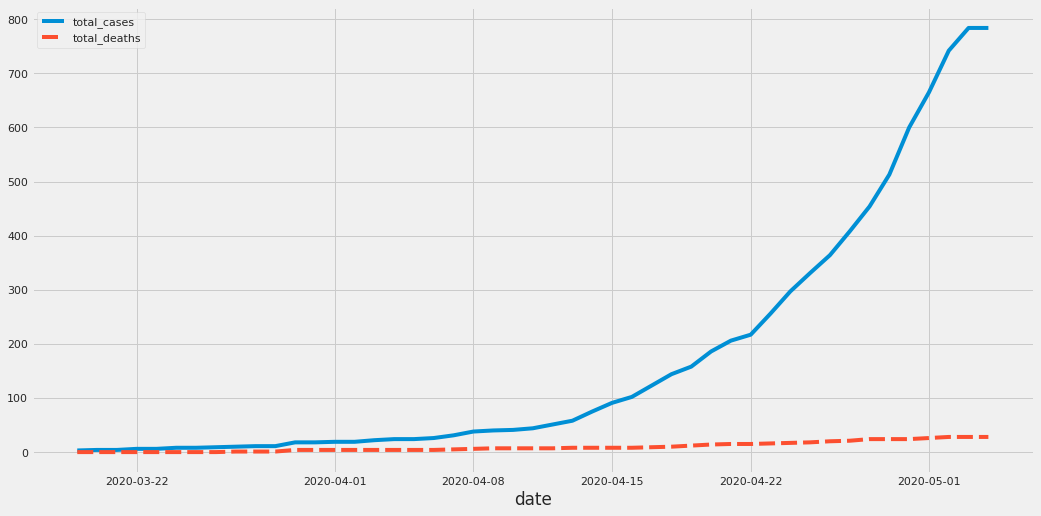

In [24]:
df_data_target['total_cases_ESTIMATED'] = (df_data_target['total_deaths'] / 0.05).shift(-7)
df_data_target['total_cases_ESTIMATED_2'] = 15 * df_data_target['total_cases']

# we have data for SRAG in Brazil only 
if target_location == 'Brazil':
    df_data_target['total_cases_ESTIMATED_FROM_SRAG'] = \
        (df_data_target['new_cases'] * df_srag_adjustment_multipliers['SRAG_adjustment_multiplier'].reindex_like(df_data_target, method='ffill'))\
            .cumsum()
else:
    df_data_target['total_cases_ESTIMATED_FROM_SRAG'] = df_data_target['new_cases'] * np.nan

sns.lineplot(data=df_data_target[['total_cases', 'total_deaths']])
df_data_target.tail()

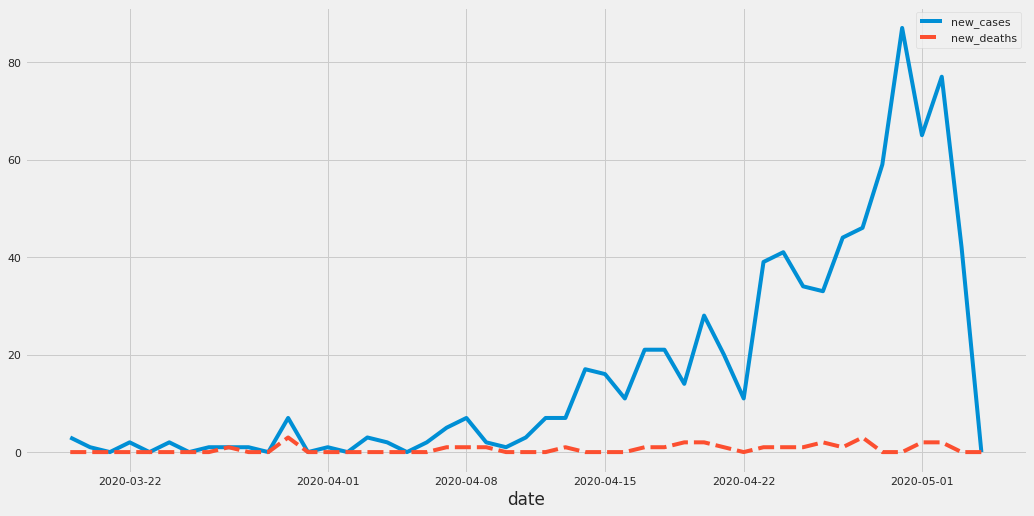

In [25]:
sns.lineplot(data=df_data_target[['new_cases', 'new_deaths']])

### Substituição de Parâmetros

Se requisitado, vamos substituir alguns dos parâmetros por valores presentes nos dados.

In [26]:
df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]

Timestamp('2020-04-12 00:00:00')

In [27]:
if infer_parameters_from_data:
    epidemic_start_date = df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]
    
    first_date_row = df_data_target.loc[epidemic_start_date]
    population_size = first_date_row['population']
    initially_infected = first_date_row[data_column_to_fit] #['total_cases']
    
    print(f'NEW VALUES: epidemic_start_date={epidemic_start_date}, population_size={population_size}, initially_infected={initially_infected}')
    

NEW VALUES: epidemic_start_date=2020-04-12 00:00:00, population_size=3273227.0, initially_infected=765.0


Filtremos os dados a partir da data de interesse.

In [28]:
df_data_target = df_data_target[epidemic_start_date:]

## Modelo SEIR

O [modelo SEIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) é um dos modos clássicos de se representar a dinâmica de epidemias. Trata-se de um chamado "modelo de compartimento", no qual temos alguns compartimentos principais:

  - S(t): número de indivíduos suscetíveis em função do tempo.
  - E(t): número de expostos, mas ainda não transmissores, em função do tempo.
  - I(t): número de indivíduos infecciosos em função do tempo.
  - R(t): número de indivíduos que se recuperam em função do tempo.
  
São também necessários dois outros parâmetros, que definem taxas de transição entre compartimentos:
  
  - beta: valor entre 0.0 e 1.0 que define a taxa de S para E (i.e., taxa de exposição)
  - alpha: valor entre 0.0 e 1.0 que define a taxa de E para I (i.e., taxa de contaminação)
  - gamma: valor entre 0.0 e 1.0 que define a taxa de I para R (i.e., taxa de recuperação)

Tradicionalmente, esse modelo é tratado via equações diferenciais. Aqui, adotaremos uma implementação via simulações estocásticas, o que nos permitirá posteriormente realizar modificações variadas que talvez não sejam tratáveis analiticamente.

### Funções Auxiliares

Antes de prosseguir, vamos definir algumas funções auxliares que garantirão que os valores acrescidos ou subtraídos nos diversos compartimentos não ultrapassem valores limites.

In [29]:
def aux_enforce_max_addition(Q, delta):
    if Q - delta <= 0:
        return Q
    
    else:
        return delta
    
def aux_enforce_max_removal(Q, delta):
    if Q + delta <= 0:
        return -Q
    else:
        return delta

Ao longo de uma epidemia, é razoável supor que autoridades sanitárias e, de fato, a polulação como um todo, adotarão medidas que possam reduzir o contágio e melhorar as chances de recuperação. Isso pode ser modelado com parâmetros dinâmicos, supondo-se intervenções em momentos precisos do tempo. Assim, os parâmetros do modelo aqui proposto podem ser tanto escalares quanto dicionários que mapeiam instantes a valores naqueles instantes. Para que a simulação possa usar transparentemente qualquer caso, definimos a seguir uma função que extrai o valor do parâmetro conforme o caso.

In [30]:
def param_at(param_var, t):
    if isinstance(param_var, dict):
        return param_var[t]
    
    else:
        return param_var

Convém também ter uma função para montar as sequências de parâmetros (veremos um exemplo mais adiante para entender seu uso).

In [31]:
def dynamic_parameter(regimens, min_length):
    i = 0
    params = {}
    last_value = None
    min_length = int(min_length)
    for value, length in regimens:
        length = int(length)
        param = {t: value for t in range(i, i + length)}
        params.update(param)
        i += length
        last_value = value
    
    # if we do not have enough data, fill in the remaining entries with the last specified value
    if i < min_length:
        param = {t: last_value for t in range(i, i + min_length)}
        params.update(param)

    return params

### Funções dos Compartimentos

Podemos agora definir a dinâmica dos diversos compartimentos contemplados no modelo.

In [32]:
def s(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_removal(S, 
                                    -((param_at(beta, t) * I * S) / population_size))
    
    return delta

In [33]:
def e(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    delta = aux_enforce_max_removal(E,  
                                    param_at(delta_s, t) - param_at(alpha, t)*E)    
    
        
    return delta

In [34]:
def i(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
        
    delta = aux_enforce_max_removal(I, 
                                    param_at(delta_e, t) - param_at(gamma, t)*I)
        
    return delta

In [35]:
def r(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta

Também convém poder calcular a variação dos compartimentos E e I para posterior análise.

In [36]:
# how many new patients will be added to E
def e_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    return delta_s

In [37]:
# how many new patients will be added to I
def i_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
    
    return delta_e

In [38]:
# how many new patients will be added to R
def r_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_r = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta_r

### Simulação

A simulação então pode ser definida do seguinte modo.

In [39]:
def simulate(S, E, I, R, alpha, beta, gamma, epidemic_start_date, epidemic_duration_in_days, 
             s_func, e_func, i_func, r_func, e_delta_func, i_delta_func, r_delta_func):
    
    generated_data = [] # initial data
    
    # changes start at 0
    E_delta = 0
    I_delta = 0 
    R_delta = 0
    
    for t in range(0, epidemic_duration_in_days):
        generated_data.append((S, E, E_delta, I, I_delta, R, R_delta))
        
        # main model components
        S_next = S + s_func(t, S, E, I, R, alpha, beta, gamma)
        E_next = E + e_func(t, S, E, I, R, alpha, beta, gamma)
        I_next = I + i_func(t, S, E, I, R, alpha, beta, gamma)
        R_next = R + r_func(t, S, E, I, R, alpha, beta, gamma)
        
        # added information for later analyses
        I_delta = i_delta_func(t, S, E, I, R, alpha, beta, gamma)
        E_delta = e_delta_func(t, S, E, I, R, alpha, beta, gamma)
        R_delta = r_delta_func(t, S, E, I, R, alpha, beta, gamma)

        # lockstep updates
        S = S_next
        E = E_next
        I = I_next
        R = R_next

        assert math.isclose(S + E + I + R, population_size, rel_tol=1e-9, abs_tol=0.0), "Population size must not change."
    
    df = pd.DataFrame(generated_data,
                      columns=['S', 'E', 'E_delta', 'I', 'I_delta', 'R', 'R_delta'],
                      index=pd.date_range(start=epidemic_start_date, periods=epidemic_duration_in_days, freq='D'))
    
    df['E+I'] = df['E'] + df['I']
    df['E+I+R'] = df['E'] + df['I'] + df['R']
    
    return df

Podemos agora simular situações de interesse definindo os parâmetros do modelo.

In [40]:
alpha = 0.9   # E to I rate
beta = 0.8   # S to E rate
gamma = 0.3  # I to R rate

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-04-12,3.272462e+06,765.000000,0.000000,0.000000,0.000000,0.000000,0.000000,765.000000,765.000000
2020-04-13,3.272462e+06,76.500000,0.000000,688.500000,688.500000,0.000000,0.000000,765.000000,765.000000
2020-04-14,3.271911e+06,558.321270,550.671270,550.800000,68.850000,206.550000,206.550000,1109.121270,1315.671270
2020-04-15,3.271471e+06,496.295012,440.462885,888.049143,502.489143,371.790000,165.240000,1384.344155,1756.134155
2020-04-16,3.270761e+06,759.687655,710.058153,1068.299911,446.665511,638.204743,266.414743,1827.987566,2466.192309


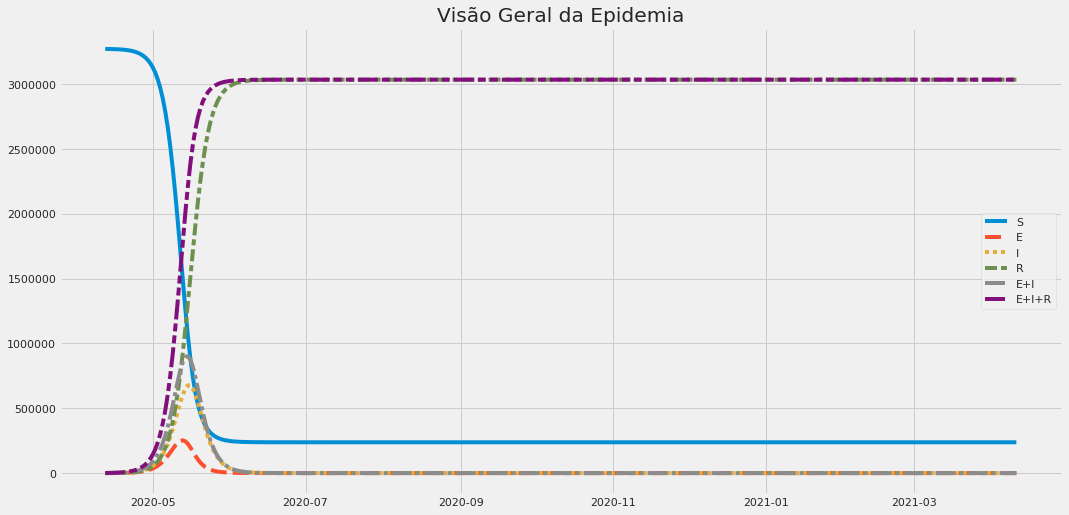

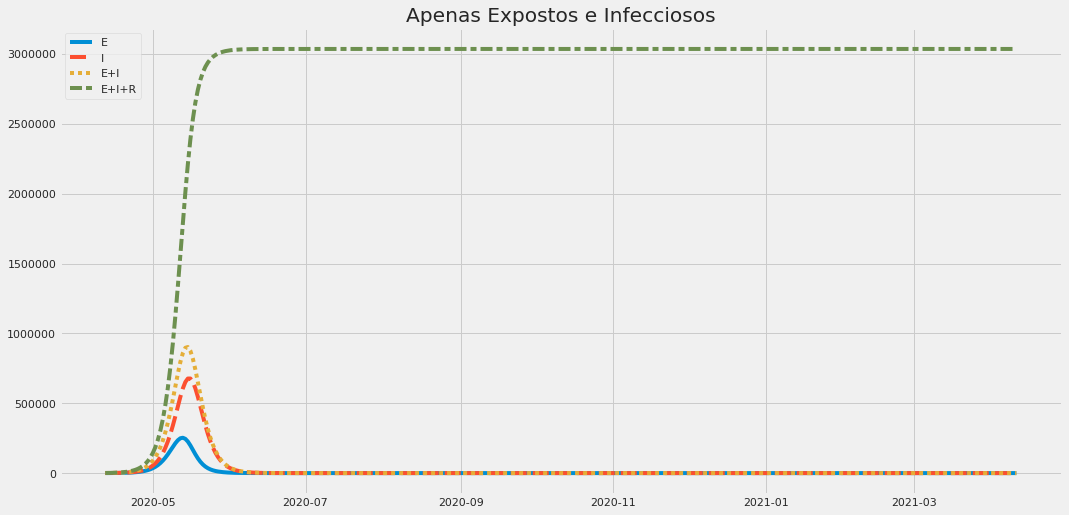

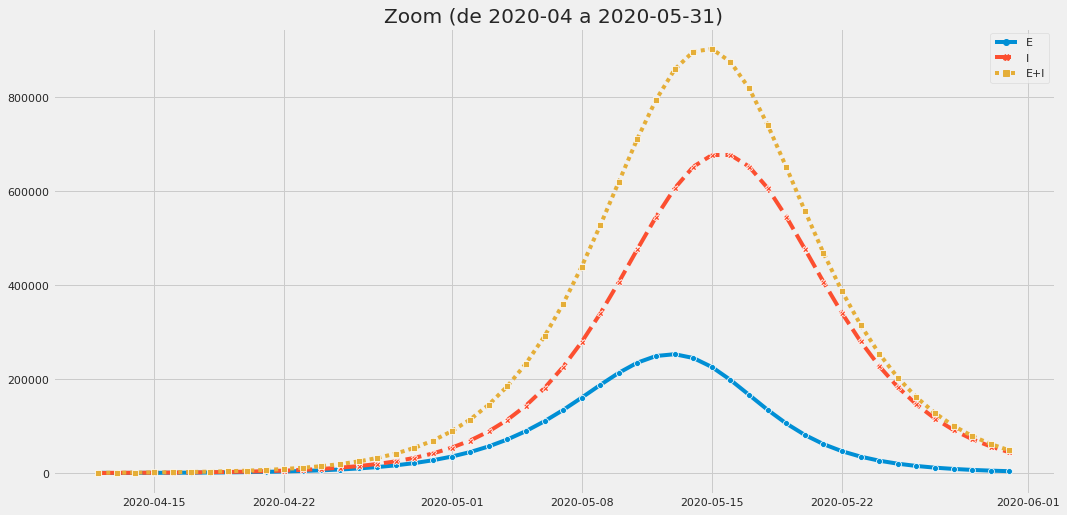

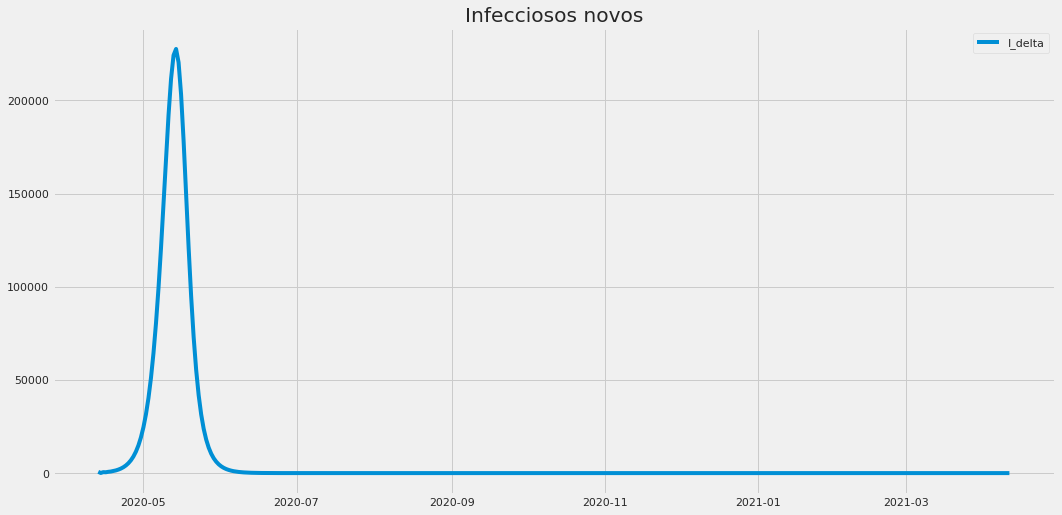

<Figure size 1152x576 with 0 Axes>

In [41]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data, zoom_on='2020-04')
df_simulation_data.head()

Como isso se compara visualmente com os dados reais observados?

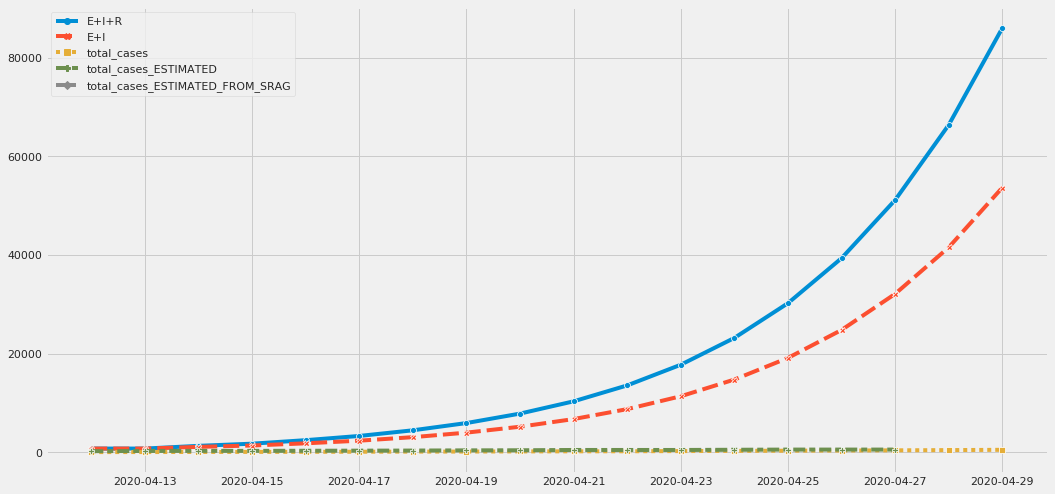

In [42]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=7)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I+R', 'E+I', 'total_cases', 'total_cases_ESTIMATED', 'total_cases_ESTIMATED_FROM_SRAG']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

Vejamos um exemplo agora de parâmetro dinâmico. Vamos definir o parâmetro *beta* como 0.3 nos primeiros 30 dias, 0.25 nos 60 dias seguintes e 0.2 daí em diante.

In [43]:
alpha = 1.0

beta = dynamic_parameter([(0.9, 10), 
                          (0.8, epidemic_duration_in_days)], min_length=epidemic_duration_in_days)

gamma = 0.4

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-04-12,3.272462e+06,765.000000,0.000000,0.000000,0.000000,0.000000,0.000000,765.000000,765.000000
2020-04-13,3.272462e+06,0.000000,0.000000,765.000000,765.000000,0.000000,0.000000,765.000000,765.000000
2020-04-14,3.271774e+06,688.339088,688.339088,459.000000,0.000000,306.000000,306.000000,1147.339088,1453.339088
2020-04-15,3.271361e+06,412.916580,412.916580,963.739088,688.339088,489.600000,183.600000,1376.655668,1866.255668
2020-04-16,3.270494e+06,866.870644,866.870644,991.160033,412.916580,875.095635,385.495635,1858.030677,2733.126312


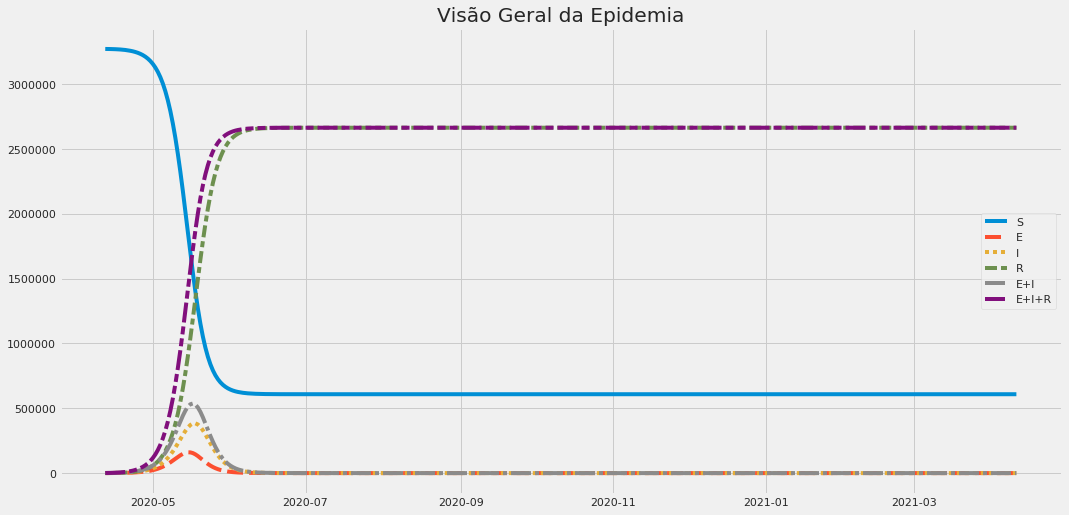

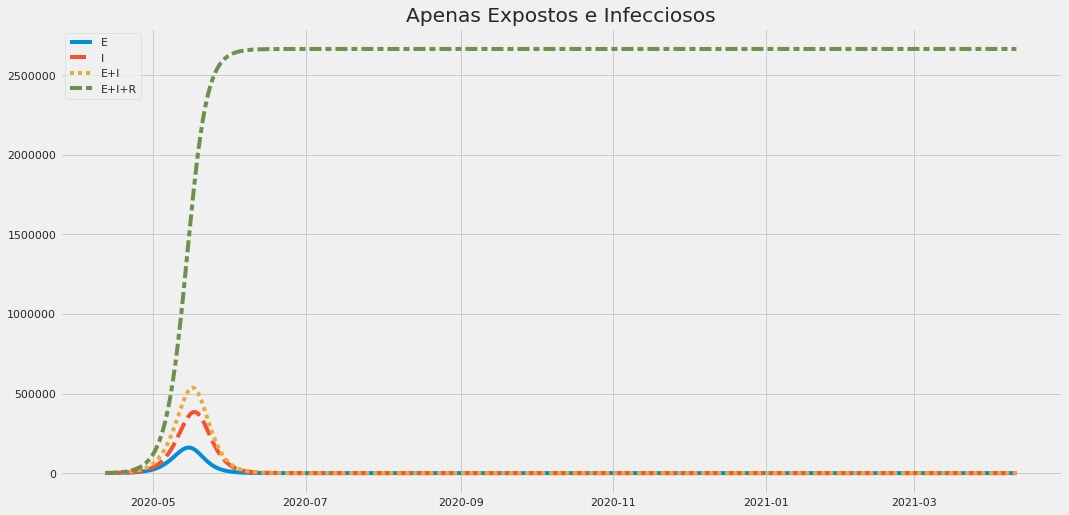

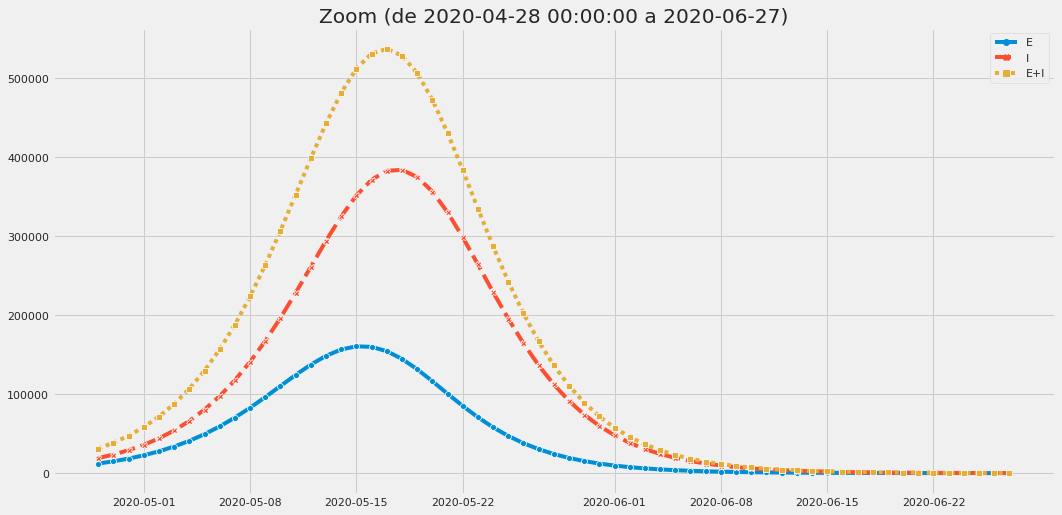

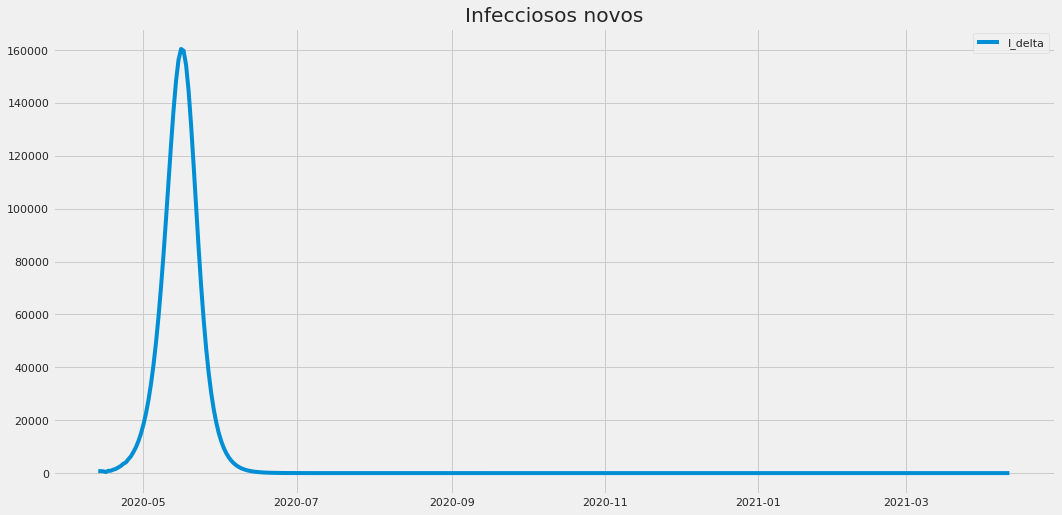

<Figure size 1152x576 with 0 Axes>

In [44]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data.head()

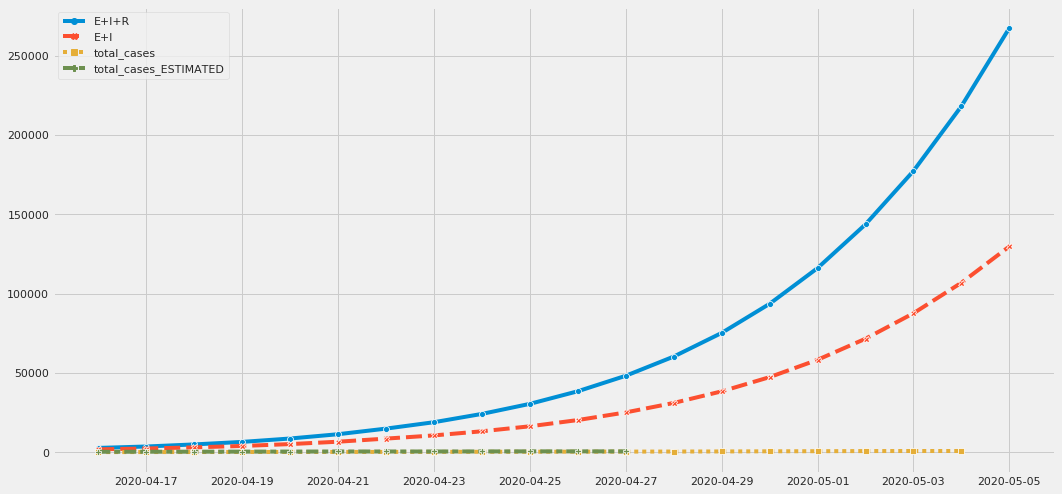

In [45]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=1)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I+R', 'E+I', 'total_cases', 'total_cases_ESTIMATED']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

## Calibragem de Parâmetros

Podemos agora confrontar os modelos acima com dados reais observados e, assim, encontrar os parâmetros que melhor aproximam a realidade.

Faremos a busca de parâmetros empregando a biblioteca [hyperopt](https://github.com/hyperopt/hyperopt). Para tanto, precisamos definir uma função objetivo a ser otimizada. Aqui, essa função executa uma simulação com os parâmetros (*alpha*, *beta* e *gamma*) sugeridos, obtém a curva de infecções resultante e calcula o erro absoluto médio com relação às datas para as quais temos as observações reais.

In [46]:
def objective_for_simulation(args):
    ##################################################################
    # What kind of parameters we are optimizing? Constant or dynamic?
    ##################################################################
    if 'constant' in args:
        alpha, beta, gamma, t_min, t_max = args['constant']
    elif 'dynamic' in args:
        params_sets, t_min, t_max = args['dynamic'] # TODO
        alpha = []
        beta = []
        gamma = []
        prev_alpha = None
        prev_beta = None
        prev_gamma = None
        prev_duration = None
        for params in params_sets:
            cur_alpha = params.get('alpha', prev_alpha)
            cur_beta = params.get('beta', prev_beta)
            cur_gamma = params.get('gamma', prev_gamma)
            cur_duration = int(params.get('duration', prev_duration))
            
            alpha.append((cur_alpha, cur_duration))
            beta.append((cur_beta, cur_duration))
            gamma.append((cur_gamma, cur_duration))
            
            prev_alpha = cur_alpha
            prev_beta = cur_beta
            prev_gamma = cur_gamma
            prev_duration = cur_duration
        
        alpha = dynamic_parameter(alpha, min_length=epidemic_duration_in_days)
        beta = dynamic_parameter(beta, min_length=epidemic_duration_in_days)
        gamma = dynamic_parameter(gamma, min_length=epidemic_duration_in_days)
        
    ###########
    # Simulate
    ###########
    df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha,beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,  
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)
    
    # run simulation
    df_simulation_data_filtered = df_simulation_data[df_simulation_data.index.isin(df_data_target.index.values)]
    
    ###################
    # Calculate error
    ###################
    df_diff_cases = df_data_target[data_column_to_fit] - \
                               (df_simulation_data_filtered['I'] + df_simulation_data_filtered['E'] + df_simulation_data_filtered['R'])
    
    # we can limit the temporal reach of the estimation if desired
    if t_min is not None and t_max is not None:
        df_diff_cases = df_diff_cases.iloc[t_min:t_max] 
    
    values = df_diff_cases.dropna().values

    mae = np.mean(abs(values)) #mean absolute error

    return mae

### Com Parâmetros Constantes

Suponhamos que os parâmetros do modelo sejam constantes, ou seja, que não haja mudanças de comportamento ou políticas ao longo da epidemia.

Definimos então o espaço de busca dos parâmetros e efetivamente executamos a busca.

In [47]:
#space = {'constant': (hyperopt.hp.uniform('alpha', 0.0, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, None)}
space = {'constant':(hyperopt.hp.uniform('alpha', 0.99, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, 15)}

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=1000, trials=trials)

print("Best parameters found:", best)

  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

  1%|▏         | 13/1000 [00:00<00:07, 123.53trial/s, best loss: 446.3118629816568]

  2%|▎         | 25/1000 [00:00<00:08, 118.92trial/s, best loss: 141.94881594819634]

  4%|▎         | 35/1000 [00:00<00:09, 106.80trial/s, best loss: 141.94881594819634]

  4%|▍         | 45/1000 [00:00<00:09, 101.62trial/s, best loss: 86.18146472870136] 

  5%|▌         | 54/1000 [00:00<00:09, 95.28trial/s, best loss: 86.18146472870136] 

  6%|▌         | 62/1000 [00:00<00:10, 88.61trial/s, best loss: 86.18146472870136]

  7%|▋         | 71/1000 [00:00<00:10, 88.59trial/s, best loss: 86.18146472870136]

  8%|▊         | 80/1000 [00:00<00:10, 88.27trial/s, best loss: 86.18146472870136]

  9%|▉         | 89/1000 [00:00<00:10, 88.53trial/s, best loss: 86.18146472870136]

 10%|▉         | 98/1000 [00:01<00:10, 88.75trial/s, best loss: 86.18146472870136]

 11%|█         | 107/1000 [00:01<00:10, 88.84trial/s, best loss: 86.18146472870136]

 12%|█▏        | 116/1000 [00:01<00:10, 88.08trial/s, best loss: 86.18146472870136]

 12%|█▎        | 125/1000 [00:01<00:10, 86.06trial/s, best loss: 86.18146472870136]

 13%|█▎        | 134/1000 [00:01<00:10, 82.66trial/s, best loss: 86.18146472870136]

 14%|█▍        | 143/1000 [00:01<00:11, 77.38trial/s, best loss: 86.18146472870136]

 15%|█▌        | 152/1000 [00:01<00:10, 79.09trial/s, best loss: 86.18146472870136]

 16%|█▌        | 161/1000 [00:01<00:10, 80.25trial/s, best loss: 86.18146472870136]

 17%|█▋        | 170/1000 [00:01<00:10, 81.47trial/s, best loss: 86.18146472870136]

 18%|█▊        | 179/1000 [00:02<00:10, 82.02trial/s, best loss: 86.18146472870136]

 19%|█▉        | 188/1000 [00:02<00:09, 82.21trial/s, best loss: 86.18146472870136]

 20%|█▉        | 197/1000 [00:02<00:09, 82.17trial/s, best loss: 86.18146472870136]

 21%|██        | 206/1000 [00:02<00:09, 79.72trial/s, best loss: 86.18146472870136]

 21%|██▏       | 214/1000 [00:02<00:09, 79.23trial/s, best loss: 86.18146472870136]

 22%|██▏       | 223/1000 [00:02<00:09, 79.37trial/s, best loss: 86.18146472870136]

 23%|██▎       | 232/1000 [00:02<00:09, 79.56trial/s, best loss: 86.18146472870136]

 24%|██▍       | 240/1000 [00:02<00:09, 79.25trial/s, best loss: 86.18146472870136]

 25%|██▍       | 249/1000 [00:02<00:09, 79.46trial/s, best loss: 86.18146472870136]

 26%|██▌       | 257/1000 [00:03<00:09, 79.32trial/s, best loss: 86.18146472870136]

 26%|██▋       | 265/1000 [00:03<00:09, 78.92trial/s, best loss: 86.18146472870136]

 27%|██▋       | 273/1000 [00:03<00:09, 77.72trial/s, best loss: 86.18146472870136]

 28%|██▊       | 281/1000 [00:03<00:09, 73.01trial/s, best loss: 86.18146472870136]

 29%|██▉       | 289/1000 [00:03<00:10, 67.41trial/s, best loss: 86.18146472870136]

 30%|██▉       | 297/1000 [00:03<00:10, 69.71trial/s, best loss: 86.18146472870136]

 30%|███       | 305/1000 [00:03<00:09, 71.55trial/s, best loss: 86.18146472870136]

 31%|███▏      | 313/1000 [00:03<00:09, 71.72trial/s, best loss: 86.18146472870136]

 32%|███▏      | 321/1000 [00:03<00:09, 72.63trial/s, best loss: 86.18146472870136]

 33%|███▎      | 329/1000 [00:04<00:09, 73.69trial/s, best loss: 86.18146472870136]

 34%|███▎      | 337/1000 [00:04<00:08, 74.25trial/s, best loss: 86.18146472870136]

 34%|███▍      | 345/1000 [00:04<00:08, 73.89trial/s, best loss: 86.18146472870136]

 35%|███▌      | 353/1000 [00:04<00:09, 65.42trial/s, best loss: 86.18146472870136]

 36%|███▌      | 360/1000 [00:04<00:10, 58.61trial/s, best loss: 86.18146472870136]

 37%|███▋      | 367/1000 [00:04<00:10, 58.87trial/s, best loss: 86.18146472870136]

 37%|███▋      | 374/1000 [00:04<00:10, 60.06trial/s, best loss: 86.18146472870136]

 38%|███▊      | 381/1000 [00:04<00:11, 53.30trial/s, best loss: 86.18146472870136]

 39%|███▊      | 387/1000 [00:05<00:11, 52.32trial/s, best loss: 86.18146472870136]

 39%|███▉      | 393/1000 [00:05<00:11, 52.87trial/s, best loss: 86.18146472870136]

 40%|███▉      | 399/1000 [00:05<00:11, 53.40trial/s, best loss: 86.18146472870136]

 40%|████      | 405/1000 [00:05<00:11, 52.57trial/s, best loss: 86.18146472870136]

 41%|████      | 411/1000 [00:05<00:11, 51.24trial/s, best loss: 86.18146472870136]

 42%|████▏     | 418/1000 [00:05<00:10, 54.69trial/s, best loss: 86.18146472870136]

 42%|████▎     | 425/1000 [00:05<00:10, 57.38trial/s, best loss: 86.18146472870136]

 43%|████▎     | 432/1000 [00:05<00:09, 58.54trial/s, best loss: 86.18146472870136]

 44%|████▍     | 439/1000 [00:05<00:09, 60.27trial/s, best loss: 86.18146472870136]

 45%|████▍     | 446/1000 [00:06<00:08, 61.73trial/s, best loss: 86.18146472870136]

 45%|████▌     | 453/1000 [00:06<00:09, 60.22trial/s, best loss: 86.18146472870136]

 46%|████▌     | 460/1000 [00:06<00:08, 60.53trial/s, best loss: 86.18146472870136]

 47%|████▋     | 467/1000 [00:06<00:09, 58.51trial/s, best loss: 86.18146472870136]

 47%|████▋     | 473/1000 [00:06<00:09, 56.36trial/s, best loss: 86.18146472870136]

 48%|████▊     | 479/1000 [00:06<00:09, 56.10trial/s, best loss: 86.18146472870136]

 48%|████▊     | 485/1000 [00:06<00:09, 56.92trial/s, best loss: 86.18146472870136]

 49%|████▉     | 491/1000 [00:06<00:08, 57.63trial/s, best loss: 86.18146472870136]

 50%|████▉     | 497/1000 [00:06<00:08, 56.30trial/s, best loss: 86.18146472870136]

 50%|█████     | 504/1000 [00:07<00:08, 57.45trial/s, best loss: 86.18146472870136]

 51%|█████     | 510/1000 [00:07<00:09, 51.87trial/s, best loss: 86.18146472870136]

 52%|█████▏    | 516/1000 [00:07<00:09, 49.19trial/s, best loss: 86.18146472870136]

 52%|█████▏    | 522/1000 [00:07<00:09, 48.41trial/s, best loss: 86.18146472870136]

 53%|█████▎    | 528/1000 [00:07<00:09, 51.26trial/s, best loss: 86.18146472870136]

 54%|█████▎    | 535/1000 [00:07<00:08, 54.30trial/s, best loss: 86.18146472870136]

 54%|█████▍    | 542/1000 [00:07<00:08, 55.59trial/s, best loss: 86.18146472870136]

 55%|█████▍    | 548/1000 [00:07<00:07, 56.72trial/s, best loss: 86.18146472870136]

 56%|█████▌    | 555/1000 [00:08<00:07, 57.89trial/s, best loss: 86.18146472870136]

 56%|█████▌    | 561/1000 [00:08<00:07, 57.44trial/s, best loss: 86.18146472870136]

 57%|█████▋    | 568/1000 [00:08<00:07, 58.44trial/s, best loss: 86.18146472870136]

 57%|█████▋    | 574/1000 [00:08<00:07, 56.66trial/s, best loss: 86.18146472870136]

 58%|█████▊    | 580/1000 [00:08<00:07, 57.21trial/s, best loss: 86.18146472870136]

 59%|█████▊    | 586/1000 [00:08<00:07, 57.38trial/s, best loss: 86.18146472870136]

 59%|█████▉    | 592/1000 [00:08<00:07, 57.59trial/s, best loss: 86.18146472870136]

 60%|█████▉    | 598/1000 [00:08<00:06, 57.62trial/s, best loss: 86.18146472870136]

 60%|██████    | 604/1000 [00:08<00:06, 58.18trial/s, best loss: 86.18146472870136]

 61%|██████    | 610/1000 [00:09<00:06, 58.65trial/s, best loss: 86.18146472870136]

 62%|██████▏   | 616/1000 [00:09<00:06, 58.72trial/s, best loss: 86.18146472870136]

 62%|██████▏   | 622/1000 [00:09<00:06, 58.88trial/s, best loss: 86.18146472870136]

 63%|██████▎   | 628/1000 [00:09<00:06, 58.24trial/s, best loss: 86.18146472870136]

 63%|██████▎   | 634/1000 [00:09<00:06, 56.76trial/s, best loss: 86.18146472870136]

 64%|██████▍   | 640/1000 [00:09<00:06, 56.29trial/s, best loss: 66.55074730112398]

 65%|██████▍   | 646/1000 [00:09<00:06, 56.21trial/s, best loss: 66.55074730112398]

 65%|██████▌   | 652/1000 [00:09<00:06, 56.26trial/s, best loss: 66.55074730112398]

 66%|██████▌   | 658/1000 [00:09<00:06, 55.78trial/s, best loss: 66.55074730112398]

 66%|██████▋   | 664/1000 [00:09<00:05, 56.47trial/s, best loss: 66.55074730112398]

 67%|██████▋   | 670/1000 [00:10<00:05, 56.85trial/s, best loss: 66.55074730112398]

 68%|██████▊   | 676/1000 [00:10<00:05, 56.68trial/s, best loss: 66.55074730112398]

 68%|██████▊   | 682/1000 [00:10<00:05, 56.90trial/s, best loss: 66.55074730112398]

 69%|██████▉   | 688/1000 [00:10<00:06, 51.29trial/s, best loss: 66.55074730112398]

 69%|██████▉   | 694/1000 [00:10<00:05, 51.11trial/s, best loss: 66.55074730112398]

 70%|███████   | 700/1000 [00:10<00:05, 52.36trial/s, best loss: 66.55074730112398]

 71%|███████   | 706/1000 [00:10<00:05, 52.41trial/s, best loss: 66.55074730112398]

 71%|███████   | 712/1000 [00:10<00:05, 53.47trial/s, best loss: 66.55074730112398]

 72%|███████▏  | 718/1000 [00:11<00:05, 48.89trial/s, best loss: 66.55074730112398]

 72%|███████▏  | 724/1000 [00:11<00:05, 50.80trial/s, best loss: 66.55074730112398]

 73%|███████▎  | 730/1000 [00:11<00:05, 52.41trial/s, best loss: 66.55074730112398]

 74%|███████▎  | 736/1000 [00:11<00:05, 52.04trial/s, best loss: 66.55074730112398]

 74%|███████▍  | 742/1000 [00:11<00:04, 52.90trial/s, best loss: 66.55074730112398]

 75%|███████▍  | 748/1000 [00:11<00:04, 53.34trial/s, best loss: 66.55074730112398]

 75%|███████▌  | 754/1000 [00:11<00:04, 53.95trial/s, best loss: 66.55074730112398]

 76%|███████▌  | 760/1000 [00:11<00:04, 53.67trial/s, best loss: 66.55074730112398]

 77%|███████▋  | 766/1000 [00:11<00:04, 53.90trial/s, best loss: 66.55074730112398]

 77%|███████▋  | 772/1000 [00:12<00:04, 54.19trial/s, best loss: 66.55074730112398]

 78%|███████▊  | 778/1000 [00:12<00:04, 54.32trial/s, best loss: 66.55074730112398]

 78%|███████▊  | 784/1000 [00:12<00:03, 54.31trial/s, best loss: 66.55074730112398]

 79%|███████▉  | 790/1000 [00:12<00:03, 53.21trial/s, best loss: 66.55074730112398]

 80%|███████▉  | 796/1000 [00:12<00:03, 53.03trial/s, best loss: 66.55074730112398]

 80%|████████  | 802/1000 [00:12<00:03, 52.82trial/s, best loss: 66.55074730112398]

 81%|████████  | 808/1000 [00:12<00:03, 53.20trial/s, best loss: 66.55074730112398]

 81%|████████▏ | 814/1000 [00:12<00:03, 53.32trial/s, best loss: 66.55074730112398]

 82%|████████▏ | 820/1000 [00:12<00:03, 53.51trial/s, best loss: 66.55074730112398]

 83%|████████▎ | 826/1000 [00:13<00:03, 53.76trial/s, best loss: 66.55074730112398]

 83%|████████▎ | 832/1000 [00:13<00:03, 53.73trial/s, best loss: 66.55074730112398]

 84%|████████▍ | 838/1000 [00:13<00:03, 53.76trial/s, best loss: 66.55074730112398]

 84%|████████▍ | 844/1000 [00:13<00:02, 52.48trial/s, best loss: 66.55074730112398]

 85%|████████▌ | 850/1000 [00:13<00:02, 52.54trial/s, best loss: 66.55074730112398]

 86%|████████▌ | 856/1000 [00:13<00:03, 47.04trial/s, best loss: 66.55074730112398]

 86%|████████▌ | 862/1000 [00:13<00:02, 48.44trial/s, best loss: 66.55074730112398]

 87%|████████▋ | 868/1000 [00:13<00:02, 49.51trial/s, best loss: 66.55074730112398]

 87%|████████▋ | 874/1000 [00:13<00:02, 50.59trial/s, best loss: 66.55074730112398]

 88%|████████▊ | 880/1000 [00:14<00:02, 51.12trial/s, best loss: 66.55074730112398]

 89%|████████▊ | 886/1000 [00:14<00:02, 51.50trial/s, best loss: 66.55074730112398]

 89%|████████▉ | 892/1000 [00:14<00:02, 50.42trial/s, best loss: 66.55074730112398]

 90%|████████▉ | 898/1000 [00:14<00:02, 50.67trial/s, best loss: 66.55074730112398]

 90%|█████████ | 904/1000 [00:14<00:01, 50.73trial/s, best loss: 66.55074730112398]

 91%|█████████ | 910/1000 [00:14<00:01, 50.61trial/s, best loss: 66.55074730112398]

 92%|█████████▏| 916/1000 [00:14<00:01, 50.68trial/s, best loss: 66.55074730112398]

 92%|█████████▏| 922/1000 [00:14<00:01, 50.52trial/s, best loss: 66.55074730112398]

 93%|█████████▎| 928/1000 [00:15<00:01, 50.36trial/s, best loss: 66.55074730112398]

 93%|█████████▎| 934/1000 [00:15<00:01, 49.84trial/s, best loss: 66.55074730112398]

 94%|█████████▍| 939/1000 [00:15<00:01, 49.16trial/s, best loss: 66.55074730112398]

 94%|█████████▍| 944/1000 [00:15<00:01, 47.28trial/s, best loss: 66.55074730112398]

 95%|█████████▍| 949/1000 [00:15<00:01, 47.49trial/s, best loss: 66.55074730112398]

 95%|█████████▌| 954/1000 [00:15<00:01, 45.25trial/s, best loss: 66.55074730112398]

 96%|█████████▌| 960/1000 [00:15<00:00, 46.58trial/s, best loss: 66.55074730112398]

 97%|█████████▋| 966/1000 [00:15<00:00, 47.71trial/s, best loss: 66.55074730112398]

 97%|█████████▋| 972/1000 [00:15<00:00, 48.57trial/s, best loss: 66.55074730112398]

 98%|█████████▊| 978/1000 [00:16<00:00, 49.19trial/s, best loss: 66.55074730112398]

 98%|█████████▊| 983/1000 [00:16<00:00, 48.21trial/s, best loss: 66.55074730112398]

 99%|█████████▉| 988/1000 [00:16<00:00, 48.44trial/s, best loss: 66.55074730112398]

 99%|█████████▉| 993/1000 [00:16<00:00, 45.94trial/s, best loss: 66.55074730112398]

100%|█████████▉| 998/1000 [00:16<00:00, 40.94trial/s, best loss: 66.55074730112398]

100%|██████████| 1000/1000 [00:16<00:00, 60.15trial/s, best loss: 66.55074730112398]


Best parameters found: {'alpha': 0.9915269112293008, 'beta': 0.3853953179061608, 'gamma': 0.28170504301518595}


In [48]:
#trials.losses()
#pd.Series(trials.losses()).plot(title='Loss during optimiztion')

Podemos então executar o modelo com os parâmetros encontrados e examinar as curvas de progressão da epidemia.

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-04-12,3.272462e+06,765.000000,0.000000,0.000000,0.000000,0.000000,0.000000,765.000000,765.000000
2020-04-13,3.272462e+06,6.481913,0.000000,758.518087,758.518087,0.000000,0.000000,765.000000,765.000000
2020-04-14,3.272170e+06,292.315920,292.260998,551.266708,6.426991,213.678370,213.678370,843.582627,1057.260998
2020-04-15,3.271957e+06,214.863803,212.386984,685.811197,289.839101,368.972982,155.294612,900.675000,1269.647982
2020-04-16,3.271693e+06,266.026462,264.205902,705.657967,213.043243,562.169455,193.196473,971.684429,1533.853884


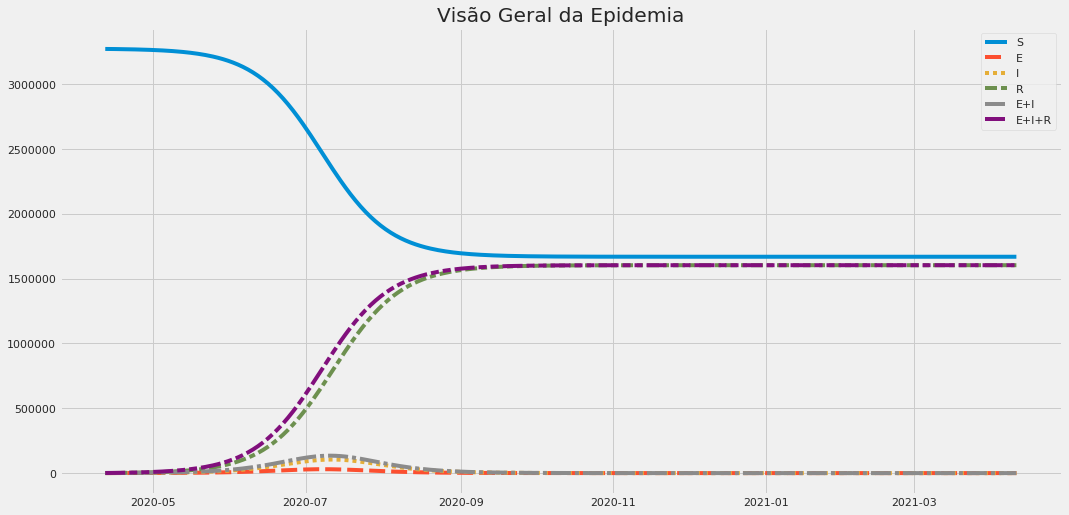

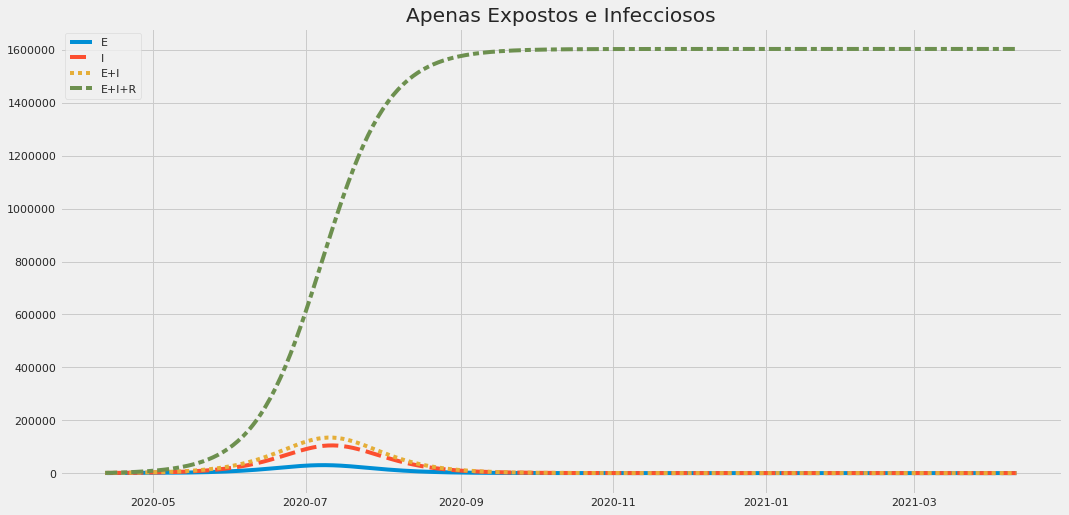

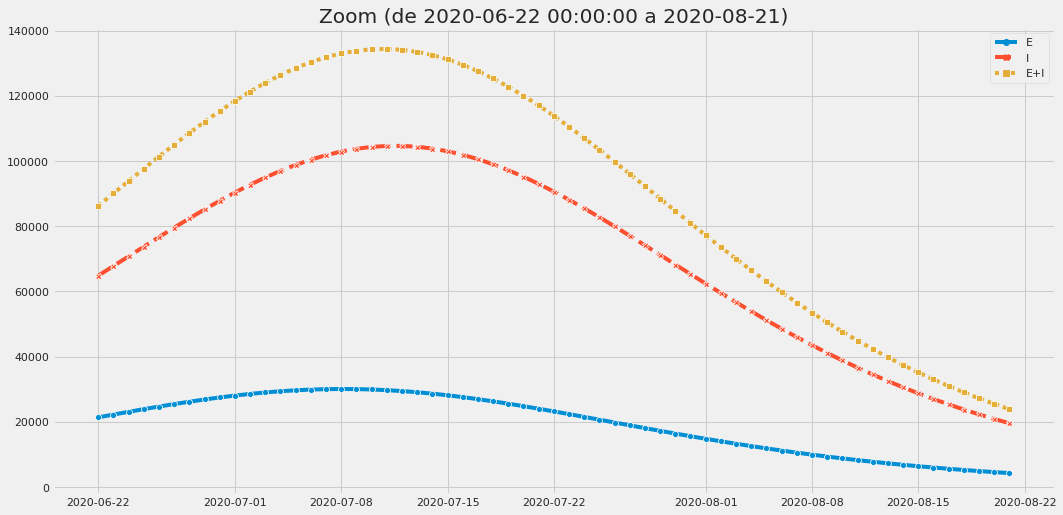

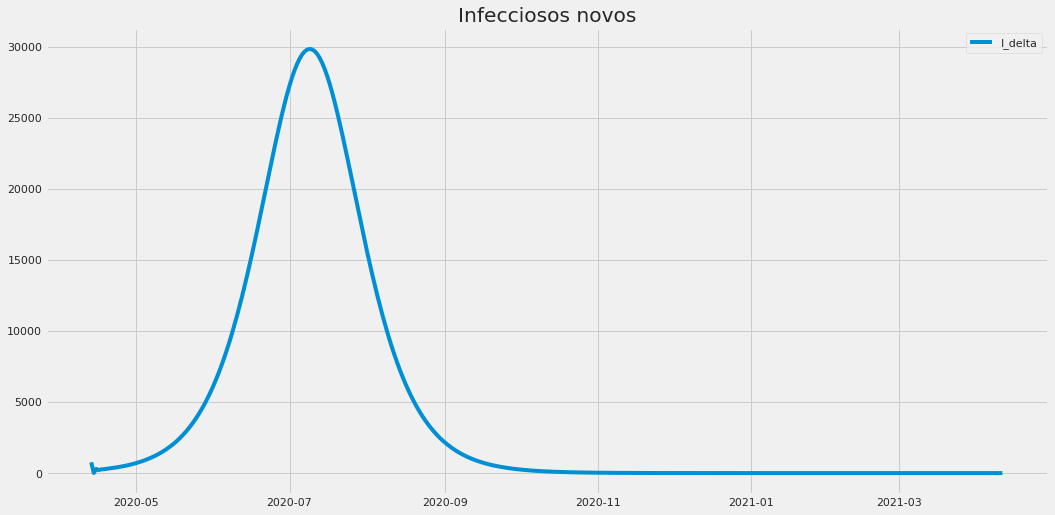

<Figure size 1152x576 with 0 Axes>

In [49]:
alpha = best['alpha']
beta  = best['beta']
gamma = best['gamma']

df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data['2020-03-16':'2020-05-01'].head()

Como isso se compara visualmente com os dados reais observados?

In [50]:
df_data_target.tail()

,new_cases,new_deaths,total_cases,total_deaths,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2,total_cases_ESTIMATED_FROM_SRAG
date,,,,,,,,
2020-04-30,87,0,600,24,3273227.0,NaN,9000,NaN
2020-05-01,65,2,665,26,3273227.0,NaN,9975,NaN
2020-05-02,77,2,742,28,3273227.0,NaN,11130,NaN
2020-05-03,42,0,784,28,3273227.0,NaN,11760,NaN
2020-05-04,0,0,784,28,3273227.0,NaN,11760,NaN


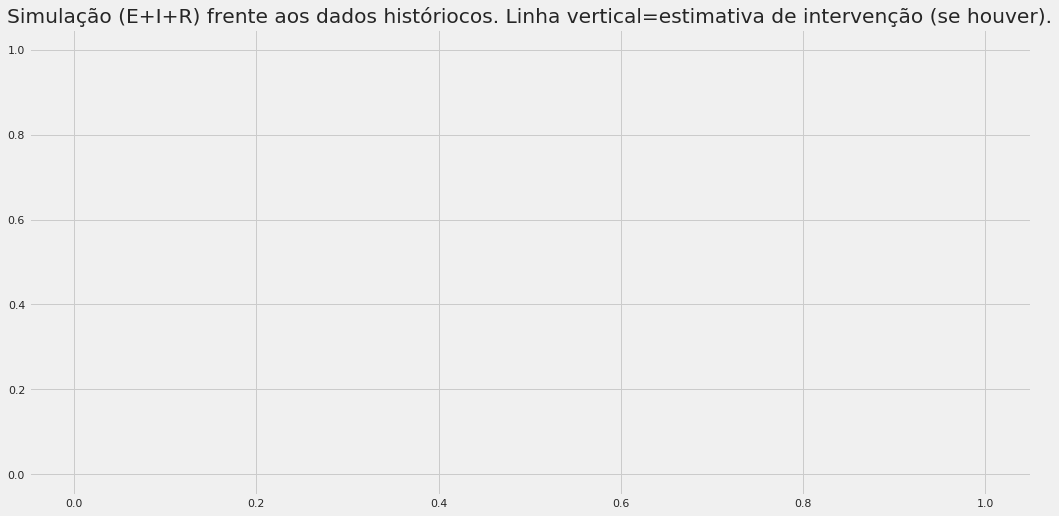

In [51]:
plot_curve_fitting(df_simulation_data=df_simulation_data, 
                   df_data_target=df_data_target, 
                   target_location=target_location, 
                   comparison_date=pd.Timestamp('2020-04-01'),
                   best=best)

Salvemos os resultados.

In [52]:
df_simulation_data.to_csv(results_folder + f'seir_model_output.{target_location.lower()}.csv')

### Com Parâmetros Dinâmicos

Vamos experimentar agora introduzindo a possibilidade de aprender medidas de mitigação após o início do surto. Ou seja, experimentaremos com dois grupos de parâmetros: aqueles *antes* das medidas, e aqueles *depois* das medidas. Esses dois conjuntos de parâmetros serão estimados a partir dos dados fornecidos.

In [53]:
## assuming different gammas
#
#space = \
#    {'dynamic':\
#        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_1', 1.0, 10.0)}, 
#           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_2', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_2', 1.0, 10.0)},
#         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_3', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_3', 1.0, 10.0)}], 
#        0, 60)
#    }

# assuming gamma_1 == gamma_2 == gamma_3
space = \
    {'dynamic':\
        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
           'duration': hyperopt.hp.uniform('duration_1', 1.0, 20.0)}, 
           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0),
           'duration': hyperopt.hp.uniform('duration_2', 1.0, 20.0)},
         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0),
           'duration': hyperopt.hp.uniform('duration_3', 1.0, 20.0)}], 
        0, 60)
    }

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=3000, trials=trials)

print("Best parameters found:", best)

  0%|          | 0/3000 [00:00<?, ?trial/s, best loss=?]

  0%|          | 10/3000 [00:00<00:32, 91.74trial/s, best loss: 1005.8119901338763]

  1%|          | 20/3000 [00:00<00:31, 93.18trial/s, best loss: 759.1376642977054] 

  1%|          | 25/3000 [00:00<00:48, 61.73trial/s, best loss: 385.6597955225245]

  1%|          | 30/3000 [00:00<00:51, 57.25trial/s, best loss: 385.6597955225245]

  1%|          | 35/3000 [00:00<01:03, 46.94trial/s, best loss: 385.6597955225245]

  1%|▏         | 40/3000 [00:00<01:02, 47.62trial/s, best loss: 385.6597955225245]

  2%|▏         | 45/3000 [00:00<01:02, 47.45trial/s, best loss: 385.6597955225245]

  2%|▏         | 50/3000 [00:00<01:01, 48.10trial/s, best loss: 385.6597955225245]

  2%|▏         | 55/3000 [00:01<01:02, 47.40trial/s, best loss: 385.6597955225245]

  2%|▏         | 60/3000 [00:01<01:01, 47.84trial/s, best loss: 385.6597955225245]

  2%|▏         | 65/3000 [00:01<01:00, 48.30trial/s, best loss: 385.6597955225245]

  2%|▏         | 70/3000 [00:01<01:00, 48.67trial/s, best loss: 385.6597955225245]

  2%|▎         | 75/3000 [00:01<01:00, 48.68trial/s, best loss: 385.6597955225245]

  3%|▎         | 80/3000 [00:01<00:59, 48.70trial/s, best loss: 385.6597955225245]

  3%|▎         | 85/3000 [00:01<01:01, 47.07trial/s, best loss: 385.6597955225245]

  3%|▎         | 90/3000 [00:01<01:02, 46.59trial/s, best loss: 385.6597955225245]

  3%|▎         | 95/3000 [00:01<01:02, 46.41trial/s, best loss: 369.1273368610879]

  3%|▎         | 100/3000 [00:01<01:02, 46.49trial/s, best loss: 369.1273368610879]

  4%|▎         | 105/3000 [00:02<01:09, 41.69trial/s, best loss: 369.1273368610879]

  4%|▎         | 110/3000 [00:02<01:06, 43.21trial/s, best loss: 369.1273368610879]

  4%|▍         | 115/3000 [00:02<01:05, 44.25trial/s, best loss: 369.1273368610879]

  4%|▍         | 120/3000 [00:02<01:04, 44.97trial/s, best loss: 369.1273368610879]

  4%|▍         | 125/3000 [00:02<01:05, 44.09trial/s, best loss: 369.1273368610879]

  4%|▍         | 130/3000 [00:02<01:05, 43.66trial/s, best loss: 369.1273368610879]

  4%|▍         | 135/3000 [00:02<01:05, 43.72trial/s, best loss: 369.1273368610879]

  5%|▍         | 140/3000 [00:02<01:04, 44.09trial/s, best loss: 369.1273368610879]

  5%|▍         | 145/3000 [00:03<01:04, 44.18trial/s, best loss: 369.1273368610879]

  5%|▌         | 150/3000 [00:03<01:04, 44.37trial/s, best loss: 369.1273368610879]

  5%|▌         | 155/3000 [00:03<01:04, 44.25trial/s, best loss: 369.1273368610879]

  5%|▌         | 160/3000 [00:03<01:04, 43.97trial/s, best loss: 369.1273368610879]

  6%|▌         | 165/3000 [00:03<01:04, 43.86trial/s, best loss: 369.1273368610879]

  6%|▌         | 170/3000 [00:03<01:06, 42.63trial/s, best loss: 369.1273368610879]

  6%|▌         | 175/3000 [00:03<01:05, 43.00trial/s, best loss: 369.1273368610879]

  6%|▌         | 180/3000 [00:03<01:06, 42.66trial/s, best loss: 369.1273368610879]

  6%|▌         | 185/3000 [00:03<01:06, 42.56trial/s, best loss: 369.1273368610879]

  6%|▋         | 190/3000 [00:04<01:06, 42.38trial/s, best loss: 369.1273368610879]

  6%|▋         | 195/3000 [00:04<01:06, 41.97trial/s, best loss: 369.1273368610879]

  7%|▋         | 200/3000 [00:04<01:19, 35.30trial/s, best loss: 369.1273368610879]

  7%|▋         | 205/3000 [00:04<01:15, 37.08trial/s, best loss: 369.1273368610879]

  7%|▋         | 210/3000 [00:04<01:13, 38.20trial/s, best loss: 369.1273368610879]

  7%|▋         | 215/3000 [00:04<01:11, 39.10trial/s, best loss: 369.1273368610879]

  7%|▋         | 220/3000 [00:04<01:10, 39.69trial/s, best loss: 369.1273368610879]

  8%|▊         | 225/3000 [00:04<01:09, 40.13trial/s, best loss: 369.1273368610879]

  8%|▊         | 230/3000 [00:05<01:08, 40.42trial/s, best loss: 369.1273368610879]

  8%|▊         | 235/3000 [00:05<01:07, 40.67trial/s, best loss: 369.1273368610879]

  8%|▊         | 240/3000 [00:05<01:07, 40.71trial/s, best loss: 369.1273368610879]

  8%|▊         | 245/3000 [00:05<01:07, 40.58trial/s, best loss: 231.53603997271048]

  8%|▊         | 250/3000 [00:05<01:10, 39.22trial/s, best loss: 231.53603997271048]

  8%|▊         | 254/3000 [00:05<01:09, 39.44trial/s, best loss: 231.53603997271048]

  9%|▊         | 258/3000 [00:05<01:09, 39.27trial/s, best loss: 231.53603997271048]

  9%|▉         | 263/3000 [00:05<01:09, 39.53trial/s, best loss: 231.53603997271048]

  9%|▉         | 267/3000 [00:06<01:09, 39.05trial/s, best loss: 231.53603997271048]

  9%|▉         | 271/3000 [00:06<01:09, 39.08trial/s, best loss: 231.53603997271048]

  9%|▉         | 275/3000 [00:06<01:09, 39.09trial/s, best loss: 231.53603997271048]

  9%|▉         | 279/3000 [00:06<01:09, 39.02trial/s, best loss: 231.53603997271048]

  9%|▉         | 283/3000 [00:06<01:09, 38.91trial/s, best loss: 231.53603997271048]

 10%|▉         | 287/3000 [00:06<01:11, 37.91trial/s, best loss: 231.53603997271048]

 10%|▉         | 291/3000 [00:06<01:12, 37.51trial/s, best loss: 231.53603997271048]

 10%|▉         | 295/3000 [00:06<01:12, 37.36trial/s, best loss: 184.75301329119904]

 10%|▉         | 299/3000 [00:06<01:11, 37.59trial/s, best loss: 184.75301329119904]

 10%|█         | 303/3000 [00:07<01:11, 37.67trial/s, best loss: 184.75301329119904]

 10%|█         | 307/3000 [00:07<01:11, 37.48trial/s, best loss: 184.75301329119904]

 10%|█         | 311/3000 [00:07<01:11, 37.75trial/s, best loss: 184.75301329119904]

 10%|█         | 315/3000 [00:07<01:10, 37.88trial/s, best loss: 184.75301329119904]

 11%|█         | 319/3000 [00:07<01:10, 37.81trial/s, best loss: 184.75301329119904]

 11%|█         | 323/3000 [00:07<01:10, 37.80trial/s, best loss: 184.75301329119904]

 11%|█         | 327/3000 [00:07<01:13, 36.60trial/s, best loss: 184.75301329119904]

 11%|█         | 331/3000 [00:07<01:13, 36.46trial/s, best loss: 184.75301329119904]

 11%|█         | 335/3000 [00:07<01:12, 36.62trial/s, best loss: 184.75301329119904]

 11%|█▏        | 339/3000 [00:07<01:12, 36.47trial/s, best loss: 184.75301329119904]

 11%|█▏        | 343/3000 [00:08<01:13, 36.13trial/s, best loss: 184.75301329119904]

 12%|█▏        | 347/3000 [00:08<01:14, 35.78trial/s, best loss: 184.75301329119904]

 12%|█▏        | 351/3000 [00:08<01:16, 34.60trial/s, best loss: 184.75301329119904]

 12%|█▏        | 355/3000 [00:08<01:17, 33.93trial/s, best loss: 184.75301329119904]

 12%|█▏        | 359/3000 [00:08<01:22, 32.13trial/s, best loss: 184.75301329119904]

 12%|█▏        | 363/3000 [00:08<01:25, 30.82trial/s, best loss: 184.75301329119904]

 12%|█▏        | 367/3000 [00:08<01:33, 28.09trial/s, best loss: 184.75301329119904]

 12%|█▏        | 371/3000 [00:09<01:30, 28.92trial/s, best loss: 184.75301329119904]

 12%|█▎        | 375/3000 [00:09<01:28, 29.69trial/s, best loss: 184.75301329119904]

 13%|█▎        | 379/3000 [00:09<01:26, 30.15trial/s, best loss: 184.75301329119904]

 13%|█▎        | 383/3000 [00:09<01:25, 30.54trial/s, best loss: 184.75301329119904]

 13%|█▎        | 387/3000 [00:09<01:26, 30.27trial/s, best loss: 184.75301329119904]

 13%|█▎        | 391/3000 [00:09<01:33, 27.92trial/s, best loss: 184.75301329119904]

 13%|█▎        | 395/3000 [00:09<01:30, 28.66trial/s, best loss: 184.75301329119904]

 13%|█▎        | 399/3000 [00:09<01:29, 29.14trial/s, best loss: 184.75301329119904]

 13%|█▎        | 402/3000 [00:10<01:30, 28.85trial/s, best loss: 184.75301329119904]

 14%|█▎        | 406/3000 [00:10<01:28, 29.36trial/s, best loss: 184.75301329119904]

 14%|█▎        | 410/3000 [00:10<01:26, 29.87trial/s, best loss: 184.75301329119904]

 14%|█▍        | 414/3000 [00:10<01:25, 30.21trial/s, best loss: 184.75301329119904]

 14%|█▍        | 418/3000 [00:10<01:32, 27.84trial/s, best loss: 184.75301329119904]

 14%|█▍        | 421/3000 [00:10<01:32, 28.01trial/s, best loss: 184.75301329119904]

 14%|█▍        | 425/3000 [00:10<01:29, 28.64trial/s, best loss: 184.75301329119904]

 14%|█▍        | 429/3000 [00:11<01:28, 28.96trial/s, best loss: 184.75301329119904]

 14%|█▍        | 432/3000 [00:11<01:28, 29.16trial/s, best loss: 184.75301329119904]

 14%|█▍        | 435/3000 [00:11<01:38, 26.15trial/s, best loss: 184.75301329119904]

 15%|█▍        | 439/3000 [00:11<01:33, 27.28trial/s, best loss: 184.75301329119904]

 15%|█▍        | 443/3000 [00:11<01:31, 28.05trial/s, best loss: 184.75301329119904]

 15%|█▍        | 446/3000 [00:11<01:30, 28.07trial/s, best loss: 184.75301329119904]

 15%|█▍        | 449/3000 [00:11<01:29, 28.45trial/s, best loss: 184.75301329119904]

 15%|█▌        | 452/3000 [00:11<01:28, 28.79trial/s, best loss: 184.75301329119904]

 15%|█▌        | 455/3000 [00:11<01:27, 29.03trial/s, best loss: 184.75301329119904]

 15%|█▌        | 458/3000 [00:12<01:27, 29.15trial/s, best loss: 184.75301329119904]

 15%|█▌        | 461/3000 [00:12<01:26, 29.30trial/s, best loss: 184.75301329119904]

 15%|█▌        | 464/3000 [00:12<01:26, 29.47trial/s, best loss: 184.75301329119904]

 16%|█▌        | 467/3000 [00:12<01:25, 29.53trial/s, best loss: 184.75301329119904]

 16%|█▌        | 470/3000 [00:12<01:25, 29.45trial/s, best loss: 184.75301329119904]

 16%|█▌        | 473/3000 [00:12<01:26, 29.06trial/s, best loss: 184.75301329119904]

 16%|█▌        | 476/3000 [00:12<01:27, 28.75trial/s, best loss: 184.75301329119904]

 16%|█▌        | 479/3000 [00:12<01:30, 27.79trial/s, best loss: 184.75301329119904]

 16%|█▌        | 482/3000 [00:12<01:30, 27.84trial/s, best loss: 184.75301329119904]

 16%|█▌        | 485/3000 [00:12<01:30, 27.64trial/s, best loss: 184.75301329119904]

 16%|█▋        | 488/3000 [00:13<01:33, 26.89trial/s, best loss: 184.75301329119904]

 16%|█▋        | 491/3000 [00:13<01:32, 27.03trial/s, best loss: 184.75301329119904]

 16%|█▋        | 494/3000 [00:13<01:32, 27.00trial/s, best loss: 184.75301329119904]

 17%|█▋        | 497/3000 [00:13<01:32, 27.16trial/s, best loss: 184.75301329119904]

 17%|█▋        | 500/3000 [00:13<01:34, 26.56trial/s, best loss: 184.75301329119904]

 17%|█▋        | 503/3000 [00:13<01:38, 25.24trial/s, best loss: 184.75301329119904]

 17%|█▋        | 506/3000 [00:13<01:42, 24.25trial/s, best loss: 184.75301329119904]

 17%|█▋        | 509/3000 [00:13<01:40, 24.66trial/s, best loss: 184.75301329119904]

 17%|█▋        | 512/3000 [00:14<01:39, 25.01trial/s, best loss: 184.75301329119904]

 17%|█▋        | 515/3000 [00:14<01:37, 25.58trial/s, best loss: 184.75301329119904]

 17%|█▋        | 518/3000 [00:14<01:35, 25.88trial/s, best loss: 184.75301329119904]

 17%|█▋        | 521/3000 [00:14<01:37, 25.48trial/s, best loss: 184.75301329119904]

 17%|█▋        | 524/3000 [00:14<01:37, 25.47trial/s, best loss: 184.75301329119904]

 18%|█▊        | 527/3000 [00:14<01:45, 23.41trial/s, best loss: 184.75301329119904]

 18%|█▊        | 530/3000 [00:14<01:41, 24.43trial/s, best loss: 184.75301329119904]

 18%|█▊        | 533/3000 [00:14<01:50, 22.42trial/s, best loss: 184.75301329119904]

 18%|█▊        | 536/3000 [00:15<01:43, 23.73trial/s, best loss: 184.75301329119904]

 18%|█▊        | 539/3000 [00:15<01:39, 24.78trial/s, best loss: 184.75301329119904]

 18%|█▊        | 542/3000 [00:15<01:38, 25.07trial/s, best loss: 184.75301329119904]

 18%|█▊        | 545/3000 [00:15<01:42, 24.04trial/s, best loss: 184.75301329119904]

 18%|█▊        | 548/3000 [00:15<01:38, 25.00trial/s, best loss: 184.75301329119904]

 18%|█▊        | 551/3000 [00:15<01:37, 25.17trial/s, best loss: 184.75301329119904]

 18%|█▊        | 554/3000 [00:15<01:35, 25.67trial/s, best loss: 184.75301329119904]

 19%|█▊        | 557/3000 [00:15<01:33, 26.10trial/s, best loss: 184.75301329119904]

 19%|█▊        | 560/3000 [00:15<01:33, 26.13trial/s, best loss: 184.75301329119904]

 19%|█▉        | 563/3000 [00:16<01:32, 26.32trial/s, best loss: 184.75301329119904]

 19%|█▉        | 566/3000 [00:16<01:36, 25.32trial/s, best loss: 184.75301329119904]

 19%|█▉        | 569/3000 [00:16<01:34, 25.82trial/s, best loss: 184.75301329119904]

 19%|█▉        | 572/3000 [00:16<01:34, 25.75trial/s, best loss: 184.75301329119904]

 19%|█▉        | 575/3000 [00:16<01:35, 25.40trial/s, best loss: 184.75301329119904]

 19%|█▉        | 578/3000 [00:16<01:33, 25.80trial/s, best loss: 184.75301329119904]

 19%|█▉        | 581/3000 [00:16<01:33, 25.91trial/s, best loss: 184.75301329119904]

 19%|█▉        | 584/3000 [00:16<01:32, 26.16trial/s, best loss: 184.75301329119904]

 20%|█▉        | 587/3000 [00:17<01:31, 26.28trial/s, best loss: 184.75301329119904]

 20%|█▉        | 590/3000 [00:17<01:31, 26.36trial/s, best loss: 184.75301329119904]

 20%|█▉        | 593/3000 [00:17<01:30, 26.54trial/s, best loss: 184.75301329119904]

 20%|█▉        | 596/3000 [00:17<01:30, 26.55trial/s, best loss: 184.75301329119904]

 20%|█▉        | 599/3000 [00:17<01:31, 26.15trial/s, best loss: 184.75301329119904]

 20%|██        | 602/3000 [00:17<01:34, 25.27trial/s, best loss: 184.75301329119904]

 20%|██        | 605/3000 [00:17<01:44, 22.90trial/s, best loss: 184.75301329119904]

 20%|██        | 608/3000 [00:17<01:42, 23.23trial/s, best loss: 184.75301329119904]

 20%|██        | 611/3000 [00:18<01:40, 23.89trial/s, best loss: 184.75301329119904]

 20%|██        | 614/3000 [00:18<01:38, 24.34trial/s, best loss: 184.75301329119904]

 21%|██        | 617/3000 [00:18<01:36, 24.73trial/s, best loss: 184.75301329119904]

 21%|██        | 620/3000 [00:18<01:35, 24.91trial/s, best loss: 184.75301329119904]

 21%|██        | 623/3000 [00:18<01:42, 23.20trial/s, best loss: 184.75301329119904]

 21%|██        | 626/3000 [00:18<01:41, 23.49trial/s, best loss: 184.75301329119904]

 21%|██        | 629/3000 [00:18<01:39, 23.90trial/s, best loss: 184.75301329119904]

 21%|██        | 632/3000 [00:18<01:37, 24.22trial/s, best loss: 184.75301329119904]

 21%|██        | 635/3000 [00:19<01:37, 24.30trial/s, best loss: 184.75301329119904]

 21%|██▏       | 638/3000 [00:19<01:37, 24.32trial/s, best loss: 184.75301329119904]

 21%|██▏       | 641/3000 [00:19<01:35, 24.73trial/s, best loss: 184.75301329119904]

 21%|██▏       | 644/3000 [00:19<01:33, 25.09trial/s, best loss: 184.75301329119904]

 22%|██▏       | 647/3000 [00:19<01:33, 25.26trial/s, best loss: 184.75301329119904]

 22%|██▏       | 650/3000 [00:19<01:34, 24.96trial/s, best loss: 184.75301329119904]

 22%|██▏       | 653/3000 [00:19<01:33, 25.22trial/s, best loss: 184.75301329119904]

 22%|██▏       | 656/3000 [00:19<01:32, 25.23trial/s, best loss: 184.75301329119904]

 22%|██▏       | 659/3000 [00:19<01:31, 25.53trial/s, best loss: 184.75301329119904]

 22%|██▏       | 662/3000 [00:20<01:31, 25.59trial/s, best loss: 184.75301329119904]

 22%|██▏       | 665/3000 [00:20<01:35, 24.38trial/s, best loss: 184.75301329119904]

 22%|██▏       | 668/3000 [00:20<01:33, 24.89trial/s, best loss: 184.75301329119904]

 22%|██▏       | 671/3000 [00:20<01:32, 25.25trial/s, best loss: 184.75301329119904]

 22%|██▏       | 674/3000 [00:20<01:31, 25.47trial/s, best loss: 184.75301329119904]

 23%|██▎       | 677/3000 [00:20<01:32, 25.07trial/s, best loss: 184.75301329119904]

 23%|██▎       | 680/3000 [00:20<01:32, 25.15trial/s, best loss: 184.75301329119904]

 23%|██▎       | 683/3000 [00:20<01:31, 25.33trial/s, best loss: 184.75301329119904]

 23%|██▎       | 686/3000 [00:21<01:31, 25.39trial/s, best loss: 184.75301329119904]

 23%|██▎       | 689/3000 [00:21<01:30, 25.45trial/s, best loss: 184.75301329119904]

 23%|██▎       | 692/3000 [00:21<01:30, 25.46trial/s, best loss: 184.75301329119904]

 23%|██▎       | 695/3000 [00:21<01:31, 25.31trial/s, best loss: 184.75301329119904]

 23%|██▎       | 698/3000 [00:21<01:30, 25.35trial/s, best loss: 184.75301329119904]

 23%|██▎       | 701/3000 [00:21<01:32, 24.93trial/s, best loss: 184.75301329119904]

 23%|██▎       | 704/3000 [00:21<01:42, 22.33trial/s, best loss: 184.75301329119904]

 24%|██▎       | 707/3000 [00:21<01:39, 23.13trial/s, best loss: 184.75301329119904]

 24%|██▎       | 710/3000 [00:22<01:36, 23.67trial/s, best loss: 184.75301329119904]

 24%|██▍       | 713/3000 [00:22<01:34, 24.07trial/s, best loss: 184.75301329119904]

 24%|██▍       | 716/3000 [00:22<01:33, 24.43trial/s, best loss: 184.75301329119904]

 24%|██▍       | 719/3000 [00:22<01:32, 24.65trial/s, best loss: 184.75301329119904]

 24%|██▍       | 722/3000 [00:22<01:31, 24.79trial/s, best loss: 184.75301329119904]

 24%|██▍       | 725/3000 [00:22<01:33, 24.33trial/s, best loss: 184.75301329119904]

 24%|██▍       | 728/3000 [00:22<01:33, 24.27trial/s, best loss: 184.75301329119904]

 24%|██▍       | 731/3000 [00:22<01:33, 24.37trial/s, best loss: 184.75301329119904]

 24%|██▍       | 734/3000 [00:22<01:32, 24.43trial/s, best loss: 184.75301329119904]

 25%|██▍       | 737/3000 [00:23<01:32, 24.46trial/s, best loss: 184.75301329119904]

 25%|██▍       | 740/3000 [00:23<01:31, 24.60trial/s, best loss: 184.75301329119904]

 25%|██▍       | 743/3000 [00:23<01:31, 24.68trial/s, best loss: 184.75301329119904]

 25%|██▍       | 746/3000 [00:23<01:31, 24.63trial/s, best loss: 184.75301329119904]

 25%|██▍       | 749/3000 [00:23<01:33, 24.05trial/s, best loss: 184.75301329119904]

 25%|██▌       | 752/3000 [00:23<01:34, 23.83trial/s, best loss: 184.75301329119904]

 25%|██▌       | 755/3000 [00:23<01:33, 23.97trial/s, best loss: 184.75301329119904]

 25%|██▌       | 758/3000 [00:23<01:33, 24.03trial/s, best loss: 184.75301329119904]

 25%|██▌       | 761/3000 [00:24<01:33, 24.03trial/s, best loss: 184.75301329119904]

 25%|██▌       | 764/3000 [00:24<01:32, 24.16trial/s, best loss: 184.75301329119904]

 26%|██▌       | 767/3000 [00:24<01:32, 24.18trial/s, best loss: 184.75301329119904]

 26%|██▌       | 770/3000 [00:24<01:31, 24.25trial/s, best loss: 184.75301329119904]

 26%|██▌       | 773/3000 [00:24<01:37, 22.85trial/s, best loss: 184.75301329119904]

 26%|██▌       | 776/3000 [00:24<01:36, 23.00trial/s, best loss: 184.75301329119904]

 26%|██▌       | 779/3000 [00:24<01:35, 23.36trial/s, best loss: 184.75301329119904]

 26%|██▌       | 782/3000 [00:25<01:44, 21.14trial/s, best loss: 184.75301329119904]

 26%|██▌       | 785/3000 [00:25<01:41, 21.89trial/s, best loss: 184.75301329119904]

 26%|██▋       | 788/3000 [00:25<01:38, 22.54trial/s, best loss: 184.75301329119904]

 26%|██▋       | 791/3000 [00:25<01:35, 23.03trial/s, best loss: 184.75301329119904]

 26%|██▋       | 794/3000 [00:25<01:37, 22.68trial/s, best loss: 184.75301329119904]

 27%|██▋       | 797/3000 [00:25<01:37, 22.48trial/s, best loss: 184.75301329119904]

 27%|██▋       | 800/3000 [00:25<01:37, 22.53trial/s, best loss: 184.75301329119904]

 27%|██▋       | 803/3000 [00:25<01:36, 22.76trial/s, best loss: 184.75301329119904]

 27%|██▋       | 806/3000 [00:26<01:36, 22.80trial/s, best loss: 184.75301329119904]

 27%|██▋       | 809/3000 [00:26<01:35, 22.88trial/s, best loss: 184.75301329119904]

 27%|██▋       | 812/3000 [00:26<01:35, 22.93trial/s, best loss: 184.75301329119904]

 27%|██▋       | 815/3000 [00:26<01:36, 22.70trial/s, best loss: 184.75301329119904]

 27%|██▋       | 818/3000 [00:26<01:36, 22.66trial/s, best loss: 184.75301329119904]

 27%|██▋       | 821/3000 [00:26<01:35, 22.86trial/s, best loss: 184.75301329119904]

 27%|██▋       | 824/3000 [00:26<01:34, 23.12trial/s, best loss: 184.75301329119904]

 28%|██▊       | 827/3000 [00:27<01:33, 23.16trial/s, best loss: 184.75301329119904]

 28%|██▊       | 830/3000 [00:27<01:33, 23.27trial/s, best loss: 184.75301329119904]

 28%|██▊       | 833/3000 [00:27<01:32, 23.39trial/s, best loss: 184.75301329119904]

 28%|██▊       | 836/3000 [00:27<01:32, 23.37trial/s, best loss: 184.75301329119904]

 28%|██▊       | 839/3000 [00:27<01:32, 23.25trial/s, best loss: 184.75301329119904]

 28%|██▊       | 842/3000 [00:27<01:35, 22.65trial/s, best loss: 184.75301329119904]

 28%|██▊       | 845/3000 [00:27<01:35, 22.47trial/s, best loss: 184.75301329119904]

 28%|██▊       | 848/3000 [00:27<01:34, 22.73trial/s, best loss: 184.75301329119904]

 28%|██▊       | 851/3000 [00:28<01:34, 22.84trial/s, best loss: 184.75301329119904]

 28%|██▊       | 854/3000 [00:28<01:33, 23.00trial/s, best loss: 184.75301329119904]

 29%|██▊       | 857/3000 [00:28<01:32, 23.10trial/s, best loss: 184.75301329119904]

 29%|██▊       | 860/3000 [00:28<01:33, 22.98trial/s, best loss: 184.75301329119904]

 29%|██▉       | 863/3000 [00:28<01:44, 20.42trial/s, best loss: 184.75301329119904]

 29%|██▉       | 866/3000 [00:28<01:41, 20.95trial/s, best loss: 184.75301329119904]

 29%|██▉       | 869/3000 [00:28<01:39, 21.35trial/s, best loss: 184.75301329119904]

 29%|██▉       | 872/3000 [00:29<01:38, 21.63trial/s, best loss: 184.75301329119904]

 29%|██▉       | 875/3000 [00:29<01:36, 21.95trial/s, best loss: 184.75301329119904]

 29%|██▉       | 878/3000 [00:29<01:35, 22.20trial/s, best loss: 184.75301329119904]

 29%|██▉       | 881/3000 [00:29<01:36, 22.06trial/s, best loss: 184.75301329119904]

 29%|██▉       | 884/3000 [00:29<01:36, 21.93trial/s, best loss: 184.75301329119904]

 30%|██▉       | 887/3000 [00:29<01:35, 22.10trial/s, best loss: 184.75301329119904]

 30%|██▉       | 890/3000 [00:29<01:35, 22.19trial/s, best loss: 184.75301329119904]

 30%|██▉       | 893/3000 [00:29<01:34, 22.38trial/s, best loss: 184.75301329119904]

 30%|██▉       | 896/3000 [00:30<01:33, 22.52trial/s, best loss: 184.75301329119904]

 30%|██▉       | 899/3000 [00:30<01:34, 22.32trial/s, best loss: 184.75301329119904]

 30%|███       | 902/3000 [00:30<01:35, 21.92trial/s, best loss: 184.75301329119904]

 30%|███       | 905/3000 [00:30<01:34, 22.09trial/s, best loss: 184.75301329119904]

 30%|███       | 908/3000 [00:30<01:36, 21.78trial/s, best loss: 184.75301329119904]

 30%|███       | 911/3000 [00:30<01:35, 21.84trial/s, best loss: 184.75301329119904]

 30%|███       | 914/3000 [00:30<01:35, 21.91trial/s, best loss: 184.75301329119904]

 31%|███       | 917/3000 [00:31<01:34, 21.93trial/s, best loss: 184.75301329119904]

 31%|███       | 920/3000 [00:31<01:36, 21.65trial/s, best loss: 184.75301329119904]

 31%|███       | 923/3000 [00:31<01:41, 20.56trial/s, best loss: 184.75301329119904]

 31%|███       | 926/3000 [00:31<01:38, 20.97trial/s, best loss: 184.75301329119904]

 31%|███       | 929/3000 [00:31<01:38, 20.97trial/s, best loss: 184.75301329119904]

 31%|███       | 932/3000 [00:31<01:37, 21.15trial/s, best loss: 184.75301329119904]

 31%|███       | 935/3000 [00:31<01:35, 21.51trial/s, best loss: 184.75301329119904]

 31%|███▏      | 938/3000 [00:32<01:35, 21.66trial/s, best loss: 184.75301329119904]

 31%|███▏      | 941/3000 [00:32<01:34, 21.82trial/s, best loss: 184.75301329119904]

 31%|███▏      | 944/3000 [00:32<01:43, 19.85trial/s, best loss: 184.75301329119904]

 32%|███▏      | 947/3000 [00:32<01:40, 20.47trial/s, best loss: 184.75301329119904]

 32%|███▏      | 950/3000 [00:32<01:38, 20.77trial/s, best loss: 184.75301329119904]

 32%|███▏      | 953/3000 [00:32<01:38, 20.84trial/s, best loss: 184.75301329119904]

 32%|███▏      | 956/3000 [00:32<01:37, 20.88trial/s, best loss: 184.75301329119904]

 32%|███▏      | 959/3000 [00:33<01:36, 21.18trial/s, best loss: 184.75301329119904]

 32%|███▏      | 962/3000 [00:33<01:35, 21.42trial/s, best loss: 184.75301329119904]

 32%|███▏      | 965/3000 [00:33<01:34, 21.58trial/s, best loss: 184.75301329119904]

 32%|███▏      | 968/3000 [00:33<01:33, 21.67trial/s, best loss: 184.75301329119904]

 32%|███▏      | 971/3000 [00:33<01:39, 20.49trial/s, best loss: 184.75301329119904]

 32%|███▏      | 974/3000 [00:33<01:37, 20.71trial/s, best loss: 184.75301329119904]

 33%|███▎      | 977/3000 [00:34<01:51, 18.13trial/s, best loss: 184.75301329119904]

 33%|███▎      | 980/3000 [00:34<01:46, 18.96trial/s, best loss: 184.75301329119904]

 33%|███▎      | 983/3000 [00:34<01:42, 19.68trial/s, best loss: 184.75301329119904]

 33%|███▎      | 986/3000 [00:34<01:39, 20.26trial/s, best loss: 184.75301329119904]

 33%|███▎      | 989/3000 [00:34<01:38, 20.33trial/s, best loss: 184.75301329119904]

 33%|███▎      | 992/3000 [00:34<01:37, 20.64trial/s, best loss: 184.75301329119904]

 33%|███▎      | 995/3000 [00:34<01:37, 20.49trial/s, best loss: 184.75301329119904]

 33%|███▎      | 998/3000 [00:35<01:37, 20.58trial/s, best loss: 184.75301329119904]

 33%|███▎      | 1001/3000 [00:35<01:36, 20.63trial/s, best loss: 184.75301329119904]

 33%|███▎      | 1004/3000 [00:35<01:36, 20.72trial/s, best loss: 184.75301329119904]

 34%|███▎      | 1007/3000 [00:35<01:36, 20.67trial/s, best loss: 184.75301329119904]

 34%|███▎      | 1010/3000 [00:35<01:38, 20.28trial/s, best loss: 184.75301329119904]

 34%|███▍      | 1013/3000 [00:35<01:37, 20.46trial/s, best loss: 184.75301329119904]

 34%|███▍      | 1016/3000 [00:35<01:37, 20.42trial/s, best loss: 184.75301329119904]

 34%|███▍      | 1019/3000 [00:36<01:36, 20.56trial/s, best loss: 184.75301329119904]

 34%|███▍      | 1022/3000 [00:36<01:35, 20.66trial/s, best loss: 184.75301329119904]

 34%|███▍      | 1025/3000 [00:36<01:44, 18.89trial/s, best loss: 184.75301329119904]

 34%|███▍      | 1028/3000 [00:36<01:46, 18.45trial/s, best loss: 184.75301329119904]

 34%|███▍      | 1030/3000 [00:36<01:48, 18.16trial/s, best loss: 184.75301329119904]

 34%|███▍      | 1033/3000 [00:36<01:45, 18.69trial/s, best loss: 184.75301329119904]

 35%|███▍      | 1036/3000 [00:36<01:41, 19.31trial/s, best loss: 184.75301329119904]

 35%|███▍      | 1038/3000 [00:37<01:40, 19.47trial/s, best loss: 184.75301329119904]

 35%|███▍      | 1041/3000 [00:37<01:38, 19.90trial/s, best loss: 184.75301329119904]

 35%|███▍      | 1044/3000 [00:37<01:37, 20.14trial/s, best loss: 184.75301329119904]

 35%|███▍      | 1047/3000 [00:37<01:35, 20.35trial/s, best loss: 184.75301329119904]

 35%|███▌      | 1050/3000 [00:37<01:38, 19.84trial/s, best loss: 184.75301329119904]

 35%|███▌      | 1052/3000 [00:37<01:38, 19.77trial/s, best loss: 184.75301329119904]

 35%|███▌      | 1054/3000 [00:37<01:38, 19.72trial/s, best loss: 184.75301329119904]

 35%|███▌      | 1057/3000 [00:37<01:37, 19.84trial/s, best loss: 184.75301329119904]

 35%|███▌      | 1060/3000 [00:38<01:37, 19.96trial/s, best loss: 184.75301329119904]

 35%|███▌      | 1063/3000 [00:38<01:36, 20.12trial/s, best loss: 184.75301329119904]

 36%|███▌      | 1066/3000 [00:38<01:35, 20.18trial/s, best loss: 184.75301329119904]

 36%|███▌      | 1069/3000 [00:38<01:36, 19.99trial/s, best loss: 184.75301329119904]

 36%|███▌      | 1072/3000 [00:38<01:36, 19.94trial/s, best loss: 184.75301329119904]

 36%|███▌      | 1074/3000 [00:38<01:37, 19.79trial/s, best loss: 184.75301329119904]

 36%|███▌      | 1076/3000 [00:38<01:36, 19.84trial/s, best loss: 184.75301329119904]

 36%|███▌      | 1078/3000 [00:39<01:36, 19.87trial/s, best loss: 184.75301329119904]

 36%|███▌      | 1080/3000 [00:39<01:37, 19.75trial/s, best loss: 184.75301329119904]

 36%|███▌      | 1082/3000 [00:39<01:36, 19.81trial/s, best loss: 184.75301329119904]

 36%|███▌      | 1084/3000 [00:39<01:36, 19.83trial/s, best loss: 184.75301329119904]

 36%|███▌      | 1086/3000 [00:39<01:36, 19.78trial/s, best loss: 184.75301329119904]

 36%|███▋      | 1088/3000 [00:39<01:39, 19.19trial/s, best loss: 184.75301329119904]

 36%|███▋      | 1090/3000 [00:39<01:41, 18.73trial/s, best loss: 184.75301329119904]

 36%|███▋      | 1092/3000 [00:39<01:41, 18.80trial/s, best loss: 184.75301329119904]

 36%|███▋      | 1094/3000 [00:39<01:40, 18.93trial/s, best loss: 184.75301329119904]

 37%|███▋      | 1096/3000 [00:39<01:39, 19.14trial/s, best loss: 184.75301329119904]

 37%|███▋      | 1098/3000 [00:40<01:39, 19.15trial/s, best loss: 184.75301329119904]

 37%|███▋      | 1100/3000 [00:40<01:39, 19.18trial/s, best loss: 184.75301329119904]

 37%|███▋      | 1102/3000 [00:40<01:40, 18.95trial/s, best loss: 184.75301329119904]

 37%|███▋      | 1104/3000 [00:40<01:44, 18.21trial/s, best loss: 184.75301329119904]

 37%|███▋      | 1106/3000 [00:40<01:42, 18.53trial/s, best loss: 184.75301329119904]

 37%|███▋      | 1108/3000 [00:40<01:54, 16.58trial/s, best loss: 184.75301329119904]

 37%|███▋      | 1110/3000 [00:40<01:48, 17.34trial/s, best loss: 184.75301329119904]

 37%|███▋      | 1112/3000 [00:40<01:44, 18.02trial/s, best loss: 184.75301329119904]

 37%|███▋      | 1114/3000 [00:40<01:42, 18.48trial/s, best loss: 184.75301329119904]

 37%|███▋      | 1116/3000 [00:41<01:40, 18.75trial/s, best loss: 184.75301329119904]

 37%|███▋      | 1118/3000 [00:41<01:39, 18.98trial/s, best loss: 184.75301329119904]

 37%|███▋      | 1120/3000 [00:41<01:38, 19.04trial/s, best loss: 184.75301329119904]

 37%|███▋      | 1122/3000 [00:41<01:38, 19.07trial/s, best loss: 184.75301329119904]

 37%|███▋      | 1124/3000 [00:41<01:38, 19.04trial/s, best loss: 184.75301329119904]

 38%|███▊      | 1126/3000 [00:41<01:42, 18.34trial/s, best loss: 184.75301329119904]

 38%|███▊      | 1128/3000 [00:41<01:41, 18.52trial/s, best loss: 184.75301329119904]

 38%|███▊      | 1130/3000 [00:41<01:40, 18.69trial/s, best loss: 184.75301329119904]

 38%|███▊      | 1132/3000 [00:41<01:39, 18.86trial/s, best loss: 184.75301329119904]

 38%|███▊      | 1134/3000 [00:42<01:37, 19.06trial/s, best loss: 184.75301329119904]

 38%|███▊      | 1136/3000 [00:42<01:37, 19.15trial/s, best loss: 184.75301329119904]

 38%|███▊      | 1138/3000 [00:42<01:36, 19.31trial/s, best loss: 184.75301329119904]

 38%|███▊      | 1140/3000 [00:42<01:36, 19.31trial/s, best loss: 184.75301329119904]

 38%|███▊      | 1142/3000 [00:42<01:36, 19.26trial/s, best loss: 184.75301329119904]

 38%|███▊      | 1144/3000 [00:42<01:36, 19.18trial/s, best loss: 184.75301329119904]

 38%|███▊      | 1146/3000 [00:42<01:37, 18.95trial/s, best loss: 184.75301329119904]

 38%|███▊      | 1148/3000 [00:42<01:37, 18.98trial/s, best loss: 184.75301329119904]

 38%|███▊      | 1150/3000 [00:42<01:37, 18.97trial/s, best loss: 184.75301329119904]

 38%|███▊      | 1152/3000 [00:42<01:38, 18.85trial/s, best loss: 184.75301329119904]

 38%|███▊      | 1154/3000 [00:43<01:38, 18.83trial/s, best loss: 184.75301329119904]

 39%|███▊      | 1156/3000 [00:43<01:38, 18.81trial/s, best loss: 184.75301329119904]

 39%|███▊      | 1158/3000 [00:43<01:37, 18.80trial/s, best loss: 184.75301329119904]

 39%|███▊      | 1160/3000 [00:43<01:38, 18.75trial/s, best loss: 184.75301329119904]

 39%|███▊      | 1162/3000 [00:43<01:38, 18.68trial/s, best loss: 184.75301329119904]

 39%|███▉      | 1164/3000 [00:43<01:41, 18.04trial/s, best loss: 184.75301329119904]

 39%|███▉      | 1166/3000 [00:43<01:40, 18.22trial/s, best loss: 184.75301329119904]

 39%|███▉      | 1168/3000 [00:43<01:40, 18.23trial/s, best loss: 184.75301329119904]

 39%|███▉      | 1170/3000 [00:43<01:39, 18.32trial/s, best loss: 184.75301329119904]

 39%|███▉      | 1172/3000 [00:44<01:39, 18.46trial/s, best loss: 184.75301329119904]

 39%|███▉      | 1174/3000 [00:44<01:38, 18.61trial/s, best loss: 184.75301329119904]

 39%|███▉      | 1176/3000 [00:44<01:36, 18.84trial/s, best loss: 184.75301329119904]

 39%|███▉      | 1178/3000 [00:44<01:36, 18.82trial/s, best loss: 184.75301329119904]

 39%|███▉      | 1180/3000 [00:44<01:37, 18.60trial/s, best loss: 184.75301329119904]

 39%|███▉      | 1182/3000 [00:44<01:39, 18.19trial/s, best loss: 184.75301329119904]

 39%|███▉      | 1184/3000 [00:44<01:38, 18.40trial/s, best loss: 184.75301329119904]

 40%|███▉      | 1186/3000 [00:44<01:38, 18.41trial/s, best loss: 184.75301329119904]

 40%|███▉      | 1188/3000 [00:44<01:37, 18.54trial/s, best loss: 184.75301329119904]

 40%|███▉      | 1190/3000 [00:45<01:37, 18.59trial/s, best loss: 184.75301329119904]

 40%|███▉      | 1192/3000 [00:45<01:36, 18.67trial/s, best loss: 184.75301329119904]

 40%|███▉      | 1194/3000 [00:45<01:36, 18.80trial/s, best loss: 184.75301329119904]

 40%|███▉      | 1196/3000 [00:45<01:36, 18.78trial/s, best loss: 184.75301329119904]

 40%|███▉      | 1198/3000 [00:45<01:36, 18.76trial/s, best loss: 184.75301329119904]

 40%|████      | 1200/3000 [00:45<01:39, 18.10trial/s, best loss: 184.75301329119904]

 40%|████      | 1202/3000 [00:45<01:38, 18.24trial/s, best loss: 184.75301329119904]

 40%|████      | 1204/3000 [00:45<01:38, 18.31trial/s, best loss: 184.75301329119904]

 40%|████      | 1206/3000 [00:45<01:41, 17.76trial/s, best loss: 184.75301329119904]

 40%|████      | 1208/3000 [00:46<01:40, 17.85trial/s, best loss: 184.75301329119904]

 40%|████      | 1210/3000 [00:46<01:39, 18.06trial/s, best loss: 184.75301329119904]

 40%|████      | 1212/3000 [00:46<01:37, 18.28trial/s, best loss: 184.75301329119904]

 40%|████      | 1214/3000 [00:46<01:38, 18.21trial/s, best loss: 184.75301329119904]

 41%|████      | 1216/3000 [00:46<01:39, 17.97trial/s, best loss: 184.75301329119904]

 41%|████      | 1218/3000 [00:46<01:39, 17.90trial/s, best loss: 184.75301329119904]

 41%|████      | 1220/3000 [00:46<01:37, 18.18trial/s, best loss: 184.75301329119904]

 41%|████      | 1222/3000 [00:46<01:37, 18.16trial/s, best loss: 184.75301329119904]

 41%|████      | 1224/3000 [00:46<01:37, 18.24trial/s, best loss: 184.75301329119904]

 41%|████      | 1226/3000 [00:47<01:37, 18.24trial/s, best loss: 184.75301329119904]

 41%|████      | 1228/3000 [00:47<01:36, 18.28trial/s, best loss: 184.75301329119904]

 41%|████      | 1230/3000 [00:47<01:36, 18.33trial/s, best loss: 184.75301329119904]

 41%|████      | 1232/3000 [00:47<01:36, 18.25trial/s, best loss: 184.75301329119904]

 41%|████      | 1234/3000 [00:47<01:36, 18.35trial/s, best loss: 184.75301329119904]

 41%|████      | 1236/3000 [00:47<01:39, 17.78trial/s, best loss: 184.75301329119904]

 41%|████▏     | 1238/3000 [00:47<01:39, 17.78trial/s, best loss: 184.75301329119904]

 41%|████▏     | 1240/3000 [00:47<01:39, 17.68trial/s, best loss: 184.75301329119904]

 41%|████▏     | 1242/3000 [00:47<01:38, 17.77trial/s, best loss: 184.75301329119904]

 41%|████▏     | 1244/3000 [00:48<01:38, 17.84trial/s, best loss: 184.75301329119904]

 42%|████▏     | 1246/3000 [00:48<01:38, 17.88trial/s, best loss: 184.75301329119904]

 42%|████▏     | 1248/3000 [00:48<01:37, 18.02trial/s, best loss: 184.75301329119904]

 42%|████▏     | 1250/3000 [00:48<01:37, 17.99trial/s, best loss: 184.75301329119904]

 42%|████▏     | 1252/3000 [00:48<01:36, 18.05trial/s, best loss: 184.75301329119904]

 42%|████▏     | 1254/3000 [00:48<01:51, 15.60trial/s, best loss: 184.75301329119904]

 42%|████▏     | 1256/3000 [00:48<01:47, 16.21trial/s, best loss: 184.75301329119904]

 42%|████▏     | 1258/3000 [00:48<01:45, 16.57trial/s, best loss: 184.75301329119904]

 42%|████▏     | 1260/3000 [00:48<01:43, 16.83trial/s, best loss: 184.75301329119904]

 42%|████▏     | 1262/3000 [00:49<01:41, 17.16trial/s, best loss: 184.75301329119904]

 42%|████▏     | 1264/3000 [00:49<01:39, 17.46trial/s, best loss: 184.75301329119904]

 42%|████▏     | 1266/3000 [00:49<01:37, 17.71trial/s, best loss: 184.75301329119904]

 42%|████▏     | 1268/3000 [00:49<01:36, 17.88trial/s, best loss: 184.75301329119904]

 42%|████▏     | 1270/3000 [00:49<01:36, 17.97trial/s, best loss: 184.75301329119904]

 42%|████▏     | 1272/3000 [00:49<01:43, 16.68trial/s, best loss: 175.49799169068342]

 42%|████▏     | 1274/3000 [00:49<01:44, 16.54trial/s, best loss: 175.49799169068342]

 43%|████▎     | 1276/3000 [00:49<01:41, 16.97trial/s, best loss: 175.49799169068342]

 43%|████▎     | 1278/3000 [00:49<01:39, 17.33trial/s, best loss: 175.49799169068342]

 43%|████▎     | 1280/3000 [00:50<01:37, 17.56trial/s, best loss: 175.49799169068342]

 43%|████▎     | 1282/3000 [00:50<01:36, 17.74trial/s, best loss: 175.49799169068342]

 43%|████▎     | 1284/3000 [00:50<01:35, 17.88trial/s, best loss: 175.49799169068342]

 43%|████▎     | 1286/3000 [00:50<01:41, 16.93trial/s, best loss: 175.49799169068342]

 43%|████▎     | 1288/3000 [00:50<01:42, 16.78trial/s, best loss: 175.49799169068342]

 43%|████▎     | 1290/3000 [00:50<01:40, 16.98trial/s, best loss: 175.49799169068342]

 43%|████▎     | 1292/3000 [00:50<01:39, 17.09trial/s, best loss: 175.49799169068342]

 43%|████▎     | 1294/3000 [00:50<01:38, 17.26trial/s, best loss: 175.49799169068342]

 43%|████▎     | 1296/3000 [00:51<01:37, 17.44trial/s, best loss: 175.49799169068342]

 43%|████▎     | 1298/3000 [00:51<01:36, 17.57trial/s, best loss: 175.49799169068342]

 43%|████▎     | 1300/3000 [00:51<01:36, 17.67trial/s, best loss: 175.49799169068342]

 43%|████▎     | 1302/3000 [00:51<01:35, 17.70trial/s, best loss: 175.49799169068342]

 43%|████▎     | 1304/3000 [00:51<01:35, 17.70trial/s, best loss: 175.49799169068342]

 44%|████▎     | 1306/3000 [00:51<01:40, 16.88trial/s, best loss: 175.49799169068342]

 44%|████▎     | 1308/3000 [00:51<01:39, 17.00trial/s, best loss: 175.49799169068342]

 44%|████▎     | 1310/3000 [00:51<01:38, 17.11trial/s, best loss: 175.49799169068342]

 44%|████▎     | 1312/3000 [00:51<01:38, 17.20trial/s, best loss: 175.49799169068342]

 44%|████▍     | 1314/3000 [00:52<01:50, 15.33trial/s, best loss: 175.49799169068342]

 44%|████▍     | 1316/3000 [00:52<01:45, 16.00trial/s, best loss: 175.49799169068342]

 44%|████▍     | 1318/3000 [00:52<01:42, 16.48trial/s, best loss: 175.49799169068342]

 44%|████▍     | 1320/3000 [00:52<01:40, 16.76trial/s, best loss: 175.49799169068342]

 44%|████▍     | 1322/3000 [00:52<01:39, 16.89trial/s, best loss: 175.49799169068342]

 44%|████▍     | 1324/3000 [00:52<01:37, 17.15trial/s, best loss: 175.49799169068342]

 44%|████▍     | 1326/3000 [00:52<01:38, 17.06trial/s, best loss: 175.49799169068342]

 44%|████▍     | 1328/3000 [00:52<01:37, 17.09trial/s, best loss: 175.49799169068342]

 44%|████▍     | 1330/3000 [00:53<01:37, 17.19trial/s, best loss: 175.49799169068342]

 44%|████▍     | 1332/3000 [00:53<01:36, 17.34trial/s, best loss: 175.49799169068342]

 44%|████▍     | 1334/3000 [00:53<01:35, 17.46trial/s, best loss: 175.49799169068342]

 45%|████▍     | 1336/3000 [00:53<01:34, 17.62trial/s, best loss: 175.49799169068342]

 45%|████▍     | 1338/3000 [00:53<01:34, 17.67trial/s, best loss: 175.49799169068342]

 45%|████▍     | 1340/3000 [00:53<01:35, 17.30trial/s, best loss: 175.49799169068342]

 45%|████▍     | 1342/3000 [00:53<01:35, 17.38trial/s, best loss: 175.49799169068342]

 45%|████▍     | 1344/3000 [00:53<01:34, 17.44trial/s, best loss: 175.49799169068342]

 45%|████▍     | 1346/3000 [00:53<01:34, 17.48trial/s, best loss: 175.49799169068342]

 45%|████▍     | 1348/3000 [00:54<01:34, 17.46trial/s, best loss: 175.49799169068342]

 45%|████▌     | 1350/3000 [00:54<01:34, 17.49trial/s, best loss: 175.49799169068342]

 45%|████▌     | 1352/3000 [00:54<01:33, 17.57trial/s, best loss: 175.49799169068342]

 45%|████▌     | 1354/3000 [00:54<01:33, 17.61trial/s, best loss: 175.49799169068342]

 45%|████▌     | 1356/3000 [00:54<01:32, 17.70trial/s, best loss: 175.49799169068342]

 45%|████▌     | 1358/3000 [00:54<01:34, 17.31trial/s, best loss: 175.49799169068342]

 45%|████▌     | 1360/3000 [00:54<01:35, 17.24trial/s, best loss: 175.49799169068342]

 45%|████▌     | 1362/3000 [00:54<01:34, 17.24trial/s, best loss: 175.49799169068342]

 45%|████▌     | 1364/3000 [00:54<01:34, 17.34trial/s, best loss: 175.49799169068342]

 46%|████▌     | 1366/3000 [00:55<01:33, 17.39trial/s, best loss: 175.49799169068342]

 46%|████▌     | 1368/3000 [00:55<01:33, 17.46trial/s, best loss: 175.49799169068342]

 46%|████▌     | 1370/3000 [00:55<01:33, 17.48trial/s, best loss: 175.49799169068342]

 46%|████▌     | 1372/3000 [00:55<01:32, 17.56trial/s, best loss: 175.49799169068342]

 46%|████▌     | 1374/3000 [00:55<01:37, 16.64trial/s, best loss: 175.49799169068342]

 46%|████▌     | 1376/3000 [00:55<01:36, 16.88trial/s, best loss: 175.49799169068342]

 46%|████▌     | 1378/3000 [00:55<01:36, 16.85trial/s, best loss: 175.49799169068342]

 46%|████▌     | 1380/3000 [00:55<01:35, 16.98trial/s, best loss: 175.49799169068342]

 46%|████▌     | 1382/3000 [00:56<01:35, 16.97trial/s, best loss: 175.49799169068342]

 46%|████▌     | 1384/3000 [00:56<01:34, 17.06trial/s, best loss: 175.49799169068342]

 46%|████▌     | 1386/3000 [00:56<01:34, 17.14trial/s, best loss: 175.49799169068342]

 46%|████▋     | 1388/3000 [00:56<01:33, 17.19trial/s, best loss: 175.49799169068342]

 46%|████▋     | 1390/3000 [00:56<01:36, 16.77trial/s, best loss: 175.49799169068342]

 46%|████▋     | 1392/3000 [00:56<01:37, 16.48trial/s, best loss: 175.49799169068342]

 46%|████▋     | 1394/3000 [00:56<01:37, 16.49trial/s, best loss: 175.49799169068342]

 47%|████▋     | 1396/3000 [00:56<01:37, 16.50trial/s, best loss: 175.49799169068342]

 47%|████▋     | 1398/3000 [00:57<01:48, 14.80trial/s, best loss: 175.49799169068342]

 47%|████▋     | 1400/3000 [00:57<01:44, 15.32trial/s, best loss: 175.49799169068342]

 47%|████▋     | 1402/3000 [00:57<01:41, 15.72trial/s, best loss: 175.49799169068342]

 47%|████▋     | 1404/3000 [00:57<01:39, 15.96trial/s, best loss: 175.49799169068342]

 47%|████▋     | 1406/3000 [00:57<01:38, 16.21trial/s, best loss: 175.49799169068342]

 47%|████▋     | 1408/3000 [00:57<01:40, 15.77trial/s, best loss: 175.49799169068342]

 47%|████▋     | 1410/3000 [00:57<01:39, 15.98trial/s, best loss: 175.49799169068342]

 47%|████▋     | 1412/3000 [00:57<01:38, 16.18trial/s, best loss: 175.49799169068342]

 47%|████▋     | 1414/3000 [00:58<01:37, 16.29trial/s, best loss: 175.49799169068342]

 47%|████▋     | 1416/3000 [00:58<01:36, 16.41trial/s, best loss: 175.49799169068342]

 47%|████▋     | 1418/3000 [00:58<01:36, 16.45trial/s, best loss: 175.49799169068342]

 47%|████▋     | 1420/3000 [00:58<01:36, 16.44trial/s, best loss: 175.49799169068342]

 47%|████▋     | 1422/3000 [00:58<01:35, 16.44trial/s, best loss: 175.49799169068342]

 47%|████▋     | 1424/3000 [00:58<01:37, 16.17trial/s, best loss: 175.49799169068342]

 48%|████▊     | 1426/3000 [00:58<01:37, 16.10trial/s, best loss: 175.49799169068342]

 48%|████▊     | 1428/3000 [00:58<01:36, 16.22trial/s, best loss: 175.49799169068342]

 48%|████▊     | 1430/3000 [00:59<01:36, 16.27trial/s, best loss: 175.49799169068342]

 48%|████▊     | 1432/3000 [00:59<01:36, 16.31trial/s, best loss: 175.49799169068342]

 48%|████▊     | 1434/3000 [00:59<01:35, 16.41trial/s, best loss: 175.49799169068342]

 48%|████▊     | 1436/3000 [00:59<01:34, 16.54trial/s, best loss: 175.49799169068342]

 48%|████▊     | 1438/3000 [00:59<01:47, 14.55trial/s, best loss: 175.49799169068342]

 48%|████▊     | 1440/3000 [00:59<01:44, 14.95trial/s, best loss: 175.49799169068342]

 48%|████▊     | 1442/3000 [00:59<01:41, 15.29trial/s, best loss: 175.49799169068342]

 48%|████▊     | 1444/3000 [00:59<01:39, 15.57trial/s, best loss: 175.49799169068342]

 48%|████▊     | 1446/3000 [01:00<01:38, 15.76trial/s, best loss: 175.49799169068342]

 48%|████▊     | 1448/3000 [01:00<01:37, 15.94trial/s, best loss: 175.49799169068342]

 48%|████▊     | 1450/3000 [01:00<01:36, 16.12trial/s, best loss: 175.49799169068342]

 48%|████▊     | 1452/3000 [01:00<01:36, 16.11trial/s, best loss: 175.49799169068342]

 48%|████▊     | 1454/3000 [01:00<01:36, 15.96trial/s, best loss: 175.49799169068342]

 49%|████▊     | 1456/3000 [01:00<01:39, 15.54trial/s, best loss: 175.49799169068342]

 49%|████▊     | 1458/3000 [01:00<01:38, 15.71trial/s, best loss: 175.49799169068342]

 49%|████▊     | 1460/3000 [01:00<01:36, 15.91trial/s, best loss: 175.49799169068342]

 49%|████▊     | 1462/3000 [01:01<01:36, 15.89trial/s, best loss: 175.49799169068342]

 49%|████▉     | 1464/3000 [01:01<01:35, 16.02trial/s, best loss: 175.49799169068342]

 49%|████▉     | 1466/3000 [01:01<01:35, 16.08trial/s, best loss: 175.49799169068342]

 49%|████▉     | 1468/3000 [01:01<01:35, 16.07trial/s, best loss: 175.49799169068342]

 49%|████▉     | 1470/3000 [01:01<01:45, 14.49trial/s, best loss: 175.49799169068342]

 49%|████▉     | 1472/3000 [01:01<01:48, 14.08trial/s, best loss: 175.49799169068342]

 49%|████▉     | 1474/3000 [01:01<01:45, 14.50trial/s, best loss: 175.49799169068342]

 49%|████▉     | 1476/3000 [01:01<01:41, 14.94trial/s, best loss: 175.49799169068342]

 49%|████▉     | 1478/3000 [01:02<01:39, 15.27trial/s, best loss: 175.49799169068342]

 49%|████▉     | 1480/3000 [01:02<01:38, 15.50trial/s, best loss: 175.49799169068342]

 49%|████▉     | 1482/3000 [01:02<01:47, 14.13trial/s, best loss: 175.49799169068342]

 49%|████▉     | 1484/3000 [01:02<01:43, 14.65trial/s, best loss: 175.49799169068342]

 50%|████▉     | 1486/3000 [01:02<01:43, 14.62trial/s, best loss: 175.49799169068342]

 50%|████▉     | 1488/3000 [01:02<01:42, 14.82trial/s, best loss: 175.49799169068342]

 50%|████▉     | 1490/3000 [01:02<01:40, 15.09trial/s, best loss: 175.49799169068342]

 50%|████▉     | 1492/3000 [01:03<01:39, 15.23trial/s, best loss: 175.49799169068342]

 50%|████▉     | 1494/3000 [01:03<01:37, 15.37trial/s, best loss: 175.49799169068342]

 50%|████▉     | 1496/3000 [01:03<01:36, 15.57trial/s, best loss: 175.49799169068342]

 50%|████▉     | 1498/3000 [01:03<01:35, 15.71trial/s, best loss: 175.49799169068342]

 50%|█████     | 1500/3000 [01:03<01:36, 15.59trial/s, best loss: 175.49799169068342]

 50%|█████     | 1502/3000 [01:03<01:35, 15.72trial/s, best loss: 175.49799169068342]

 50%|█████     | 1504/3000 [01:03<01:35, 15.64trial/s, best loss: 175.49799169068342]

 50%|█████     | 1506/3000 [01:03<01:35, 15.65trial/s, best loss: 175.49799169068342]

 50%|█████     | 1508/3000 [01:04<01:42, 14.62trial/s, best loss: 175.49799169068342]

 50%|█████     | 1510/3000 [01:04<01:39, 14.97trial/s, best loss: 175.49799169068342]

 50%|█████     | 1512/3000 [01:04<01:37, 15.25trial/s, best loss: 175.49799169068342]

 50%|█████     | 1514/3000 [01:04<01:36, 15.45trial/s, best loss: 175.49799169068342]

 51%|█████     | 1516/3000 [01:04<01:36, 15.40trial/s, best loss: 175.49799169068342]

 51%|█████     | 1518/3000 [01:04<01:34, 15.61trial/s, best loss: 175.49799169068342]

 51%|█████     | 1520/3000 [01:04<01:34, 15.63trial/s, best loss: 175.49799169068342]

 51%|█████     | 1522/3000 [01:04<01:33, 15.78trial/s, best loss: 175.49799169068342]

 51%|█████     | 1524/3000 [01:05<01:44, 14.17trial/s, best loss: 175.49799169068342]

 51%|█████     | 1526/3000 [01:05<01:39, 14.77trial/s, best loss: 175.49799169068342]

 51%|█████     | 1528/3000 [01:05<01:37, 15.17trial/s, best loss: 175.49799169068342]

 51%|█████     | 1530/3000 [01:05<01:35, 15.43trial/s, best loss: 175.49799169068342]

 51%|█████     | 1532/3000 [01:05<01:35, 15.33trial/s, best loss: 175.49799169068342]

 51%|█████     | 1534/3000 [01:05<01:35, 15.42trial/s, best loss: 175.49799169068342]

 51%|█████     | 1536/3000 [01:05<01:33, 15.59trial/s, best loss: 175.49799169068342]

 51%|█████▏    | 1538/3000 [01:06<01:33, 15.66trial/s, best loss: 175.49799169068342]

 51%|█████▏    | 1540/3000 [01:06<01:32, 15.72trial/s, best loss: 175.49799169068342]

 51%|█████▏    | 1542/3000 [01:06<01:32, 15.72trial/s, best loss: 175.49799169068342]

 51%|█████▏    | 1544/3000 [01:06<01:32, 15.74trial/s, best loss: 175.49799169068342]

 52%|█████▏    | 1546/3000 [01:06<01:33, 15.50trial/s, best loss: 175.49799169068342]

 52%|█████▏    | 1548/3000 [01:06<01:33, 15.48trial/s, best loss: 175.49799169068342]

 52%|█████▏    | 1550/3000 [01:06<01:34, 15.34trial/s, best loss: 175.49799169068342]

 52%|█████▏    | 1552/3000 [01:06<01:33, 15.43trial/s, best loss: 175.49799169068342]

 52%|█████▏    | 1554/3000 [01:07<01:33, 15.49trial/s, best loss: 175.49799169068342]

 52%|█████▏    | 1556/3000 [01:07<01:33, 15.50trial/s, best loss: 175.49799169068342]

 52%|█████▏    | 1558/3000 [01:07<01:32, 15.53trial/s, best loss: 175.49799169068342]

 52%|█████▏    | 1560/3000 [01:07<01:31, 15.68trial/s, best loss: 175.49799169068342]

 52%|█████▏    | 1562/3000 [01:07<01:32, 15.49trial/s, best loss: 175.49799169068342]

 52%|█████▏    | 1564/3000 [01:07<01:32, 15.49trial/s, best loss: 175.49799169068342]

 52%|█████▏    | 1566/3000 [01:07<01:33, 15.41trial/s, best loss: 175.49799169068342]

 52%|█████▏    | 1568/3000 [01:08<01:43, 13.81trial/s, best loss: 175.49799169068342]

 52%|█████▏    | 1570/3000 [01:08<01:39, 14.34trial/s, best loss: 175.49799169068342]

 52%|█████▏    | 1572/3000 [01:08<01:36, 14.77trial/s, best loss: 175.49799169068342]

 52%|█████▏    | 1574/3000 [01:08<01:35, 14.99trial/s, best loss: 175.49799169068342]

 53%|█████▎    | 1576/3000 [01:08<01:34, 15.13trial/s, best loss: 175.49799169068342]

 53%|█████▎    | 1578/3000 [01:08<01:34, 14.99trial/s, best loss: 175.49799169068342]

 53%|█████▎    | 1580/3000 [01:08<01:34, 15.07trial/s, best loss: 175.49799169068342]

 53%|█████▎    | 1582/3000 [01:08<01:32, 15.26trial/s, best loss: 175.49799169068342]

 53%|█████▎    | 1584/3000 [01:09<01:32, 15.31trial/s, best loss: 175.49799169068342]

 53%|█████▎    | 1586/3000 [01:09<01:31, 15.46trial/s, best loss: 175.49799169068342]

 53%|█████▎    | 1588/3000 [01:09<01:31, 15.48trial/s, best loss: 175.49799169068342]

 53%|█████▎    | 1590/3000 [01:09<01:30, 15.50trial/s, best loss: 175.49799169068342]

 53%|█████▎    | 1592/3000 [01:09<01:31, 15.31trial/s, best loss: 175.49799169068342]

 53%|█████▎    | 1594/3000 [01:09<01:31, 15.38trial/s, best loss: 175.49799169068342]

 53%|█████▎    | 1596/3000 [01:09<01:31, 15.26trial/s, best loss: 175.49799169068342]

 53%|█████▎    | 1598/3000 [01:09<01:31, 15.28trial/s, best loss: 175.49799169068342]

 53%|█████▎    | 1600/3000 [01:10<01:31, 15.35trial/s, best loss: 175.49799169068342]

 53%|█████▎    | 1602/3000 [01:10<01:30, 15.41trial/s, best loss: 175.49799169068342]

 53%|█████▎    | 1604/3000 [01:10<01:30, 15.36trial/s, best loss: 175.49799169068342]

 54%|█████▎    | 1606/3000 [01:10<01:31, 15.26trial/s, best loss: 175.49799169068342]

 54%|█████▎    | 1608/3000 [01:10<01:32, 15.06trial/s, best loss: 175.49799169068342]

 54%|█████▎    | 1610/3000 [01:10<01:44, 13.36trial/s, best loss: 175.49799169068342]

 54%|█████▎    | 1612/3000 [01:10<01:40, 13.88trial/s, best loss: 175.49799169068342]

 54%|█████▍    | 1614/3000 [01:11<01:37, 14.23trial/s, best loss: 175.49799169068342]

 54%|█████▍    | 1616/3000 [01:11<01:35, 14.56trial/s, best loss: 175.49799169068342]

 54%|█████▍    | 1618/3000 [01:11<01:33, 14.84trial/s, best loss: 175.49799169068342]

 54%|█████▍    | 1620/3000 [01:11<01:31, 15.00trial/s, best loss: 175.49799169068342]

 54%|█████▍    | 1622/3000 [01:11<01:37, 14.16trial/s, best loss: 175.49799169068342]

 54%|█████▍    | 1624/3000 [01:11<01:37, 14.18trial/s, best loss: 175.49799169068342]

 54%|█████▍    | 1626/3000 [01:11<01:35, 14.44trial/s, best loss: 175.49799169068342]

 54%|█████▍    | 1628/3000 [01:12<01:34, 14.59trial/s, best loss: 175.49799169068342]

 54%|█████▍    | 1630/3000 [01:12<01:33, 14.71trial/s, best loss: 175.49799169068342]

 54%|█████▍    | 1632/3000 [01:12<01:37, 13.98trial/s, best loss: 175.49799169068342]

 54%|█████▍    | 1634/3000 [01:12<01:35, 14.30trial/s, best loss: 175.49799169068342]

 55%|█████▍    | 1636/3000 [01:12<01:35, 14.32trial/s, best loss: 175.49799169068342]

 55%|█████▍    | 1638/3000 [01:12<01:33, 14.50trial/s, best loss: 175.49799169068342]

 55%|█████▍    | 1640/3000 [01:12<01:39, 13.66trial/s, best loss: 175.49799169068342]

 55%|█████▍    | 1642/3000 [01:13<01:36, 14.06trial/s, best loss: 175.49799169068342]

 55%|█████▍    | 1644/3000 [01:13<01:34, 14.36trial/s, best loss: 175.49799169068342]

 55%|█████▍    | 1646/3000 [01:13<01:32, 14.66trial/s, best loss: 175.49799169068342]

 55%|█████▍    | 1648/3000 [01:13<01:30, 14.86trial/s, best loss: 175.49799169068342]

 55%|█████▌    | 1650/3000 [01:13<01:38, 13.77trial/s, best loss: 175.49799169068342]

 55%|█████▌    | 1652/3000 [01:13<01:35, 14.09trial/s, best loss: 175.49799169068342]

 55%|█████▌    | 1654/3000 [01:13<01:44, 12.85trial/s, best loss: 175.49799169068342]

 55%|█████▌    | 1656/3000 [01:14<01:40, 13.44trial/s, best loss: 175.49799169068342]

 55%|█████▌    | 1658/3000 [01:14<01:36, 13.84trial/s, best loss: 175.49799169068342]

 55%|█████▌    | 1660/3000 [01:14<01:34, 14.22trial/s, best loss: 175.49799169068342]

 55%|█████▌    | 1662/3000 [01:14<01:31, 14.57trial/s, best loss: 175.49799169068342]

 55%|█████▌    | 1664/3000 [01:14<01:34, 14.15trial/s, best loss: 175.49799169068342]

 56%|█████▌    | 1666/3000 [01:14<01:32, 14.42trial/s, best loss: 175.49799169068342]

 56%|█████▌    | 1668/3000 [01:14<01:31, 14.54trial/s, best loss: 175.49799169068342]

 56%|█████▌    | 1670/3000 [01:15<01:30, 14.65trial/s, best loss: 175.49799169068342]

 56%|█████▌    | 1672/3000 [01:15<01:29, 14.80trial/s, best loss: 175.49799169068342]

 56%|█████▌    | 1674/3000 [01:15<01:29, 14.80trial/s, best loss: 175.49799169068342]

 56%|█████▌    | 1676/3000 [01:15<01:28, 14.95trial/s, best loss: 175.49799169068342]

 56%|█████▌    | 1678/3000 [01:15<01:28, 15.01trial/s, best loss: 175.49799169068342]

 56%|█████▌    | 1680/3000 [01:15<01:35, 13.79trial/s, best loss: 175.49799169068342]

 56%|█████▌    | 1682/3000 [01:15<01:33, 14.11trial/s, best loss: 175.49799169068342]

 56%|█████▌    | 1684/3000 [01:15<01:31, 14.34trial/s, best loss: 175.49799169068342]

 56%|█████▌    | 1686/3000 [01:16<01:30, 14.55trial/s, best loss: 175.49799169068342]

 56%|█████▋    | 1688/3000 [01:16<01:29, 14.65trial/s, best loss: 175.49799169068342]

 56%|█████▋    | 1690/3000 [01:16<01:29, 14.67trial/s, best loss: 175.49799169068342]

 56%|█████▋    | 1692/3000 [01:16<01:28, 14.77trial/s, best loss: 175.49799169068342]

 56%|█████▋    | 1694/3000 [01:16<01:31, 14.21trial/s, best loss: 175.49799169068342]

 57%|█████▋    | 1696/3000 [01:16<01:41, 12.91trial/s, best loss: 175.49799169068342]

 57%|█████▋    | 1698/3000 [01:16<01:36, 13.44trial/s, best loss: 175.49799169068342]

 57%|█████▋    | 1700/3000 [01:17<01:34, 13.81trial/s, best loss: 175.49799169068342]

 57%|█████▋    | 1702/3000 [01:17<01:31, 14.14trial/s, best loss: 175.49799169068342]

 57%|█████▋    | 1704/3000 [01:17<01:30, 14.38trial/s, best loss: 175.49799169068342]

 57%|█████▋    | 1706/3000 [01:17<01:29, 14.54trial/s, best loss: 175.49799169068342]

 57%|█████▋    | 1708/3000 [01:17<01:30, 14.28trial/s, best loss: 175.49799169068342]

 57%|█████▋    | 1710/3000 [01:17<01:30, 14.18trial/s, best loss: 175.49799169068342]

 57%|█████▋    | 1712/3000 [01:17<01:31, 14.09trial/s, best loss: 175.49799169068342]

 57%|█████▋    | 1714/3000 [01:18<01:31, 14.10trial/s, best loss: 175.49799169068342]

 57%|█████▋    | 1716/3000 [01:18<01:31, 14.07trial/s, best loss: 175.49799169068342]

 57%|█████▋    | 1718/3000 [01:18<01:31, 13.98trial/s, best loss: 175.49799169068342]

 57%|█████▋    | 1720/3000 [01:18<01:34, 13.48trial/s, best loss: 175.49799169068342]

 57%|█████▋    | 1722/3000 [01:18<01:34, 13.54trial/s, best loss: 175.49799169068342]

 57%|█████▋    | 1724/3000 [01:18<01:35, 13.35trial/s, best loss: 173.05891023814758]

 58%|█████▊    | 1726/3000 [01:18<01:34, 13.48trial/s, best loss: 173.05891023814758]

 58%|█████▊    | 1728/3000 [01:19<01:32, 13.70trial/s, best loss: 173.05891023814758]

 58%|█████▊    | 1730/3000 [01:19<01:34, 13.48trial/s, best loss: 173.05891023814758]

 58%|█████▊    | 1732/3000 [01:19<01:33, 13.63trial/s, best loss: 173.05891023814758]

 58%|█████▊    | 1734/3000 [01:19<01:33, 13.49trial/s, best loss: 173.05891023814758]

 58%|█████▊    | 1736/3000 [01:19<01:34, 13.33trial/s, best loss: 173.05891023814758]

 58%|█████▊    | 1738/3000 [01:19<01:34, 13.41trial/s, best loss: 173.05891023814758]

 58%|█████▊    | 1740/3000 [01:20<01:40, 12.48trial/s, best loss: 173.05891023814758]

 58%|█████▊    | 1742/3000 [01:20<01:35, 13.14trial/s, best loss: 173.05891023814758]

 58%|█████▊    | 1744/3000 [01:20<01:32, 13.61trial/s, best loss: 173.05891023814758]

 58%|█████▊    | 1746/3000 [01:20<01:29, 13.99trial/s, best loss: 173.05891023814758]

 58%|█████▊    | 1748/3000 [01:20<01:32, 13.60trial/s, best loss: 173.05891023814758]

 58%|█████▊    | 1750/3000 [01:20<01:30, 13.74trial/s, best loss: 173.05891023814758]

 58%|█████▊    | 1752/3000 [01:20<01:30, 13.77trial/s, best loss: 173.05891023814758]

 58%|█████▊    | 1754/3000 [01:21<01:29, 13.93trial/s, best loss: 173.05891023814758]

 59%|█████▊    | 1756/3000 [01:21<01:28, 14.03trial/s, best loss: 173.05891023814758]

 59%|█████▊    | 1758/3000 [01:21<01:27, 14.18trial/s, best loss: 173.05891023814758]

 59%|█████▊    | 1760/3000 [01:21<01:26, 14.30trial/s, best loss: 173.05891023814758]

 59%|█████▊    | 1762/3000 [01:21<01:28, 13.98trial/s, best loss: 173.05891023814758]

 59%|█████▉    | 1764/3000 [01:21<01:27, 14.10trial/s, best loss: 173.05891023814758]

 59%|█████▉    | 1766/3000 [01:21<01:27, 14.11trial/s, best loss: 173.05891023814758]

 59%|█████▉    | 1768/3000 [01:22<01:26, 14.19trial/s, best loss: 173.05891023814758]

 59%|█████▉    | 1770/3000 [01:22<01:26, 14.23trial/s, best loss: 173.05891023814758]

 59%|█████▉    | 1772/3000 [01:22<01:25, 14.28trial/s, best loss: 173.05891023814758]

 59%|█████▉    | 1774/3000 [01:22<01:25, 14.32trial/s, best loss: 173.05891023814758]

 59%|█████▉    | 1776/3000 [01:22<01:27, 14.03trial/s, best loss: 173.05891023814758]

 59%|█████▉    | 1778/3000 [01:22<01:28, 13.84trial/s, best loss: 173.05891023814758]

 59%|█████▉    | 1780/3000 [01:22<01:30, 13.41trial/s, best loss: 173.05891023814758]

 59%|█████▉    | 1782/3000 [01:23<01:40, 12.15trial/s, best loss: 173.05891023814758]

 59%|█████▉    | 1784/3000 [01:23<01:37, 12.49trial/s, best loss: 173.05891023814758]

 60%|█████▉    | 1786/3000 [01:23<01:35, 12.75trial/s, best loss: 173.05891023814758]

 60%|█████▉    | 1788/3000 [01:23<01:36, 12.62trial/s, best loss: 173.05891023814758]

 60%|█████▉    | 1790/3000 [01:23<01:34, 12.79trial/s, best loss: 173.05891023814758]

 60%|█████▉    | 1792/3000 [01:23<01:32, 13.09trial/s, best loss: 173.05891023814758]

 60%|█████▉    | 1794/3000 [01:24<01:30, 13.35trial/s, best loss: 173.05891023814758]

 60%|█████▉    | 1796/3000 [01:24<01:28, 13.53trial/s, best loss: 173.05891023814758]

 60%|█████▉    | 1798/3000 [01:24<01:30, 13.29trial/s, best loss: 173.05891023814758]

 60%|██████    | 1800/3000 [01:24<01:28, 13.51trial/s, best loss: 173.05891023814758]

 60%|██████    | 1802/3000 [01:24<01:28, 13.52trial/s, best loss: 173.05891023814758]

 60%|██████    | 1804/3000 [01:24<01:26, 13.76trial/s, best loss: 173.05891023814758]

 60%|██████    | 1806/3000 [01:24<01:27, 13.64trial/s, best loss: 173.05891023814758]

 60%|██████    | 1808/3000 [01:25<01:27, 13.67trial/s, best loss: 173.05891023814758]

 60%|██████    | 1810/3000 [01:25<01:27, 13.65trial/s, best loss: 173.05891023814758]

 60%|██████    | 1812/3000 [01:25<01:26, 13.67trial/s, best loss: 173.05891023814758]

 60%|██████    | 1814/3000 [01:25<01:26, 13.70trial/s, best loss: 173.05891023814758]

 61%|██████    | 1816/3000 [01:25<01:27, 13.54trial/s, best loss: 173.05891023814758]

 61%|██████    | 1818/3000 [01:25<01:26, 13.63trial/s, best loss: 173.05891023814758]

 61%|██████    | 1820/3000 [01:25<01:35, 12.40trial/s, best loss: 173.05891023814758]

 61%|██████    | 1822/3000 [01:26<01:35, 12.34trial/s, best loss: 173.05891023814758]

 61%|██████    | 1824/3000 [01:26<01:31, 12.84trial/s, best loss: 173.05891023814758]

 61%|██████    | 1826/3000 [01:26<01:28, 13.22trial/s, best loss: 173.05891023814758]

 61%|██████    | 1828/3000 [01:26<01:28, 13.30trial/s, best loss: 173.05891023814758]

 61%|██████    | 1830/3000 [01:26<01:26, 13.55trial/s, best loss: 173.05891023814758]

 61%|██████    | 1832/3000 [01:26<01:25, 13.62trial/s, best loss: 173.05891023814758]

 61%|██████    | 1834/3000 [01:27<01:26, 13.55trial/s, best loss: 173.05891023814758]

 61%|██████    | 1836/3000 [01:27<01:25, 13.59trial/s, best loss: 173.05891023814758]

 61%|██████▏   | 1838/3000 [01:27<01:26, 13.50trial/s, best loss: 173.05891023814758]

 61%|██████▏   | 1840/3000 [01:27<01:25, 13.61trial/s, best loss: 173.05891023814758]

 61%|██████▏   | 1842/3000 [01:27<01:26, 13.37trial/s, best loss: 173.05891023814758]

 61%|██████▏   | 1844/3000 [01:27<01:26, 13.42trial/s, best loss: 173.05891023814758]

 62%|██████▏   | 1846/3000 [01:27<01:27, 13.22trial/s, best loss: 173.05891023814758]

 62%|██████▏   | 1848/3000 [01:28<01:26, 13.27trial/s, best loss: 173.05891023814758]

 62%|██████▏   | 1850/3000 [01:28<01:26, 13.33trial/s, best loss: 173.05891023814758]

 62%|██████▏   | 1852/3000 [01:28<01:25, 13.44trial/s, best loss: 173.05891023814758]

 62%|██████▏   | 1854/3000 [01:28<01:24, 13.51trial/s, best loss: 173.05891023814758]

 62%|██████▏   | 1856/3000 [01:28<01:26, 13.25trial/s, best loss: 173.05891023814758]

 62%|██████▏   | 1858/3000 [01:28<01:34, 12.08trial/s, best loss: 173.05891023814758]

 62%|██████▏   | 1860/3000 [01:28<01:30, 12.57trial/s, best loss: 173.05891023814758]

 62%|██████▏   | 1862/3000 [01:29<01:27, 12.97trial/s, best loss: 173.05891023814758]

 62%|██████▏   | 1864/3000 [01:29<01:25, 13.35trial/s, best loss: 173.05891023814758]

 62%|██████▏   | 1866/3000 [01:29<01:23, 13.58trial/s, best loss: 173.05891023814758]

 62%|██████▏   | 1868/3000 [01:29<01:23, 13.63trial/s, best loss: 173.05891023814758]

 62%|██████▏   | 1870/3000 [01:29<01:21, 13.81trial/s, best loss: 173.05891023814758]

 62%|██████▏   | 1872/3000 [01:29<01:21, 13.88trial/s, best loss: 173.05891023814758]

 62%|██████▏   | 1874/3000 [01:29<01:21, 13.79trial/s, best loss: 173.05891023814758]

 63%|██████▎   | 1876/3000 [01:30<01:22, 13.69trial/s, best loss: 173.05891023814758]

 63%|██████▎   | 1878/3000 [01:30<01:22, 13.66trial/s, best loss: 173.05891023814758]

 63%|██████▎   | 1880/3000 [01:30<01:21, 13.67trial/s, best loss: 173.05891023814758]

 63%|██████▎   | 1882/3000 [01:30<01:23, 13.38trial/s, best loss: 173.05891023814758]

 63%|██████▎   | 1884/3000 [01:30<01:23, 13.38trial/s, best loss: 173.05891023814758]

 63%|██████▎   | 1886/3000 [01:30<01:23, 13.31trial/s, best loss: 173.05891023814758]

 63%|██████▎   | 1888/3000 [01:31<01:28, 12.50trial/s, best loss: 173.05891023814758]

 63%|██████▎   | 1890/3000 [01:31<01:27, 12.67trial/s, best loss: 173.05891023814758]

 63%|██████▎   | 1892/3000 [01:31<01:25, 13.01trial/s, best loss: 173.05891023814758]

 63%|██████▎   | 1894/3000 [01:31<01:23, 13.17trial/s, best loss: 173.05891023814758]

 63%|██████▎   | 1896/3000 [01:31<01:24, 13.06trial/s, best loss: 173.05891023814758]

 63%|██████▎   | 1898/3000 [01:31<01:38, 11.22trial/s, best loss: 173.05891023814758]

 63%|██████▎   | 1900/3000 [01:32<01:38, 11.18trial/s, best loss: 173.05891023814758]

 63%|██████▎   | 1902/3000 [01:32<01:32, 11.87trial/s, best loss: 173.05891023814758]

 63%|██████▎   | 1904/3000 [01:32<01:28, 12.35trial/s, best loss: 173.05891023814758]

 64%|██████▎   | 1906/3000 [01:32<01:26, 12.71trial/s, best loss: 173.05891023814758]

 64%|██████▎   | 1908/3000 [01:32<01:25, 12.81trial/s, best loss: 173.05891023814758]

 64%|██████▎   | 1910/3000 [01:32<01:23, 13.07trial/s, best loss: 173.05891023814758]

 64%|██████▎   | 1912/3000 [01:32<01:21, 13.32trial/s, best loss: 173.05891023814758]

 64%|██████▍   | 1914/3000 [01:33<01:20, 13.47trial/s, best loss: 173.05891023814758]

 64%|██████▍   | 1916/3000 [01:33<01:19, 13.61trial/s, best loss: 173.05891023814758]

 64%|██████▍   | 1918/3000 [01:33<01:20, 13.52trial/s, best loss: 173.05891023814758]

 64%|██████▍   | 1920/3000 [01:33<01:21, 13.18trial/s, best loss: 173.05891023814758]

 64%|██████▍   | 1922/3000 [01:33<01:21, 13.27trial/s, best loss: 173.05891023814758]

 64%|██████▍   | 1924/3000 [01:33<01:21, 13.24trial/s, best loss: 173.05891023814758]

 64%|██████▍   | 1926/3000 [01:34<01:21, 13.25trial/s, best loss: 173.05891023814758]

 64%|██████▍   | 1928/3000 [01:34<01:20, 13.26trial/s, best loss: 173.05891023814758]

 64%|██████▍   | 1930/3000 [01:34<01:21, 13.19trial/s, best loss: 173.05891023814758]

 64%|██████▍   | 1932/3000 [01:34<01:25, 12.53trial/s, best loss: 173.05891023814758]

 64%|██████▍   | 1934/3000 [01:34<01:24, 12.66trial/s, best loss: 173.05891023814758]

 65%|██████▍   | 1936/3000 [01:34<01:22, 12.92trial/s, best loss: 173.05891023814758]

 65%|██████▍   | 1938/3000 [01:34<01:21, 13.09trial/s, best loss: 173.05891023814758]

 65%|██████▍   | 1940/3000 [01:35<01:19, 13.26trial/s, best loss: 173.05891023814758]

 65%|██████▍   | 1942/3000 [01:35<01:27, 12.14trial/s, best loss: 173.05891023814758]

 65%|██████▍   | 1944/3000 [01:35<01:24, 12.56trial/s, best loss: 173.05891023814758]

 65%|██████▍   | 1946/3000 [01:35<01:22, 12.74trial/s, best loss: 173.05891023814758]

 65%|██████▍   | 1948/3000 [01:35<01:20, 13.00trial/s, best loss: 173.05891023814758]

 65%|██████▌   | 1950/3000 [01:35<01:22, 12.66trial/s, best loss: 173.05891023814758]

 65%|██████▌   | 1952/3000 [01:36<01:22, 12.75trial/s, best loss: 173.05891023814758]

 65%|██████▌   | 1954/3000 [01:36<01:21, 12.87trial/s, best loss: 173.05891023814758]

 65%|██████▌   | 1956/3000 [01:36<01:20, 12.98trial/s, best loss: 173.05891023814758]

 65%|██████▌   | 1958/3000 [01:36<01:19, 13.10trial/s, best loss: 173.05891023814758]

 65%|██████▌   | 1960/3000 [01:36<01:20, 12.88trial/s, best loss: 173.05891023814758]

 65%|██████▌   | 1962/3000 [01:36<01:20, 12.85trial/s, best loss: 173.05891023814758]

 65%|██████▌   | 1964/3000 [01:36<01:20, 12.91trial/s, best loss: 173.05891023814758]

 66%|██████▌   | 1966/3000 [01:37<01:19, 12.99trial/s, best loss: 173.05891023814758]

 66%|██████▌   | 1968/3000 [01:37<01:18, 13.14trial/s, best loss: 173.05891023814758]

 66%|██████▌   | 1970/3000 [01:37<01:18, 13.17trial/s, best loss: 173.05891023814758]

 66%|██████▌   | 1972/3000 [01:37<01:18, 13.04trial/s, best loss: 173.05891023814758]

 66%|██████▌   | 1974/3000 [01:37<01:18, 13.02trial/s, best loss: 173.05891023814758]

 66%|██████▌   | 1976/3000 [01:37<01:19, 12.95trial/s, best loss: 173.05891023814758]

 66%|██████▌   | 1978/3000 [01:38<01:27, 11.72trial/s, best loss: 173.05891023814758]

 66%|██████▌   | 1980/3000 [01:38<01:24, 12.13trial/s, best loss: 173.05891023814758]

 66%|██████▌   | 1982/3000 [01:38<01:21, 12.55trial/s, best loss: 173.05891023814758]

 66%|██████▌   | 1984/3000 [01:38<01:20, 12.68trial/s, best loss: 173.05891023814758]

 66%|██████▌   | 1986/3000 [01:38<01:18, 12.92trial/s, best loss: 173.05891023814758]

 66%|██████▋   | 1988/3000 [01:38<01:17, 13.04trial/s, best loss: 173.05891023814758]

 66%|██████▋   | 1990/3000 [01:39<01:16, 13.21trial/s, best loss: 173.05891023814758]

 66%|██████▋   | 1992/3000 [01:39<01:15, 13.32trial/s, best loss: 173.05891023814758]

 66%|██████▋   | 1994/3000 [01:39<01:15, 13.38trial/s, best loss: 173.05891023814758]

 67%|██████▋   | 1996/3000 [01:39<01:14, 13.43trial/s, best loss: 173.05891023814758]

 67%|██████▋   | 1998/3000 [01:39<01:16, 13.06trial/s, best loss: 173.05891023814758]

 67%|██████▋   | 2000/3000 [01:39<01:16, 13.04trial/s, best loss: 173.05891023814758]

 67%|██████▋   | 2002/3000 [01:39<01:15, 13.15trial/s, best loss: 173.05891023814758]

 67%|██████▋   | 2004/3000 [01:40<01:15, 13.17trial/s, best loss: 173.05891023814758]

 67%|██████▋   | 2006/3000 [01:40<01:15, 13.20trial/s, best loss: 173.05891023814758]

 67%|██████▋   | 2008/3000 [01:40<01:14, 13.23trial/s, best loss: 173.05891023814758]

 67%|██████▋   | 2010/3000 [01:40<01:14, 13.24trial/s, best loss: 173.05891023814758]

 67%|██████▋   | 2012/3000 [01:40<01:16, 12.86trial/s, best loss: 173.05891023814758]

 67%|██████▋   | 2014/3000 [01:40<01:16, 12.84trial/s, best loss: 173.05891023814758]

 67%|██████▋   | 2016/3000 [01:41<01:16, 12.89trial/s, best loss: 173.05891023814758]

 67%|██████▋   | 2018/3000 [01:41<01:24, 11.63trial/s, best loss: 173.05891023814758]

 67%|██████▋   | 2020/3000 [01:41<01:20, 12.15trial/s, best loss: 173.05891023814758]

 67%|██████▋   | 2022/3000 [01:41<01:18, 12.52trial/s, best loss: 173.05891023814758]

 67%|██████▋   | 2024/3000 [01:41<01:16, 12.73trial/s, best loss: 173.05891023814758]

 68%|██████▊   | 2026/3000 [01:41<01:16, 12.71trial/s, best loss: 173.05891023814758]

 68%|██████▊   | 2028/3000 [01:41<01:16, 12.67trial/s, best loss: 173.05891023814758]

 68%|██████▊   | 2030/3000 [01:42<01:15, 12.87trial/s, best loss: 173.05891023814758]

 68%|██████▊   | 2032/3000 [01:42<01:14, 13.02trial/s, best loss: 173.05891023814758]

 68%|██████▊   | 2034/3000 [01:42<01:13, 13.10trial/s, best loss: 173.05891023814758]

 68%|██████▊   | 2036/3000 [01:42<01:19, 12.10trial/s, best loss: 173.05891023814758]

 68%|██████▊   | 2038/3000 [01:42<01:17, 12.39trial/s, best loss: 173.05891023814758]

 68%|██████▊   | 2040/3000 [01:42<01:17, 12.35trial/s, best loss: 173.05891023814758]

 68%|██████▊   | 2042/3000 [01:43<01:16, 12.47trial/s, best loss: 173.05891023814758]

 68%|██████▊   | 2044/3000 [01:43<01:16, 12.55trial/s, best loss: 173.05891023814758]

 68%|██████▊   | 2046/3000 [01:43<01:15, 12.69trial/s, best loss: 173.05891023814758]

 68%|██████▊   | 2048/3000 [01:43<01:17, 12.26trial/s, best loss: 173.05891023814758]

 68%|██████▊   | 2050/3000 [01:43<01:15, 12.51trial/s, best loss: 173.05891023814758]

 68%|██████▊   | 2052/3000 [01:43<01:15, 12.57trial/s, best loss: 173.05891023814758]

 68%|██████▊   | 2054/3000 [01:44<01:14, 12.69trial/s, best loss: 173.05891023814758]

 69%|██████▊   | 2056/3000 [01:44<01:13, 12.86trial/s, best loss: 173.05891023814758]

 69%|██████▊   | 2058/3000 [01:44<01:20, 11.72trial/s, best loss: 173.05891023814758]

 69%|██████▊   | 2060/3000 [01:44<01:18, 12.01trial/s, best loss: 173.05891023814758]

 69%|██████▊   | 2062/3000 [01:44<01:15, 12.34trial/s, best loss: 173.05891023814758]

 69%|██████▉   | 2064/3000 [01:44<01:15, 12.44trial/s, best loss: 173.05891023814758]

 69%|██████▉   | 2066/3000 [01:45<01:14, 12.62trial/s, best loss: 173.05891023814758]

 69%|██████▉   | 2068/3000 [01:45<01:13, 12.74trial/s, best loss: 173.05891023814758]

 69%|██████▉   | 2070/3000 [01:45<01:12, 12.86trial/s, best loss: 173.05891023814758]

 69%|██████▉   | 2072/3000 [01:45<01:11, 12.98trial/s, best loss: 173.05891023814758]

 69%|██████▉   | 2074/3000 [01:45<01:12, 12.79trial/s, best loss: 173.05891023814758]

 69%|██████▉   | 2076/3000 [01:45<01:11, 12.88trial/s, best loss: 173.05891023814758]

 69%|██████▉   | 2078/3000 [01:45<01:12, 12.75trial/s, best loss: 173.05891023814758]

 69%|██████▉   | 2080/3000 [01:46<01:12, 12.77trial/s, best loss: 173.05891023814758]

 69%|██████▉   | 2082/3000 [01:46<01:11, 12.88trial/s, best loss: 173.05891023814758]

 69%|██████▉   | 2084/3000 [01:46<01:12, 12.71trial/s, best loss: 173.05891023814758]

 70%|██████▉   | 2086/3000 [01:46<01:12, 12.61trial/s, best loss: 173.05891023814758]

 70%|██████▉   | 2088/3000 [01:46<01:11, 12.74trial/s, best loss: 173.05891023814758]

 70%|██████▉   | 2090/3000 [01:46<01:11, 12.78trial/s, best loss: 173.05891023814758]

 70%|██████▉   | 2092/3000 [01:47<01:10, 12.83trial/s, best loss: 173.05891023814758]

 70%|██████▉   | 2094/3000 [01:47<01:10, 12.91trial/s, best loss: 173.05891023814758]

 70%|██████▉   | 2096/3000 [01:47<01:09, 12.97trial/s, best loss: 173.05891023814758]

 70%|██████▉   | 2098/3000 [01:47<01:09, 13.05trial/s, best loss: 173.05891023814758]

 70%|███████   | 2100/3000 [01:47<01:10, 12.80trial/s, best loss: 173.05891023814758]

 70%|███████   | 2102/3000 [01:47<01:11, 12.52trial/s, best loss: 173.05891023814758]

 70%|███████   | 2104/3000 [01:48<01:18, 11.47trial/s, best loss: 173.05891023814758]

 70%|███████   | 2106/3000 [01:48<01:15, 11.91trial/s, best loss: 173.05891023814758]

 70%|███████   | 2108/3000 [01:48<01:13, 12.21trial/s, best loss: 173.05891023814758]

 70%|███████   | 2110/3000 [01:48<01:11, 12.44trial/s, best loss: 173.05891023814758]

 70%|███████   | 2112/3000 [01:48<01:11, 12.47trial/s, best loss: 173.05891023814758]

 70%|███████   | 2114/3000 [01:48<01:10, 12.56trial/s, best loss: 173.05891023814758]

 71%|███████   | 2116/3000 [01:48<01:09, 12.65trial/s, best loss: 173.05891023814758]

 71%|███████   | 2118/3000 [01:49<01:09, 12.71trial/s, best loss: 173.05891023814758]

 71%|███████   | 2120/3000 [01:49<01:08, 12.82trial/s, best loss: 173.05891023814758]

 71%|███████   | 2122/3000 [01:49<01:08, 12.91trial/s, best loss: 173.05891023814758]

 71%|███████   | 2124/3000 [01:49<01:09, 12.57trial/s, best loss: 173.05891023814758]

 71%|███████   | 2126/3000 [01:49<01:08, 12.70trial/s, best loss: 173.05891023814758]

 71%|███████   | 2128/3000 [01:49<01:08, 12.71trial/s, best loss: 173.05891023814758]

 71%|███████   | 2130/3000 [01:50<01:08, 12.74trial/s, best loss: 173.05891023814758]

 71%|███████   | 2132/3000 [01:50<01:07, 12.82trial/s, best loss: 173.05891023814758]

 71%|███████   | 2134/3000 [01:50<01:07, 12.85trial/s, best loss: 173.05891023814758]

 71%|███████   | 2136/3000 [01:50<01:07, 12.87trial/s, best loss: 173.05891023814758]

 71%|███████▏  | 2138/3000 [01:50<01:16, 11.22trial/s, best loss: 173.05891023814758]

 71%|███████▏  | 2140/3000 [01:50<01:17, 11.10trial/s, best loss: 173.05891023814758]

 71%|███████▏  | 2142/3000 [01:51<01:16, 11.16trial/s, best loss: 173.05891023814758]

 71%|███████▏  | 2144/3000 [01:51<01:18, 10.93trial/s, best loss: 173.05891023814758]

 72%|███████▏  | 2146/3000 [01:51<01:19, 10.80trial/s, best loss: 173.05891023814758]

 72%|███████▏  | 2148/3000 [01:51<01:21, 10.50trial/s, best loss: 173.05891023814758]

 72%|███████▏  | 2150/3000 [01:51<01:27,  9.69trial/s, best loss: 173.05891023814758]

 72%|███████▏  | 2152/3000 [01:52<01:22, 10.27trial/s, best loss: 173.05891023814758]

 72%|███████▏  | 2154/3000 [01:52<01:19, 10.71trial/s, best loss: 173.05891023814758]

 72%|███████▏  | 2156/3000 [01:52<01:16, 10.98trial/s, best loss: 173.05891023814758]

 72%|███████▏  | 2158/3000 [01:52<01:17, 10.80trial/s, best loss: 173.05891023814758]

 72%|███████▏  | 2160/3000 [01:52<01:19, 10.53trial/s, best loss: 173.05891023814758]

 72%|███████▏  | 2162/3000 [01:53<01:15, 11.09trial/s, best loss: 173.05891023814758]

 72%|███████▏  | 2164/3000 [01:53<01:12, 11.55trial/s, best loss: 173.05891023814758]

 72%|███████▏  | 2166/3000 [01:53<01:14, 11.25trial/s, best loss: 173.05891023814758]

 72%|███████▏  | 2168/3000 [01:53<01:13, 11.33trial/s, best loss: 173.05891023814758]

 72%|███████▏  | 2170/3000 [01:53<01:13, 11.29trial/s, best loss: 173.05891023814758]

 72%|███████▏  | 2172/3000 [01:53<01:11, 11.63trial/s, best loss: 173.05891023814758]

 72%|███████▏  | 2174/3000 [01:54<01:10, 11.74trial/s, best loss: 173.05891023814758]

 73%|███████▎  | 2176/3000 [01:54<01:08, 11.96trial/s, best loss: 173.05891023814758]

 73%|███████▎  | 2178/3000 [01:54<01:07, 12.12trial/s, best loss: 173.05891023814758]

 73%|███████▎  | 2180/3000 [01:54<01:06, 12.24trial/s, best loss: 173.05891023814758]

 73%|███████▎  | 2182/3000 [01:54<01:08, 11.89trial/s, best loss: 173.05891023814758]

 73%|███████▎  | 2184/3000 [01:54<01:07, 12.08trial/s, best loss: 173.05891023814758]

 73%|███████▎  | 2186/3000 [01:55<01:06, 12.23trial/s, best loss: 173.05891023814758]

 73%|███████▎  | 2188/3000 [01:55<01:05, 12.30trial/s, best loss: 173.05891023814758]

 73%|███████▎  | 2190/3000 [01:55<01:05, 12.45trial/s, best loss: 173.05891023814758]

 73%|███████▎  | 2192/3000 [01:55<01:04, 12.49trial/s, best loss: 173.05891023814758]

 73%|███████▎  | 2194/3000 [01:55<01:06, 12.06trial/s, best loss: 173.05891023814758]

 73%|███████▎  | 2196/3000 [01:55<01:12, 11.04trial/s, best loss: 173.05891023814758]

 73%|███████▎  | 2198/3000 [01:56<01:10, 11.40trial/s, best loss: 173.05891023814758]

 73%|███████▎  | 2200/3000 [01:56<01:08, 11.72trial/s, best loss: 173.05891023814758]

 73%|███████▎  | 2202/3000 [01:56<01:06, 12.00trial/s, best loss: 173.05891023814758]

 73%|███████▎  | 2204/3000 [01:56<01:05, 12.15trial/s, best loss: 173.05891023814758]

 74%|███████▎  | 2206/3000 [01:56<01:11, 11.13trial/s, best loss: 173.05891023814758]

 74%|███████▎  | 2208/3000 [01:56<01:09, 11.46trial/s, best loss: 173.05891023814758]

 74%|███████▎  | 2210/3000 [01:57<01:07, 11.73trial/s, best loss: 173.05891023814758]

 74%|███████▎  | 2212/3000 [01:57<01:06, 11.93trial/s, best loss: 173.05891023814758]

 74%|███████▍  | 2214/3000 [01:57<01:04, 12.15trial/s, best loss: 173.05891023814758]

 74%|███████▍  | 2216/3000 [01:57<01:04, 12.10trial/s, best loss: 173.05891023814758]

 74%|███████▍  | 2218/3000 [01:57<01:04, 12.05trial/s, best loss: 173.05891023814758]

 74%|███████▍  | 2220/3000 [01:57<01:04, 12.14trial/s, best loss: 173.05891023814758]

 74%|███████▍  | 2222/3000 [01:58<01:03, 12.19trial/s, best loss: 173.05891023814758]

 74%|███████▍  | 2224/3000 [01:58<01:03, 12.25trial/s, best loss: 173.05891023814758]

 74%|███████▍  | 2226/3000 [01:58<01:03, 12.27trial/s, best loss: 173.05891023814758]

 74%|███████▍  | 2228/3000 [01:58<01:02, 12.28trial/s, best loss: 173.05891023814758]

 74%|███████▍  | 2230/3000 [01:58<01:03, 12.04trial/s, best loss: 173.05891023814758]

 74%|███████▍  | 2232/3000 [01:58<01:03, 12.01trial/s, best loss: 173.05891023814758]

 74%|███████▍  | 2234/3000 [01:59<01:03, 12.15trial/s, best loss: 173.05891023814758]

 75%|███████▍  | 2236/3000 [01:59<01:02, 12.29trial/s, best loss: 173.05891023814758]

 75%|███████▍  | 2238/3000 [01:59<01:01, 12.31trial/s, best loss: 173.05891023814758]

 75%|███████▍  | 2240/3000 [01:59<01:01, 12.34trial/s, best loss: 173.05891023814758]

 75%|███████▍  | 2242/3000 [01:59<01:07, 11.18trial/s, best loss: 173.05891023814758]

 75%|███████▍  | 2244/3000 [01:59<01:05, 11.51trial/s, best loss: 173.05891023814758]

 75%|███████▍  | 2246/3000 [02:00<01:04, 11.74trial/s, best loss: 173.05891023814758]

 75%|███████▍  | 2248/3000 [02:00<01:03, 11.83trial/s, best loss: 173.05891023814758]

 75%|███████▌  | 2250/3000 [02:00<01:03, 11.85trial/s, best loss: 173.05891023814758]

 75%|███████▌  | 2252/3000 [02:00<01:04, 11.54trial/s, best loss: 173.05891023814758]

 75%|███████▌  | 2254/3000 [02:00<01:03, 11.68trial/s, best loss: 173.05891023814758]

 75%|███████▌  | 2256/3000 [02:00<01:03, 11.71trial/s, best loss: 173.05891023814758]

 75%|███████▌  | 2258/3000 [02:01<01:03, 11.71trial/s, best loss: 173.05891023814758]

 75%|███████▌  | 2260/3000 [02:01<01:04, 11.52trial/s, best loss: 173.05891023814758]

 75%|███████▌  | 2262/3000 [02:01<01:03, 11.64trial/s, best loss: 173.05891023814758]

 75%|███████▌  | 2264/3000 [02:01<01:03, 11.55trial/s, best loss: 173.05891023814758]

 76%|███████▌  | 2266/3000 [02:01<01:04, 11.43trial/s, best loss: 173.05891023814758]

 76%|███████▌  | 2268/3000 [02:01<01:03, 11.44trial/s, best loss: 173.05891023814758]

 76%|███████▌  | 2270/3000 [02:02<01:02, 11.60trial/s, best loss: 173.05891023814758]

 76%|███████▌  | 2272/3000 [02:02<01:04, 11.21trial/s, best loss: 173.05891023814758]

 76%|███████▌  | 2274/3000 [02:02<01:04, 11.23trial/s, best loss: 173.05891023814758]

 76%|███████▌  | 2276/3000 [02:02<01:04, 11.30trial/s, best loss: 173.05891023814758]

 76%|███████▌  | 2278/3000 [02:02<01:02, 11.49trial/s, best loss: 173.05891023814758]

 76%|███████▌  | 2280/3000 [02:03<01:02, 11.54trial/s, best loss: 173.05891023814758]

 76%|███████▌  | 2282/3000 [02:03<01:01, 11.64trial/s, best loss: 173.05891023814758]

 76%|███████▌  | 2284/3000 [02:03<01:01, 11.71trial/s, best loss: 173.05891023814758]

 76%|███████▌  | 2286/3000 [02:03<01:01, 11.58trial/s, best loss: 173.05891023814758]

 76%|███████▋  | 2288/3000 [02:03<01:08, 10.42trial/s, best loss: 173.05891023814758]

 76%|███████▋  | 2290/3000 [02:03<01:05, 10.82trial/s, best loss: 173.05891023814758]

 76%|███████▋  | 2292/3000 [02:04<01:03, 11.13trial/s, best loss: 173.05891023814758]

 76%|███████▋  | 2294/3000 [02:04<01:01, 11.41trial/s, best loss: 173.05891023814758]

 77%|███████▋  | 2296/3000 [02:04<01:02, 11.27trial/s, best loss: 173.05891023814758]

 77%|███████▋  | 2298/3000 [02:04<01:05, 10.71trial/s, best loss: 173.05891023814758]

 77%|███████▋  | 2300/3000 [02:04<01:03, 11.05trial/s, best loss: 173.05891023814758]

 77%|███████▋  | 2302/3000 [02:04<01:01, 11.30trial/s, best loss: 173.05891023814758]

 77%|███████▋  | 2304/3000 [02:05<01:00, 11.51trial/s, best loss: 173.05891023814758]

 77%|███████▋  | 2306/3000 [02:05<00:59, 11.73trial/s, best loss: 173.05891023814758]

 77%|███████▋  | 2308/3000 [02:05<00:58, 11.90trial/s, best loss: 173.05891023814758]

 77%|███████▋  | 2310/3000 [02:05<00:58, 11.73trial/s, best loss: 173.05891023814758]

 77%|███████▋  | 2312/3000 [02:05<00:58, 11.86trial/s, best loss: 173.05891023814758]

 77%|███████▋  | 2314/3000 [02:05<00:57, 11.91trial/s, best loss: 173.05891023814758]

 77%|███████▋  | 2316/3000 [02:06<00:57, 11.97trial/s, best loss: 173.05891023814758]

 77%|███████▋  | 2318/3000 [02:06<00:56, 12.03trial/s, best loss: 173.05891023814758]

 77%|███████▋  | 2320/3000 [02:06<00:56, 12.04trial/s, best loss: 173.05891023814758]

 77%|███████▋  | 2322/3000 [02:06<00:58, 11.68trial/s, best loss: 173.05891023814758]

 77%|███████▋  | 2324/3000 [02:06<00:57, 11.73trial/s, best loss: 173.05891023814758]

 78%|███████▊  | 2326/3000 [02:06<00:56, 11.86trial/s, best loss: 173.05891023814758]

 78%|███████▊  | 2328/3000 [02:07<00:56, 11.96trial/s, best loss: 173.05891023814758]

 78%|███████▊  | 2330/3000 [02:07<00:56, 11.89trial/s, best loss: 173.05891023814758]

 78%|███████▊  | 2332/3000 [02:07<00:56, 11.87trial/s, best loss: 173.05891023814758]

 78%|███████▊  | 2334/3000 [02:07<00:56, 11.68trial/s, best loss: 173.05891023814758]

 78%|███████▊  | 2336/3000 [02:07<00:57, 11.61trial/s, best loss: 173.05891023814758]

 78%|███████▊  | 2338/3000 [02:08<00:57, 11.55trial/s, best loss: 173.05891023814758]

 78%|███████▊  | 2340/3000 [02:08<00:57, 11.50trial/s, best loss: 173.05891023814758]

 78%|███████▊  | 2342/3000 [02:08<00:57, 11.54trial/s, best loss: 173.05891023814758]

 78%|███████▊  | 2344/3000 [02:08<00:57, 11.48trial/s, best loss: 173.05891023814758]

 78%|███████▊  | 2346/3000 [02:08<00:57, 11.33trial/s, best loss: 173.05891023814758]

 78%|███████▊  | 2348/3000 [02:08<00:56, 11.46trial/s, best loss: 173.05891023814758]

 78%|███████▊  | 2350/3000 [02:09<00:56, 11.55trial/s, best loss: 173.05891023814758]

 78%|███████▊  | 2352/3000 [02:09<00:55, 11.67trial/s, best loss: 173.05891023814758]

 78%|███████▊  | 2354/3000 [02:09<01:00, 10.74trial/s, best loss: 173.05891023814758]

 79%|███████▊  | 2356/3000 [02:09<01:02, 10.27trial/s, best loss: 173.05891023814758]

 79%|███████▊  | 2358/3000 [02:09<01:00, 10.66trial/s, best loss: 173.05891023814758]

 79%|███████▊  | 2360/3000 [02:10<00:58, 11.00trial/s, best loss: 173.05891023814758]

 79%|███████▊  | 2362/3000 [02:10<00:56, 11.28trial/s, best loss: 173.05891023814758]

 79%|███████▉  | 2364/3000 [02:10<00:55, 11.45trial/s, best loss: 173.05891023814758]

 79%|███████▉  | 2366/3000 [02:10<00:54, 11.57trial/s, best loss: 173.05891023814758]

 79%|███████▉  | 2368/3000 [02:10<00:55, 11.39trial/s, best loss: 173.05891023814758]

 79%|███████▉  | 2370/3000 [02:10<00:54, 11.46trial/s, best loss: 173.05891023814758]

 79%|███████▉  | 2372/3000 [02:11<00:54, 11.56trial/s, best loss: 173.05891023814758]

 79%|███████▉  | 2374/3000 [02:11<00:59, 10.60trial/s, best loss: 173.05891023814758]

 79%|███████▉  | 2376/3000 [02:11<00:58, 10.73trial/s, best loss: 173.05891023814758]

 79%|███████▉  | 2378/3000 [02:11<00:56, 10.96trial/s, best loss: 173.05891023814758]

 79%|███████▉  | 2380/3000 [02:11<00:54, 11.29trial/s, best loss: 173.05891023814758]

 79%|███████▉  | 2382/3000 [02:11<00:54, 11.35trial/s, best loss: 173.05891023814758]

 79%|███████▉  | 2384/3000 [02:12<00:53, 11.51trial/s, best loss: 173.05891023814758]

 80%|███████▉  | 2386/3000 [02:12<00:52, 11.63trial/s, best loss: 173.05891023814758]

 80%|███████▉  | 2388/3000 [02:12<00:52, 11.72trial/s, best loss: 173.05891023814758]

 80%|███████▉  | 2390/3000 [02:12<00:52, 11.54trial/s, best loss: 173.05891023814758]

 80%|███████▉  | 2392/3000 [02:12<00:52, 11.64trial/s, best loss: 173.05891023814758]

 80%|███████▉  | 2394/3000 [02:12<00:51, 11.69trial/s, best loss: 173.05891023814758]

 80%|███████▉  | 2396/3000 [02:13<00:51, 11.73trial/s, best loss: 173.05891023814758]

 80%|███████▉  | 2398/3000 [02:13<00:56, 10.74trial/s, best loss: 173.05891023814758]

 80%|████████  | 2400/3000 [02:13<00:53, 11.13trial/s, best loss: 173.05891023814758]

 80%|████████  | 2402/3000 [02:13<00:53, 11.12trial/s, best loss: 173.05891023814758]

 80%|████████  | 2404/3000 [02:13<00:54, 10.93trial/s, best loss: 173.05891023814758]

 80%|████████  | 2406/3000 [02:14<00:59, 10.03trial/s, best loss: 173.05891023814758]

 80%|████████  | 2408/3000 [02:14<00:56, 10.46trial/s, best loss: 173.05891023814758]

 80%|████████  | 2410/3000 [02:14<00:54, 10.77trial/s, best loss: 173.05891023814758]

 80%|████████  | 2412/3000 [02:14<00:55, 10.61trial/s, best loss: 173.05891023814758]

 80%|████████  | 2414/3000 [02:14<00:54, 10.83trial/s, best loss: 173.05891023814758]

 81%|████████  | 2416/3000 [02:15<00:53, 11.02trial/s, best loss: 173.05891023814758]

 81%|████████  | 2418/3000 [02:15<00:52, 11.15trial/s, best loss: 173.05891023814758]

 81%|████████  | 2420/3000 [02:15<00:51, 11.21trial/s, best loss: 173.05891023814758]

 81%|████████  | 2422/3000 [02:15<00:56, 10.19trial/s, best loss: 173.05891023814758]

 81%|████████  | 2424/3000 [02:15<00:54, 10.53trial/s, best loss: 173.05891023814758]

 81%|████████  | 2426/3000 [02:15<00:53, 10.73trial/s, best loss: 173.05891023814758]

 81%|████████  | 2428/3000 [02:16<00:52, 10.89trial/s, best loss: 173.05891023814758]

 81%|████████  | 2430/3000 [02:16<00:51, 11.03trial/s, best loss: 173.05891023814758]

 81%|████████  | 2432/3000 [02:16<00:51, 11.10trial/s, best loss: 173.05891023814758]

 81%|████████  | 2434/3000 [02:16<00:51, 10.94trial/s, best loss: 173.05891023814758]

 81%|████████  | 2436/3000 [02:16<00:51, 11.00trial/s, best loss: 173.05891023814758]

 81%|████████▏ | 2438/3000 [02:17<00:50, 11.06trial/s, best loss: 173.05891023814758]

 81%|████████▏ | 2440/3000 [02:17<00:51, 10.92trial/s, best loss: 173.05891023814758]

 81%|████████▏ | 2442/3000 [02:17<00:50, 11.03trial/s, best loss: 173.05891023814758]

 81%|████████▏ | 2444/3000 [02:17<00:51, 10.87trial/s, best loss: 173.05891023814758]

 82%|████████▏ | 2446/3000 [02:17<00:56,  9.75trial/s, best loss: 173.05891023814758]

 82%|████████▏ | 2448/3000 [02:18<00:54, 10.13trial/s, best loss: 173.05891023814758]

 82%|████████▏ | 2450/3000 [02:18<00:52, 10.44trial/s, best loss: 173.05891023814758]

 82%|████████▏ | 2452/3000 [02:18<00:52, 10.34trial/s, best loss: 173.05891023814758]

 82%|████████▏ | 2454/3000 [02:18<00:51, 10.53trial/s, best loss: 173.05891023814758]

 82%|████████▏ | 2456/3000 [02:18<00:49, 10.90trial/s, best loss: 173.05891023814758]

 82%|████████▏ | 2458/3000 [02:18<00:48, 11.11trial/s, best loss: 173.05891023814758]

 82%|████████▏ | 2460/3000 [02:19<00:47, 11.25trial/s, best loss: 173.05891023814758]

 82%|████████▏ | 2462/3000 [02:19<00:47, 11.43trial/s, best loss: 173.05891023814758]

 82%|████████▏ | 2464/3000 [02:19<00:46, 11.54trial/s, best loss: 173.05891023814758]

 82%|████████▏ | 2466/3000 [02:19<00:46, 11.44trial/s, best loss: 173.05891023814758]

 82%|████████▏ | 2468/3000 [02:19<00:46, 11.52trial/s, best loss: 173.05891023814758]

 82%|████████▏ | 2470/3000 [02:20<00:50, 10.51trial/s, best loss: 173.05891023814758]

 82%|████████▏ | 2472/3000 [02:20<00:48, 10.87trial/s, best loss: 173.05891023814758]

 82%|████████▏ | 2474/3000 [02:20<00:47, 11.14trial/s, best loss: 173.05891023814758]

 83%|████████▎ | 2476/3000 [02:20<00:46, 11.32trial/s, best loss: 173.05891023814758]

 83%|████████▎ | 2478/3000 [02:20<00:46, 11.33trial/s, best loss: 173.05891023814758]

 83%|████████▎ | 2480/3000 [02:20<00:45, 11.44trial/s, best loss: 173.05891023814758]

 83%|████████▎ | 2482/3000 [02:21<00:44, 11.53trial/s, best loss: 173.05891023814758]

 83%|████████▎ | 2484/3000 [02:21<00:44, 11.61trial/s, best loss: 173.05891023814758]

 83%|████████▎ | 2486/3000 [02:21<00:44, 11.63trial/s, best loss: 173.05891023814758]

 83%|████████▎ | 2488/3000 [02:21<00:45, 11.28trial/s, best loss: 173.05891023814758]

 83%|████████▎ | 2490/3000 [02:21<00:45, 11.27trial/s, best loss: 173.05891023814758]

 83%|████████▎ | 2492/3000 [02:21<00:45, 11.27trial/s, best loss: 173.05891023814758]

 83%|████████▎ | 2494/3000 [02:22<00:48, 10.39trial/s, best loss: 173.05891023814758]

 83%|████████▎ | 2496/3000 [02:22<00:46, 10.73trial/s, best loss: 173.05891023814758]

 83%|████████▎ | 2498/3000 [02:22<00:46, 10.89trial/s, best loss: 173.05891023814758]

 83%|████████▎ | 2500/3000 [02:22<00:45, 10.90trial/s, best loss: 173.05891023814758]

 83%|████████▎ | 2502/3000 [02:22<00:45, 10.89trial/s, best loss: 173.05891023814758]

 83%|████████▎ | 2504/3000 [02:23<00:46, 10.62trial/s, best loss: 173.05891023814758]

 84%|████████▎ | 2506/3000 [02:23<00:46, 10.68trial/s, best loss: 173.05891023814758]

 84%|████████▎ | 2508/3000 [02:23<00:45, 10.70trial/s, best loss: 173.05891023814758]

 84%|████████▎ | 2510/3000 [02:23<00:46, 10.63trial/s, best loss: 173.05891023814758]

 84%|████████▎ | 2512/3000 [02:23<00:45, 10.66trial/s, best loss: 173.05891023814758]

 84%|████████▍ | 2514/3000 [02:24<00:45, 10.72trial/s, best loss: 173.05891023814758]

 84%|████████▍ | 2516/3000 [02:24<00:44, 10.79trial/s, best loss: 173.05891023814758]

 84%|████████▍ | 2518/3000 [02:24<00:48,  9.89trial/s, best loss: 173.05891023814758]

 84%|████████▍ | 2520/3000 [02:24<00:48,  9.83trial/s, best loss: 173.05891023814758]

 84%|████████▍ | 2522/3000 [02:24<00:47, 10.06trial/s, best loss: 173.05891023814758]

 84%|████████▍ | 2524/3000 [02:25<00:46, 10.33trial/s, best loss: 173.05891023814758]

 84%|████████▍ | 2526/3000 [02:25<00:44, 10.68trial/s, best loss: 173.05891023814758]

 84%|████████▍ | 2528/3000 [02:25<00:43, 10.94trial/s, best loss: 173.05891023814758]

 84%|████████▍ | 2530/3000 [02:25<00:42, 11.10trial/s, best loss: 173.05891023814758]

 84%|████████▍ | 2532/3000 [02:25<00:41, 11.14trial/s, best loss: 173.05891023814758]

 84%|████████▍ | 2534/3000 [02:25<00:41, 11.18trial/s, best loss: 173.05891023814758]

 85%|████████▍ | 2536/3000 [02:26<00:41, 11.24trial/s, best loss: 173.05891023814758]

 85%|████████▍ | 2538/3000 [02:26<00:40, 11.35trial/s, best loss: 173.05891023814758]

 85%|████████▍ | 2540/3000 [02:26<00:40, 11.39trial/s, best loss: 173.05891023814758]

 85%|████████▍ | 2542/3000 [02:26<00:44, 10.24trial/s, best loss: 173.05891023814758]

 85%|████████▍ | 2544/3000 [02:26<00:43, 10.54trial/s, best loss: 173.05891023814758]

 85%|████████▍ | 2546/3000 [02:27<00:42, 10.77trial/s, best loss: 173.05891023814758]

 85%|████████▍ | 2548/3000 [02:27<00:41, 10.89trial/s, best loss: 173.05891023814758]

 85%|████████▌ | 2550/3000 [02:27<00:40, 11.04trial/s, best loss: 173.05891023814758]

 85%|████████▌ | 2552/3000 [02:27<00:40, 11.17trial/s, best loss: 173.05891023814758]

 85%|████████▌ | 2554/3000 [02:27<00:41, 10.81trial/s, best loss: 173.05891023814758]

 85%|████████▌ | 2556/3000 [02:27<00:41, 10.67trial/s, best loss: 173.05891023814758]

 85%|████████▌ | 2558/3000 [02:28<00:41, 10.52trial/s, best loss: 173.05891023814758]

 85%|████████▌ | 2560/3000 [02:28<00:42, 10.47trial/s, best loss: 173.05891023814758]

 85%|████████▌ | 2562/3000 [02:28<00:41, 10.55trial/s, best loss: 169.87871191277466]

 85%|████████▌ | 2564/3000 [02:28<00:41, 10.40trial/s, best loss: 169.87871191277466]

 86%|████████▌ | 2566/3000 [02:28<00:45,  9.58trial/s, best loss: 169.87871191277466]

 86%|████████▌ | 2568/3000 [02:29<00:43,  9.94trial/s, best loss: 169.87871191277466]

 86%|████████▌ | 2570/3000 [02:29<00:41, 10.24trial/s, best loss: 169.87871191277466]

 86%|████████▌ | 2572/3000 [02:29<00:41, 10.32trial/s, best loss: 169.87871191277466]

 86%|████████▌ | 2574/3000 [02:29<00:40, 10.40trial/s, best loss: 169.87871191277466]

 86%|████████▌ | 2576/3000 [02:29<00:40, 10.51trial/s, best loss: 169.87871191277466]

 86%|████████▌ | 2578/3000 [02:30<00:39, 10.60trial/s, best loss: 169.87871191277466]

 86%|████████▌ | 2580/3000 [02:30<00:39, 10.69trial/s, best loss: 169.87871191277466]

 86%|████████▌ | 2582/3000 [02:30<00:38, 10.73trial/s, best loss: 169.87871191277466]

 86%|████████▌ | 2584/3000 [02:30<00:38, 10.68trial/s, best loss: 169.87871191277466]

 86%|████████▌ | 2586/3000 [02:30<00:38, 10.83trial/s, best loss: 169.87871191277466]

 86%|████████▋ | 2588/3000 [02:30<00:37, 10.92trial/s, best loss: 169.87871191277466]

 86%|████████▋ | 2590/3000 [02:31<00:40, 10.11trial/s, best loss: 169.87871191277466]

 86%|████████▋ | 2592/3000 [02:31<00:39, 10.42trial/s, best loss: 169.87871191277466]

 86%|████████▋ | 2594/3000 [02:31<00:39, 10.23trial/s, best loss: 169.87871191277466]

 87%|████████▋ | 2596/3000 [02:31<00:38, 10.50trial/s, best loss: 169.87871191277466]

 87%|████████▋ | 2598/3000 [02:31<00:37, 10.72trial/s, best loss: 169.87871191277466]

 87%|████████▋ | 2600/3000 [02:32<00:37, 10.77trial/s, best loss: 169.87871191277466]

 87%|████████▋ | 2602/3000 [02:32<00:36, 10.86trial/s, best loss: 169.87871191277466]

 87%|████████▋ | 2604/3000 [02:32<00:36, 10.85trial/s, best loss: 169.87871191277466]

 87%|████████▋ | 2606/3000 [02:32<00:39,  9.99trial/s, best loss: 169.87871191277466]

 87%|████████▋ | 2608/3000 [02:32<00:38, 10.20trial/s, best loss: 169.87871191277466]

 87%|████████▋ | 2610/3000 [02:33<00:37, 10.51trial/s, best loss: 169.87871191277466]

 87%|████████▋ | 2612/3000 [02:33<00:36, 10.64trial/s, best loss: 169.87871191277466]

 87%|████████▋ | 2614/3000 [02:33<00:39,  9.83trial/s, best loss: 169.87871191277466]

 87%|████████▋ | 2616/3000 [02:33<00:37, 10.11trial/s, best loss: 169.87871191277466]

 87%|████████▋ | 2618/3000 [02:33<00:37, 10.29trial/s, best loss: 169.87871191277466]

 87%|████████▋ | 2620/3000 [02:34<00:36, 10.42trial/s, best loss: 169.87871191277466]

 87%|████████▋ | 2622/3000 [02:34<00:35, 10.61trial/s, best loss: 169.87871191277466]

 87%|████████▋ | 2624/3000 [02:34<00:35, 10.67trial/s, best loss: 169.87871191277466]

 88%|████████▊ | 2626/3000 [02:34<00:35, 10.66trial/s, best loss: 169.87871191277466]

 88%|████████▊ | 2628/3000 [02:34<00:34, 10.71trial/s, best loss: 169.87871191277466]

 88%|████████▊ | 2630/3000 [02:35<00:34, 10.74trial/s, best loss: 169.87871191277466]

 88%|████████▊ | 2632/3000 [02:35<00:34, 10.80trial/s, best loss: 169.87871191277466]

 88%|████████▊ | 2634/3000 [02:35<00:35, 10.21trial/s, best loss: 169.87871191277466]

 88%|████████▊ | 2636/3000 [02:35<00:36,  9.86trial/s, best loss: 169.87871191277466]

 88%|████████▊ | 2638/3000 [02:35<00:38,  9.30trial/s, best loss: 169.87871191277466]

 88%|████████▊ | 2640/3000 [02:36<00:36,  9.77trial/s, best loss: 169.87871191277466]

 88%|████████▊ | 2642/3000 [02:36<00:35, 10.07trial/s, best loss: 169.87871191277466]

 88%|████████▊ | 2644/3000 [02:36<00:34, 10.28trial/s, best loss: 169.87871191277466]

 88%|████████▊ | 2646/3000 [02:36<00:37,  9.37trial/s, best loss: 169.87871191277466]

 88%|████████▊ | 2648/3000 [02:36<00:36,  9.73trial/s, best loss: 169.87871191277466]

 88%|████████▊ | 2650/3000 [02:37<00:34, 10.01trial/s, best loss: 169.87871191277466]

 88%|████████▊ | 2652/3000 [02:37<00:34, 10.23trial/s, best loss: 169.87871191277466]

 88%|████████▊ | 2654/3000 [02:37<00:33, 10.40trial/s, best loss: 169.87871191277466]

 89%|████████▊ | 2656/3000 [02:37<00:33, 10.32trial/s, best loss: 169.87871191277466]

 89%|████████▊ | 2658/3000 [02:37<00:32, 10.45trial/s, best loss: 169.87871191277466]

 89%|████████▊ | 2660/3000 [02:37<00:32, 10.44trial/s, best loss: 169.87871191277466]

 89%|████████▊ | 2662/3000 [02:38<00:34,  9.70trial/s, best loss: 169.87871191277466]

 89%|████████▉ | 2664/3000 [02:38<00:33,  9.99trial/s, best loss: 169.87871191277466]

 89%|████████▉ | 2666/3000 [02:38<00:32, 10.15trial/s, best loss: 169.87871191277466]

 89%|████████▉ | 2668/3000 [02:38<00:32, 10.27trial/s, best loss: 169.87871191277466]

 89%|████████▉ | 2670/3000 [02:38<00:32, 10.29trial/s, best loss: 169.87871191277466]

 89%|████████▉ | 2672/3000 [02:39<00:31, 10.42trial/s, best loss: 169.87871191277466]

 89%|████████▉ | 2674/3000 [02:39<00:31, 10.45trial/s, best loss: 169.87871191277466]

 89%|████████▉ | 2676/3000 [02:39<00:31, 10.38trial/s, best loss: 169.87871191277466]

 89%|████████▉ | 2678/3000 [02:39<00:30, 10.52trial/s, best loss: 169.87871191277466]

 89%|████████▉ | 2680/3000 [02:39<00:30, 10.62trial/s, best loss: 169.87871191277466]

 89%|████████▉ | 2682/3000 [02:40<00:29, 10.61trial/s, best loss: 169.87871191277466]

 89%|████████▉ | 2684/3000 [02:40<00:32,  9.77trial/s, best loss: 169.87871191277466]

 90%|████████▉ | 2686/3000 [02:40<00:31,  9.98trial/s, best loss: 169.87871191277466]

 90%|████████▉ | 2688/3000 [02:40<00:30, 10.19trial/s, best loss: 169.87871191277466]

 90%|████████▉ | 2690/3000 [02:40<00:30, 10.31trial/s, best loss: 169.87871191277466]

 90%|████████▉ | 2692/3000 [02:41<00:29, 10.35trial/s, best loss: 169.87871191277466]

 90%|████████▉ | 2694/3000 [02:41<00:29, 10.45trial/s, best loss: 169.87871191277466]

 90%|████████▉ | 2696/3000 [02:41<00:28, 10.54trial/s, best loss: 169.87871191277466]

 90%|████████▉ | 2698/3000 [02:41<00:28, 10.41trial/s, best loss: 169.87871191277466]

 90%|█████████ | 2700/3000 [02:41<00:28, 10.49trial/s, best loss: 169.87871191277466]

 90%|█████████ | 2702/3000 [02:42<00:28, 10.59trial/s, best loss: 169.87871191277466]

 90%|█████████ | 2704/3000 [02:42<00:27, 10.62trial/s, best loss: 169.87871191277466]

 90%|█████████ | 2706/3000 [02:42<00:27, 10.64trial/s, best loss: 169.87871191277466]

 90%|█████████ | 2708/3000 [02:42<00:30,  9.53trial/s, best loss: 169.87871191277466]

 90%|█████████ | 2710/3000 [02:42<00:29,  9.88trial/s, best loss: 169.87871191277466]

 90%|█████████ | 2712/3000 [02:43<00:28, 10.18trial/s, best loss: 169.87871191277466]

 90%|█████████ | 2714/3000 [02:43<00:27, 10.40trial/s, best loss: 169.87871191277466]

 91%|█████████ | 2716/3000 [02:43<00:26, 10.55trial/s, best loss: 169.87871191277466]

 91%|█████████ | 2718/3000 [02:43<00:26, 10.46trial/s, best loss: 169.87871191277466]

 91%|█████████ | 2720/3000 [02:43<00:26, 10.54trial/s, best loss: 169.87871191277466]

 91%|█████████ | 2722/3000 [02:44<00:26, 10.59trial/s, best loss: 169.87871191277466]

 91%|█████████ | 2724/3000 [02:44<00:25, 10.67trial/s, best loss: 169.87871191277466]

 91%|█████████ | 2726/3000 [02:44<00:25, 10.78trial/s, best loss: 169.87871191277466]

 91%|█████████ | 2728/3000 [02:44<00:25, 10.71trial/s, best loss: 169.87871191277466]

 91%|█████████ | 2730/3000 [02:44<00:25, 10.73trial/s, best loss: 169.87871191277466]

 91%|█████████ | 2732/3000 [02:44<00:27,  9.85trial/s, best loss: 169.87871191277466]

 91%|█████████ | 2734/3000 [02:45<00:26, 10.19trial/s, best loss: 169.87871191277466]

 91%|█████████ | 2736/3000 [02:45<00:25, 10.40trial/s, best loss: 169.87871191277466]

 91%|█████████▏| 2738/3000 [02:45<00:24, 10.60trial/s, best loss: 169.87871191277466]

 91%|█████████▏| 2740/3000 [02:45<00:24, 10.57trial/s, best loss: 169.87871191277466]

 91%|█████████▏| 2742/3000 [02:45<00:24, 10.54trial/s, best loss: 169.87871191277466]

 91%|█████████▏| 2744/3000 [02:46<00:24, 10.58trial/s, best loss: 169.87871191277466]

 92%|█████████▏| 2746/3000 [02:46<00:23, 10.64trial/s, best loss: 169.87871191277466]

 92%|█████████▏| 2748/3000 [02:46<00:23, 10.57trial/s, best loss: 169.87871191277466]

 92%|█████████▏| 2750/3000 [02:46<00:23, 10.53trial/s, best loss: 169.87871191277466]

 92%|█████████▏| 2752/3000 [02:46<00:23, 10.57trial/s, best loss: 169.87871191277466]

 92%|█████████▏| 2754/3000 [02:47<00:25,  9.74trial/s, best loss: 169.87871191277466]

 92%|█████████▏| 2756/3000 [02:47<00:24, 10.05trial/s, best loss: 169.87871191277466]

 92%|█████████▏| 2758/3000 [02:47<00:23, 10.31trial/s, best loss: 169.87871191277466]

 92%|█████████▏| 2760/3000 [02:47<00:23, 10.39trial/s, best loss: 169.87871191277466]

 92%|█████████▏| 2762/3000 [02:47<00:22, 10.48trial/s, best loss: 169.87871191277466]

 92%|█████████▏| 2764/3000 [02:48<00:22, 10.60trial/s, best loss: 169.87871191277466]

 92%|█████████▏| 2766/3000 [02:48<00:22, 10.57trial/s, best loss: 169.87871191277466]

 92%|█████████▏| 2768/3000 [02:48<00:21, 10.57trial/s, best loss: 169.87871191277466]

 92%|█████████▏| 2770/3000 [02:48<00:24,  9.58trial/s, best loss: 169.87871191277466]

 92%|█████████▏| 2772/3000 [02:48<00:23,  9.84trial/s, best loss: 169.87871191277466]

 92%|█████████▏| 2774/3000 [02:49<00:22,  9.95trial/s, best loss: 169.87871191277466]

 93%|█████████▎| 2776/3000 [02:49<00:22, 10.15trial/s, best loss: 169.87871191277466]

 93%|█████████▎| 2778/3000 [02:49<00:21, 10.26trial/s, best loss: 169.87871191277466]

 93%|█████████▎| 2780/3000 [02:49<00:21, 10.15trial/s, best loss: 169.87871191277466]

 93%|█████████▎| 2782/3000 [02:49<00:21, 10.24trial/s, best loss: 169.87871191277466]

 93%|█████████▎| 2784/3000 [02:50<00:21, 10.22trial/s, best loss: 169.87871191277466]

 93%|█████████▎| 2786/3000 [02:50<00:20, 10.31trial/s, best loss: 169.87871191277466]

 93%|█████████▎| 2788/3000 [02:50<00:22,  9.53trial/s, best loss: 169.87871191277466]

 93%|█████████▎| 2790/3000 [02:50<00:22,  9.50trial/s, best loss: 169.87871191277466]

 93%|█████████▎| 2792/3000 [02:50<00:21,  9.72trial/s, best loss: 169.87871191277466]

 93%|█████████▎| 2794/3000 [02:51<00:20,  9.89trial/s, best loss: 169.87871191277466]

 93%|█████████▎| 2796/3000 [02:51<00:20, 10.04trial/s, best loss: 169.87871191277466]

 93%|█████████▎| 2798/3000 [02:51<00:19, 10.15trial/s, best loss: 169.87871191277466]

 93%|█████████▎| 2800/3000 [02:51<00:19, 10.01trial/s, best loss: 169.87871191277466]

 93%|█████████▎| 2802/3000 [02:51<00:19,  9.98trial/s, best loss: 169.87871191277466]

 93%|█████████▎| 2804/3000 [02:52<00:19, 10.09trial/s, best loss: 169.87871191277466]

 94%|█████████▎| 2806/3000 [02:52<00:19, 10.17trial/s, best loss: 169.87871191277466]

 94%|█████████▎| 2808/3000 [02:52<00:20,  9.43trial/s, best loss: 169.87871191277466]

 94%|█████████▎| 2809/3000 [02:52<00:20,  9.43trial/s, best loss: 169.87871191277466]

 94%|█████████▎| 2811/3000 [02:52<00:19,  9.79trial/s, best loss: 169.87871191277466]

 94%|█████████▍| 2813/3000 [02:52<00:18,  9.98trial/s, best loss: 169.87871191277466]

 94%|█████████▍| 2815/3000 [02:53<00:18,  9.99trial/s, best loss: 169.87871191277466]

 94%|█████████▍| 2817/3000 [02:53<00:18, 10.10trial/s, best loss: 169.87871191277466]

 94%|█████████▍| 2819/3000 [02:53<00:18,  9.96trial/s, best loss: 169.87871191277466]

 94%|█████████▍| 2820/3000 [02:53<00:18,  9.91trial/s, best loss: 169.87871191277466]

 94%|█████████▍| 2822/3000 [02:53<00:17, 10.03trial/s, best loss: 169.87871191277466]

 94%|█████████▍| 2824/3000 [02:54<00:17, 10.12trial/s, best loss: 169.87871191277466]

 94%|█████████▍| 2826/3000 [02:54<00:18,  9.39trial/s, best loss: 169.87871191277466]

 94%|█████████▍| 2828/3000 [02:54<00:17,  9.76trial/s, best loss: 169.87871191277466]

 94%|█████████▍| 2829/3000 [02:54<00:17,  9.82trial/s, best loss: 169.87871191277466]

 94%|█████████▍| 2831/3000 [02:54<00:16, 10.07trial/s, best loss: 169.87871191277466]

 94%|█████████▍| 2833/3000 [02:54<00:16, 10.26trial/s, best loss: 169.87871191277466]

 94%|█████████▍| 2835/3000 [02:55<00:15, 10.38trial/s, best loss: 169.87871191277466]

 95%|█████████▍| 2837/3000 [02:55<00:15, 10.51trial/s, best loss: 169.87871191277466]

 95%|█████████▍| 2839/3000 [02:55<00:15, 10.57trial/s, best loss: 169.87871191277466]

 95%|█████████▍| 2841/3000 [02:55<00:15, 10.49trial/s, best loss: 169.87871191277466]

 95%|█████████▍| 2843/3000 [02:55<00:15, 10.45trial/s, best loss: 169.87871191277466]

 95%|█████████▍| 2845/3000 [02:56<00:14, 10.46trial/s, best loss: 169.87871191277466]

 95%|█████████▍| 2847/3000 [02:56<00:15,  9.66trial/s, best loss: 169.87871191277466]

 95%|█████████▍| 2849/3000 [02:56<00:15,  9.83trial/s, best loss: 169.87871191277466]

 95%|█████████▌| 2850/3000 [02:56<00:15,  9.81trial/s, best loss: 169.87871191277466]

 95%|█████████▌| 2852/3000 [02:56<00:14, 10.03trial/s, best loss: 169.87871191277466]

 95%|█████████▌| 2854/3000 [02:57<00:14, 10.16trial/s, best loss: 169.87871191277466]

 95%|█████████▌| 2856/3000 [02:57<00:13, 10.31trial/s, best loss: 169.87871191277466]

 95%|█████████▌| 2858/3000 [02:57<00:13, 10.44trial/s, best loss: 169.87871191277466]

 95%|█████████▌| 2860/3000 [02:57<00:13, 10.35trial/s, best loss: 169.87871191277466]

 95%|█████████▌| 2862/3000 [02:57<00:13, 10.39trial/s, best loss: 169.87871191277466]

 95%|█████████▌| 2864/3000 [02:57<00:13, 10.43trial/s, best loss: 169.87871191277466]

 96%|█████████▌| 2866/3000 [02:58<00:13,  9.60trial/s, best loss: 169.87871191277466]

 96%|█████████▌| 2867/3000 [02:58<00:13,  9.68trial/s, best loss: 169.87871191277466]

 96%|█████████▌| 2869/3000 [02:58<00:13,  9.83trial/s, best loss: 169.87871191277466]

 96%|█████████▌| 2870/3000 [02:58<00:13,  9.71trial/s, best loss: 169.87871191277466]

 96%|█████████▌| 2871/3000 [02:58<00:13,  9.78trial/s, best loss: 169.87871191277466]

 96%|█████████▌| 2873/3000 [02:58<00:12,  9.82trial/s, best loss: 169.87871191277466]

 96%|█████████▌| 2874/3000 [02:59<00:12,  9.86trial/s, best loss: 169.87871191277466]

 96%|█████████▌| 2875/3000 [02:59<00:12,  9.90trial/s, best loss: 169.87871191277466]

 96%|█████████▌| 2876/3000 [02:59<00:12,  9.91trial/s, best loss: 169.87871191277466]

 96%|█████████▌| 2878/3000 [02:59<00:12,  9.98trial/s, best loss: 169.87871191277466]

 96%|█████████▌| 2880/3000 [02:59<00:12,  9.83trial/s, best loss: 169.87871191277466]

 96%|█████████▌| 2882/3000 [02:59<00:11,  9.92trial/s, best loss: 169.87871191277466]

 96%|█████████▌| 2884/3000 [03:00<00:11,  9.96trial/s, best loss: 169.87871191277466]

 96%|█████████▌| 2885/3000 [03:00<00:13,  8.53trial/s, best loss: 169.87871191277466]

 96%|█████████▌| 2886/3000 [03:00<00:12,  8.90trial/s, best loss: 169.87871191277466]

 96%|█████████▋| 2888/3000 [03:00<00:12,  9.31trial/s, best loss: 169.87871191277466]

 96%|█████████▋| 2889/3000 [03:00<00:11,  9.27trial/s, best loss: 169.87871191277466]

 96%|█████████▋| 2891/3000 [03:00<00:11,  9.61trial/s, best loss: 169.87871191277466]

 96%|█████████▋| 2893/3000 [03:00<00:10,  9.83trial/s, best loss: 169.87871191277466]

 96%|█████████▋| 2895/3000 [03:01<00:10,  9.99trial/s, best loss: 169.87871191277466]

 97%|█████████▋| 2897/3000 [03:01<00:10, 10.14trial/s, best loss: 169.87871191277466]

 97%|█████████▋| 2899/3000 [03:01<00:09, 10.20trial/s, best loss: 169.87871191277466]

 97%|█████████▋| 2901/3000 [03:01<00:09, 10.02trial/s, best loss: 169.87871191277466]

 97%|█████████▋| 2903/3000 [03:01<00:09,  9.77trial/s, best loss: 169.87871191277466]

 97%|█████████▋| 2904/3000 [03:02<00:11,  8.33trial/s, best loss: 169.87871191277466]

 97%|█████████▋| 2906/3000 [03:02<00:10,  8.86trial/s, best loss: 169.87871191277466]

 97%|█████████▋| 2908/3000 [03:02<00:09,  9.27trial/s, best loss: 169.87871191277466]

 97%|█████████▋| 2909/3000 [03:02<00:09,  9.44trial/s, best loss: 169.87871191277466]

 97%|█████████▋| 2911/3000 [03:02<00:09,  9.72trial/s, best loss: 169.87871191277466]

 97%|█████████▋| 2912/3000 [03:02<00:09,  9.78trial/s, best loss: 169.87871191277466]

 97%|█████████▋| 2914/3000 [03:03<00:08,  9.56trial/s, best loss: 169.87871191277466]

 97%|█████████▋| 2915/3000 [03:03<00:09,  9.16trial/s, best loss: 169.87871191277466]

 97%|█████████▋| 2917/3000 [03:03<00:08,  9.50trial/s, best loss: 169.87871191277466]

 97%|█████████▋| 2919/3000 [03:03<00:08,  9.68trial/s, best loss: 169.87871191277466]

 97%|█████████▋| 2921/3000 [03:03<00:07,  9.97trial/s, best loss: 169.87871191277466]

 97%|█████████▋| 2923/3000 [03:04<00:07, 10.05trial/s, best loss: 169.87871191277466]

 98%|█████████▊| 2925/3000 [03:04<00:08,  9.34trial/s, best loss: 169.87871191277466]

 98%|█████████▊| 2927/3000 [03:04<00:07,  9.64trial/s, best loss: 169.87871191277466]

 98%|█████████▊| 2928/3000 [03:04<00:07,  9.56trial/s, best loss: 169.87871191277466]

 98%|█████████▊| 2929/3000 [03:04<00:07,  9.43trial/s, best loss: 169.87871191277466]

 98%|█████████▊| 2931/3000 [03:04<00:07,  9.64trial/s, best loss: 169.87871191277466]

 98%|█████████▊| 2933/3000 [03:05<00:06,  9.80trial/s, best loss: 169.87871191277466]

 98%|█████████▊| 2935/3000 [03:05<00:06, 10.00trial/s, best loss: 169.87871191277466]

 98%|█████████▊| 2937/3000 [03:05<00:06,  9.43trial/s, best loss: 169.87871191277466]

 98%|█████████▊| 2939/3000 [03:05<00:06,  9.69trial/s, best loss: 169.87871191277466]

 98%|█████████▊| 2941/3000 [03:05<00:05,  9.85trial/s, best loss: 169.87871191277466]

 98%|█████████▊| 2943/3000 [03:06<00:06,  9.18trial/s, best loss: 169.87871191277466]

 98%|█████████▊| 2945/3000 [03:06<00:05,  9.51trial/s, best loss: 169.87871191277466]

 98%|█████████▊| 2947/3000 [03:06<00:05,  9.75trial/s, best loss: 169.87871191277466]

 98%|█████████▊| 2948/3000 [03:06<00:05,  9.76trial/s, best loss: 169.87871191277466]

 98%|█████████▊| 2950/3000 [03:06<00:05,  9.94trial/s, best loss: 169.87871191277466]

 98%|█████████▊| 2951/3000 [03:06<00:04,  9.92trial/s, best loss: 169.87871191277466]

 98%|█████████▊| 2952/3000 [03:07<00:04,  9.87trial/s, best loss: 169.87871191277466]

 98%|█████████▊| 2953/3000 [03:07<00:04,  9.86trial/s, best loss: 169.87871191277466]

 98%|█████████▊| 2954/3000 [03:07<00:04,  9.85trial/s, best loss: 169.87871191277466]

 99%|█████████▊| 2956/3000 [03:07<00:04,  9.90trial/s, best loss: 169.87871191277466]

 99%|█████████▊| 2957/3000 [03:07<00:04,  9.87trial/s, best loss: 169.87871191277466]

 99%|█████████▊| 2958/3000 [03:07<00:04,  9.33trial/s, best loss: 169.87871191277466]

 99%|█████████▊| 2959/3000 [03:07<00:04,  9.45trial/s, best loss: 169.87871191277466]

 99%|█████████▊| 2960/3000 [03:07<00:04,  9.49trial/s, best loss: 169.87871191277466]

 99%|█████████▊| 2961/3000 [03:07<00:04,  9.61trial/s, best loss: 169.87871191277466]

 99%|█████████▊| 2962/3000 [03:08<00:04,  9.48trial/s, best loss: 169.87871191277466]

 99%|█████████▉| 2963/3000 [03:08<00:04,  8.23trial/s, best loss: 169.87871191277466]

 99%|█████████▉| 2965/3000 [03:08<00:03,  8.77trial/s, best loss: 169.87871191277466]

 99%|█████████▉| 2967/3000 [03:08<00:03,  9.09trial/s, best loss: 169.87871191277466]

 99%|█████████▉| 2969/3000 [03:08<00:03,  9.44trial/s, best loss: 169.87871191277466]

 99%|█████████▉| 2971/3000 [03:09<00:03,  9.65trial/s, best loss: 169.87871191277466]

 99%|█████████▉| 2973/3000 [03:09<00:02,  9.82trial/s, best loss: 169.87871191277466]

 99%|█████████▉| 2975/3000 [03:09<00:02,  9.97trial/s, best loss: 169.87871191277466]

 99%|█████████▉| 2977/3000 [03:09<00:02,  9.58trial/s, best loss: 169.87871191277466]

 99%|█████████▉| 2979/3000 [03:09<00:02,  9.79trial/s, best loss: 169.87871191277466]

 99%|█████████▉| 2981/3000 [03:10<00:01,  9.92trial/s, best loss: 169.87871191277466]

 99%|█████████▉| 2983/3000 [03:10<00:01, 10.05trial/s, best loss: 169.87871191277466]

100%|█████████▉| 2985/3000 [03:10<00:01,  9.33trial/s, best loss: 169.87871191277466]

100%|█████████▉| 2986/3000 [03:10<00:01,  9.47trial/s, best loss: 169.87871191277466]

100%|█████████▉| 2988/3000 [03:10<00:01,  9.71trial/s, best loss: 169.87871191277466]

100%|█████████▉| 2989/3000 [03:10<00:01,  9.75trial/s, best loss: 169.87871191277466]

100%|█████████▉| 2991/3000 [03:11<00:00,  9.86trial/s, best loss: 169.87871191277466]

100%|█████████▉| 2993/3000 [03:11<00:00,  9.98trial/s, best loss: 169.87871191277466]

100%|█████████▉| 2995/3000 [03:11<00:00, 10.09trial/s, best loss: 169.87871191277466]

100%|█████████▉| 2997/3000 [03:11<00:00,  9.91trial/s, best loss: 169.87871191277466]

100%|█████████▉| 2998/3000 [03:11<00:00,  9.93trial/s, best loss: 169.87871191277466]

100%|█████████▉| 2999/3000 [03:11<00:00,  9.93trial/s, best loss: 169.87871191277466]

100%|██████████| 3000/3000 [03:11<00:00,  9.93trial/s, best loss: 169.87871191277466]

100%|██████████| 3000/3000 [03:11<00:00, 15.63trial/s, best loss: 169.87871191277466]


Best parameters found: {'alpha_1': 0.9931630697963223, 'alpha_2': 0.993454127764336, 'alpha_3': 0.9943529260067858, 'beta_1': 0.5000256927152927, 'beta_2': 0.9363601043792303, 'beta_3': 0.6985361729089038, 'duration_1': 7.455809001459137, 'duration_2': 1.042212754536923, 'duration_3': 15.581000365459905, 'gamma_1': 0.5289837475969194}


In [54]:
alpha = dynamic_parameter([(best['alpha_1'], best['duration_1']), 
                            (best['alpha_2'], best['duration_2']),
                            (best['alpha_3'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

beta = dynamic_parameter([(best['beta_1'], best['duration_1']), 
                            (best['beta_2'], best['duration_2']),
                            (best['beta_3'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

## assuming different gammas
#
#gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
#                            (best['gamma_2'], best['duration_2']),
#                            (best['gamma_3'], best['duration_3'])],
#                            min_length=epidemic_duration_in_days)
#


# assuming gamma_1 == gamma_2 == gamma_3
gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
                            (best['gamma_1'], best['duration_2']),
                            (best['gamma_1'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

Comparando as versões com e sem mitigação, temos o seguinte.

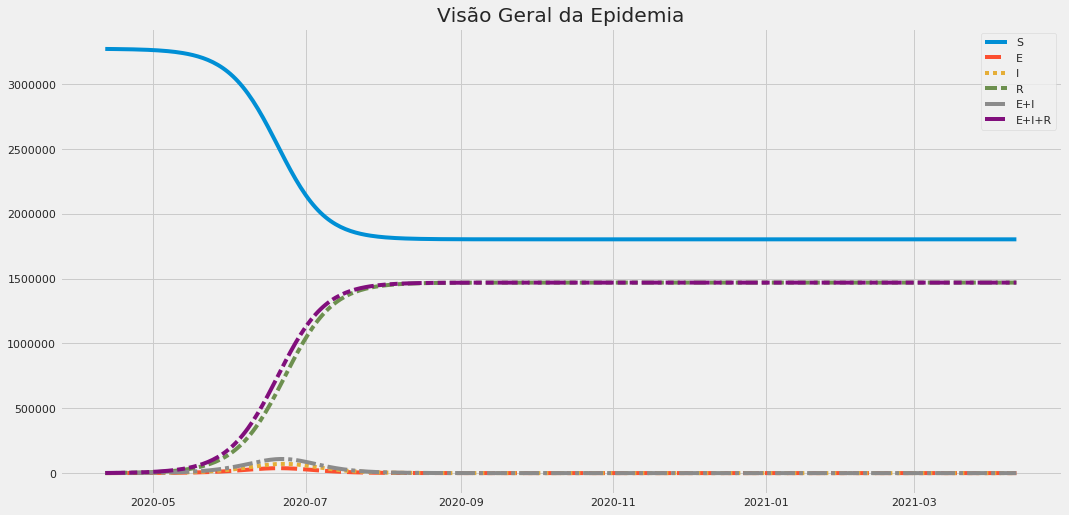

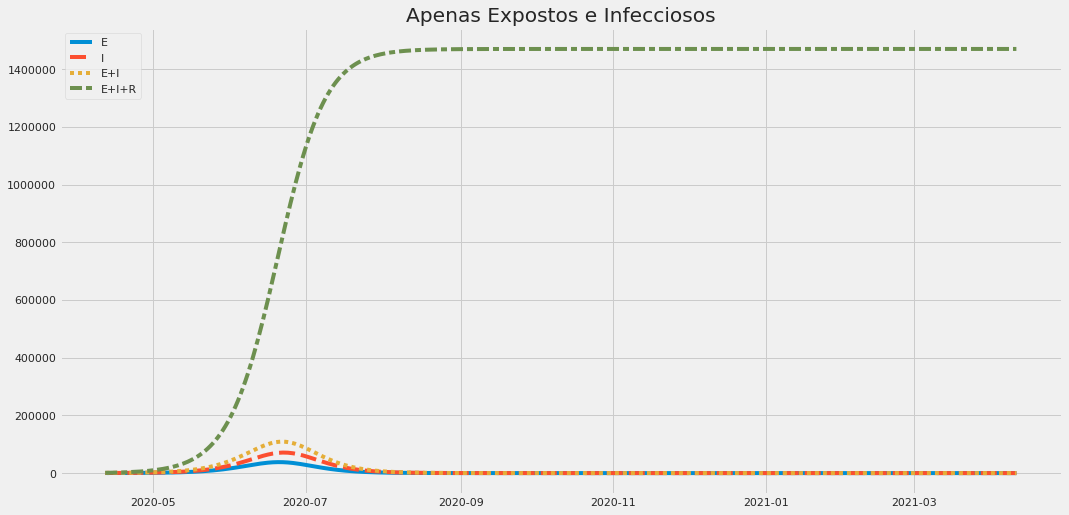

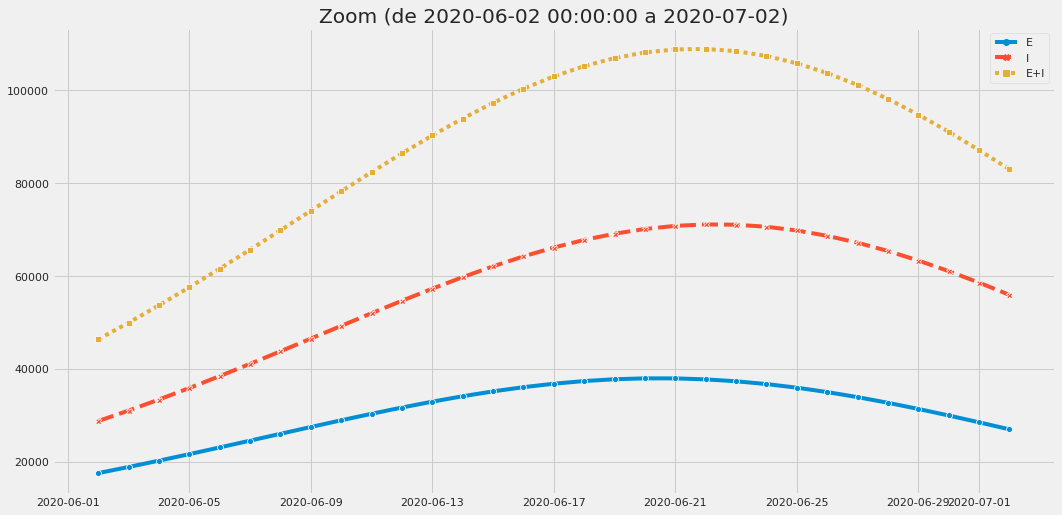

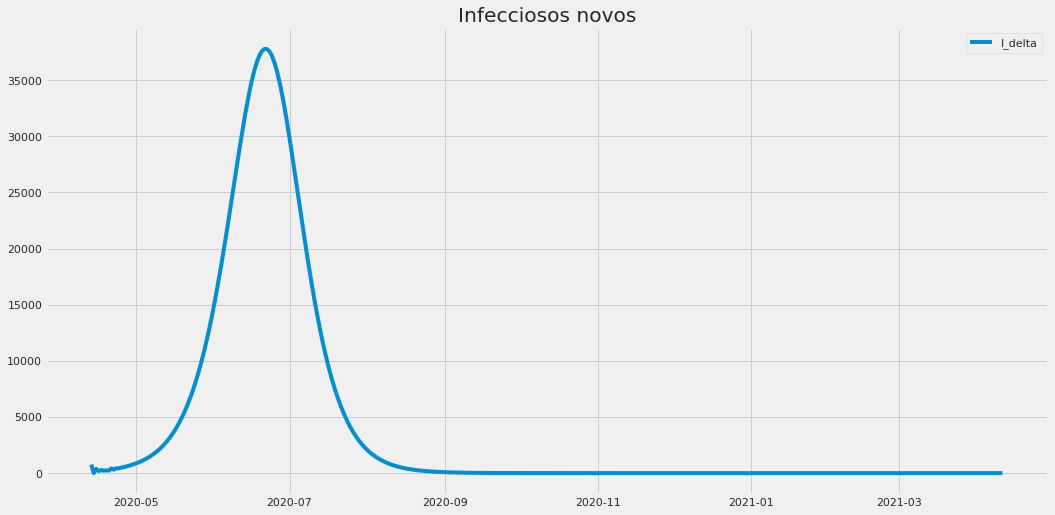

<Figure size 1152x576 with 0 Axes>

In [55]:
df_simulation_mitigation_data = simulate(S=population_size - initially_infected, 
                                          E=initially_infected,
                                          I=0,
                                          R=0, 
                                          alpha=alpha, beta=beta, gamma=gamma, 
                                          epidemic_start_date=epidemic_start_date, 
                                          epidemic_duration_in_days=epidemic_duration_in_days, 
                                          s_func=s, 
                                          e_func=e,
                                          i_func=i, 
                                          r_func=r,
                                          e_delta_func=e_delta,
                                          i_delta_func=i_delta,
                                          r_delta_func=r_delta)

plot_simulation_output(df_simulation_mitigation_data, zoom_length=30, file_name='dynamic')

In [56]:
best['beta_3'] / best['gamma_1']

1.3205248291317673

Como isso essa versão com mitigação se compara visualmente com os dados reais observados?

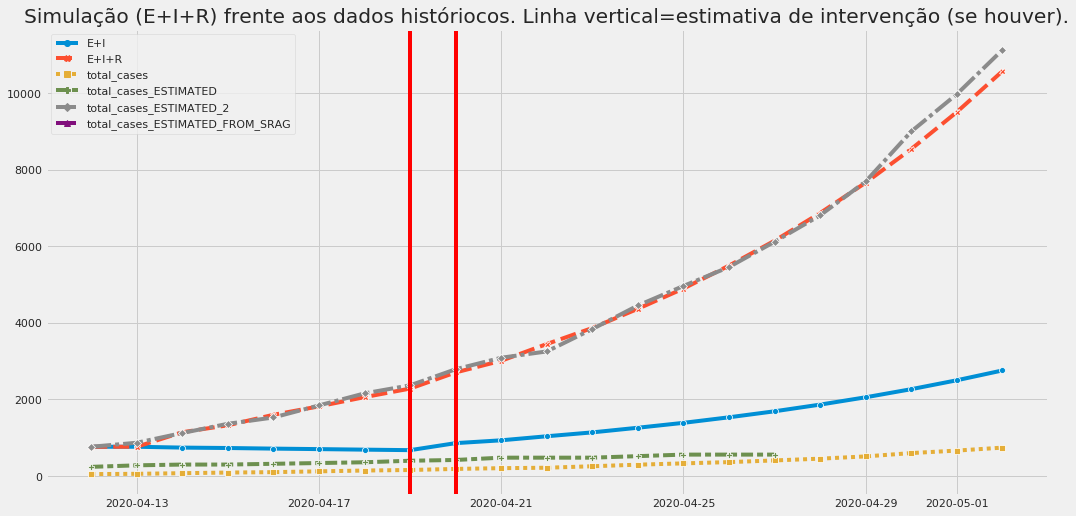

In [57]:
plot_curve_fitting(df_simulation_data=df_simulation_mitigation_data, 
                   df_data_target=df_data_target, 
                   target_location=target_location, 
                   best=best, 
                   file_name='seir_dynamic_fit_zoom')

Finalmente, comparemos os casos com e sem mitigação.

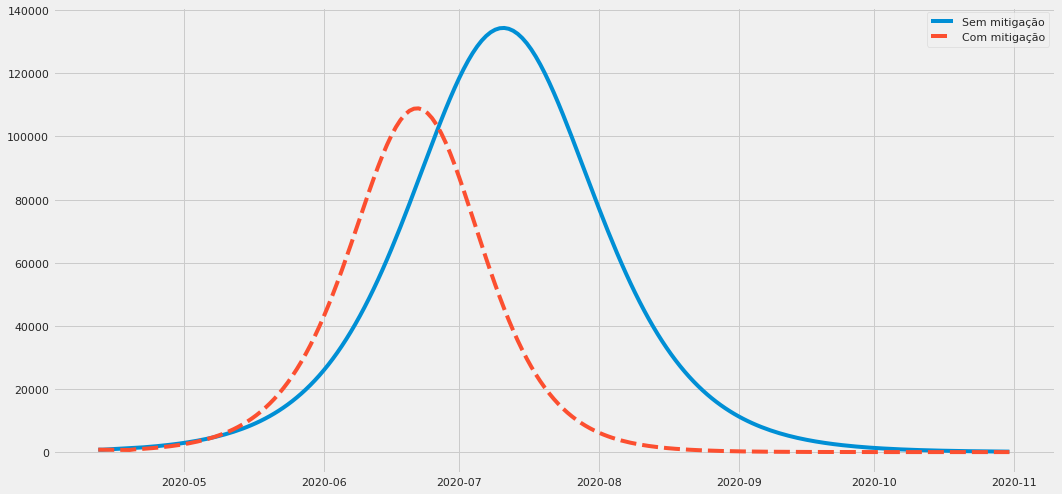

In [58]:
ax = sns.lineplot(data=pd.concat([df_simulation_data['E+I'].rename('Sem mitigação'), 
                                 df_simulation_mitigation_data['E+I'].rename('Com mitigação')], axis=1)['2020-03':'2020-10'])

ax.figure.savefig(results_folder + 'seir_constant_vs_dynamic' + f'_{target_location.lower()}' + results_suffix + '.png', 
                  format='png')

Salvemos os resultados.

In [59]:
df_simulation_mitigation_data.to_csv(results_folder + f'seir_dynamic_model_output.{target_location.lower()}.csv')

## Estudo de Calibragem de Parâmetros Variando-se Pontos de Corte Históricos 

Podemos também considerar o que ocorre com o treino do modelo conforme adquirimos mais dados históricos, simulando o ajuste do modelo ao longo de algumas janelas de tempo.

In [60]:
len(df_data_target)

23

In [61]:
%%time
if run_sensitivity_analysis:
    ss = []
    r0s = []
    for t in range(7, len(df_data_target), 1):
        print(f'###### t={t} ######')
        #space = {'constant':(hyperopt.hp.uniform('alpha', 0.99, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, t)}

        t_2 = 10 if t >= 15.0 else 0.1
        t_3 = 10 if t >= 20.0 else 0.1

        ## assuming different gammas
        #
        #space = \
        #    {'dynamic':\
        #        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_1', 0.0, t)}, 
        #           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_2', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_2', 0.0, t_2)},
        #         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_3', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_3', 0.0, t_3)}], 
        #        0, t)
        #    }

        # assuming gamma_1 == gamma_2 == gamma_3
        space = \
            {'dynamic':\
                ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
                   'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
                   'duration': hyperopt.hp.uniform('duration_1', 0.0, t)}, 
                   {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0),
                   'duration': hyperopt.hp.uniform('duration_2', 0.0, t_2)},
                 {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0),
                   'duration': hyperopt.hp.uniform('duration_3', 0.0, t_3)}], 
                0, t)
            }

        trials = hyperopt.Trials()
        best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=3000, trials=trials)

        print("Best parameters found:", best)

        alpha = dynamic_parameter([(best['alpha_1'], best['duration_1']), 
                                    (best['alpha_2'], best['duration_2']),
                                    (best['alpha_3'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)
        beta = dynamic_parameter([(best['beta_1'], best['duration_1']), 
                                    (best['beta_2'], best['duration_2']),
                                    (best['beta_3'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)
       #gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
       #                            (best['gamma_2'], best['duration_2']),
       #                            (best['gamma_3'], best['duration_3'])],
       #                            min_length=epidemic_duration_in_days)
        gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
                                    (best['gamma_1'], best['duration_2']),
                                    (best['gamma_1'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)

        r0_1 = best['beta_1'] / best['gamma_1']
        r0_2 = best['beta_2'] / best['gamma_1'] # / best['gamma_2']
        r0_3 = best['beta_3'] / best['gamma_1'] # / best['gamma_3']

        r0s.append((r0_1, r0_2, r0_3))
        print(f'R0_1={r0_1}, R0_2={r0_2}, R0_3={r0_3}')


        df_simulation_partial_data = simulate(S=population_size - initially_infected, 
                                                  E=initially_infected,
                                                  I=0,
                                                  R=0, 
                                                  alpha=alpha, beta=beta, gamma=gamma, 
                                                  epidemic_start_date=epidemic_start_date, 
                                                  epidemic_duration_in_days=epidemic_duration_in_days, 
                                                  s_func=s, 
                                                  e_func=e,
                                                  i_func=i, 
                                                  r_func=r,
                                                  e_delta_func=e_delta,
                                                  i_delta_func=i_delta,
                                                  r_delta_func=r_delta)

        ss.append(df_simulation_partial_data['E+I'].rename(f'E+I, t <= {t}'))
        #ax = sns.lineplot(data=df_simulation_partial_data['E+I']['2020-03':'2020-07'])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [62]:
if run_sensitivity_analysis:
    df_r0 = pd.DataFrame(r0s)
    df_r0 = df_r0[df_r0 < 25]#.rolling(3).mean()
    ax = sns.lineplot(data=df_r0, dashes=False)

In [63]:
if run_sensitivity_analysis:
    df = pd.concat(ss, axis=1)['2020-03':'2020-09']

In [64]:
if run_sensitivity_analysis:
    df_filtered = df.iloc[:, 25:]
    palette = sns.color_palette("coolwarm", len(df_filtered.columns))
    ax = sns.lineplot(data=df_filtered, dashes=False, palette=palette)
    ax.set_title('Comparação de diversos pontos de corte (t) nos dados históricos')

In [65]:
if run_sensitivity_analysis:
    palette = sns.color_palette("coolwarm", len(df.columns))
    ax = sns.lineplot(data=df, dashes=False, palette=palette)
    ax.set_title('Comparação de diversos pontos de corte (t) nos dados históricos')

In [66]:
if run_sensitivity_analysis:
    ax.figure.savefig(results_folder + 'seir_multiple_historical_fits_2' + f'_{target_location.lower()}' + results_suffix + '.png', 
                      format='png')

    df.head()

Vemos que há grande sensibilidade do modelo frente a pequenos ajustes nos parâmetros de entrada, embora a maior quantidade de dados favoreça maior estabilidade.